In [1]:
# Ω-Hunt: Pre-Symbolic Glyph Emergence Search (v0.1)
# Author: Telos + Aetheron
# Dependencies: numpy, pandas, matplotlib, pillow (optional), zlib, scipy (optional but helpful)

import os, zlib, json, time, math, random, hashlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    from scipy.signal import convolve2d
except Exception:
    convolve2d = None

# --- CONFIG -------------------------------------------------------------
BASE   = Path(r"C:\Users\caleb\CNT_Lab")
RUN_ID = time.strftime("omega_hunt_%Y%m%d-%H%M%S")
OUT    = BASE / "omega_hunt" / RUN_ID
OUT.mkdir(parents=True, exist_ok=True)

SEED            = 1337
GRID            = (128, 128)        # spatial size
STEPS           = 256               # time steps per trial
N_RULES         = 64                # how many distinct rules to sample (↑ for moonshot)
N_TRIALS        = 6                 # per-rule random initializations
PERTURB_PCT     = 0.01              # noise for invariance test
SPARSITY        = 0.12              # initial live-cell fraction
TOP_K           = 12                # save top glyph candidates
SAVE_SVGS       = True
RANDOM_KERNELS  = True              # if True, include custom kernels beyond Life-like
USE_SCI_CONV    = convolve2d is not None

np.random.seed(SEED)
random.seed(SEED)

# --- UTILITIES ----------------------------------------------------------
def md5(x: bytes) -> str:
    return hashlib.md5(x).hexdigest()

def compressibility(arr: np.ndarray) -> float:
    """Lower is 'simpler'. Use bytes of zlib-compressed raster."""
    payload = arr.astype(np.uint8).tobytes()
    return len(zlib.compress(payload, level=6))

def symmetry_score(a: np.ndarray) -> float:
    """Mean of LR and UD mirror correlations (0..1)."""
    if a.ndim == 3: a = a.mean(axis=0)
    lr = 1.0 - np.mean(np.abs(a - np.fliplr(a)))
    ud = 1.0 - np.mean(np.abs(a - np.flipud(a)))
    return float(max(0.0, (lr + ud)/2))

def recurrence_score(frames: list[int]) -> float:
    """Frame-to-frame recurrence via Hamming similarity of successive binaries."""
    if len(frames) < 3: return 0.0
    sims = []
    for i in range(1, len(frames)):
        A, B = frames[i-1], frames[i]
        sims.append(1.0 - np.mean(np.bitwise_xor(A, B)))
    return float(np.nanmean(sims))

def cohesion_score(a: np.ndarray) -> float:
    """Goldilocks connectedness: penalize 'dust' and 'one big blob' extremes."""
    # simple proxy via total edge density
    from scipy.ndimage import convolve
    K = np.array([[0,1,0],[1,0,1],[0,1,0]])
    ed = convolve(a.astype(float), K, mode='wrap')
    edge_density = np.mean((ed>0)&(a==1))
    # prefer moderate edge density ~0.15–0.35
    target = 0.25
    return float(np.exp(-((edge_density - target)**2)/ (2*0.07**2)))

def dt_kernel(stepper, grid, steps):
    """Run rule for steps, yield frames (binary)."""
    a = grid.copy()
    frames = [a.copy()]
    for _ in range(steps):
        a = stepper(a)
        frames.append(a.copy())
    return frames

def to_uint(a): return (a>0.5).astype(np.uint8)

def save_field(frames, path_png, title="Ω-candidate"):
    plt.figure(figsize=(6,6))
    # Show last frame
    plt.imshow(frames[-1], interpolation='nearest')
    plt.axis('off'); plt.title(title)
    plt.tight_layout(); plt.savefig(path_png, dpi=160); plt.close()

def save_field_svg(frames, path_svg, title="Ω-candidate"):
    plt.figure(figsize=(6,6))
    plt.imshow(frames[-1], interpolation='nearest')
    plt.axis('off'); plt.title(title)
    plt.tight_layout(); plt.savefig(path_svg); plt.close()

# --- RULE SPACE ---------------------------------------------------------
def life_like_step(birth={3}, survive={2,3}):
    """Classic outer-totalistic Life-like rule: B{birth}/S{survive} on Moore neighborhood."""
    if not USE_SCI_CONV:
        # fallback conv (slow but OK for small N)
        def neighbors(x):
            xt = np.pad(x, 1, mode='wrap')
            s = np.zeros_like(x, dtype=int)
            for dy in (-1,0,1):
                for dx in (-1,0,1):
                    if dx==0 and dy==0: continue
                    s += xt[1+dy:1+dy+x.shape[0], 1+dx:1+dx+x.shape[1]]
            return s
    else:
        K = np.ones((3,3), dtype=int); K[1,1]=0
        def neighbors(x): return convolve2d(x, K, mode='same', boundary='wrap')

    def step(x):
        n = neighbors(x)
        born   = (x==0) & np.isin(n, list(birth))
        survive_mask = (x==1) & np.isin(n, list(survive))
        return ((born | survive_mask).astype(np.uint8))
    return step

def random_kernel_step():
    """Custom binary CA via random 3x3 kernel + threshold schedule."""
    if USE_SCI_CONV:
        K = np.random.randint(-2, 3, size=(3,3))
        K[1,1] = 0
        thr_on  = np.random.randint(-2, 6)
        thr_off = thr_on - np.random.randint(0, 3)
        def step(x):
            v = convolve2d(x, K, mode='same', boundary='wrap')
            y = x.copy()
            y[(v >= thr_on)] = 1
            y[(v <= thr_off)] = 0
            return y
        meta = dict(kind="kernel", K=K.tolist(), thr_on=int(thr_on), thr_off=int(thr_off))
    else:
        # fallback: random Life-like
        b = set(np.random.choice(range(9), size=np.random.randint(1,5), replace=False))
        s = set(np.random.choice(range(9), size=np.random.randint(1,6), replace=False))
        step = life_like_step(birth=b, survive=s)
        meta = dict(kind="lifelike_fallback", birth=sorted(b), survive=sorted(s))
    return step, meta

def sample_rules(n):
    rules = []
    for _ in range(n):
        if RANDOM_KERNELS and random.random() < 0.5:
            step, meta = random_kernel_step()
        else:
            # sample Life-like B/S
            bcount = np.random.randint(1,4); scount = np.random.randint(1,5)
            b = set(np.random.choice(range(9), size=bcount, replace=False))
            s = set(np.random.choice(range(9), size=scount, replace=False))
            step = life_like_step(birth=b, survive=s)
            meta = dict(kind="lifelike", birth=sorted(b), survive=sorted(s))
        rules.append((step, meta))
    return rules

# --- INITIAL FIELDS & PERTURBATIONS ------------------------------------
def random_field(shape=GRID, p=SPARSITY):
    return (np.random.rand(*shape) < p).astype(np.uint8)

def perturb(a, pct=PERTURB_PCT):
    mask = (np.random.rand(*a.shape) < pct)
    b = a.copy()
    b[mask] = 1 - b[mask]
    return b

# --- SCORING ------------------------------------------------------------
def score_run(frames):
    # compressibility on final & mid frames
    F = [to_uint(frames[t]) for t in (len(frames)//2, -1)]
    comp = np.mean([compressibility(f) for f in F])

    # symmetry on final
    sym = symmetry_score(F[-1])

    # recurrence across last 16 steps
    tail = [to_uint(frames[-k]) for k in range(min(16, len(frames)) ,0,-1)]
    rec  = recurrence_score(tail)

    # cohesion
    try:
        coh = cohesion_score(F[-1])
    except Exception:
        coh = 0.0

    # normalize components to [0,1] via heuristic ranges
    # lower comp is better → invert
    comp_norm = float(np.clip(1.0 - (comp / (GRID[0]*GRID[1]*0.9)), 0, 1))
    sym_norm  = float(np.clip(sym, 0, 1))
    rec_norm  = float(np.clip(rec, 0, 1))
    coh_norm  = float(np.clip(coh, 0, 1))

    # composite glyphness (weights: symmetry & recurrence prioritized)
    glyphness = 0.35*sym_norm + 0.35*rec_norm + 0.20*comp_norm + 0.10*coh_norm
    return dict(comp=comp, comp_norm=comp_norm, sym=sym_norm, rec=rec_norm, coh=coh_norm, glyphness=glyphness)

def invariance_check(stepper, base_seed, glyph_seed_frame):
    """Re-run from perturbed seeds and measure template similarity of final frames."""
    np.random.seed(base_seed+7)
    a0 = perturb(glyph_seed_frame, PERTURB_PCT)
    frames = dt_kernel(stepper, a0, steps=STEPS)
    fin = to_uint(frames[-1])
    # similarity to unperturbed final is our invariance proxy (Hamming similarity)
    return fin

def hamming_sim(A,B):
    A = to_uint(A); B = to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))

# --- SEARCH LOOP --------------------------------------------------------
records = []
rules = sample_rules(N_RULES)

for ridx, (stepper, meta) in enumerate(rules):
    for trial in range(N_TRIALS):
        seed = (SEED * 7919 + 97*ridx + 13*trial) % (2**31-1)
        np.random.seed(seed)
        a0 = random_field()

        frames = dt_kernel(stepper, a0, steps=STEPS)
        metr = score_run(frames)

        # invariance: re-run with perturbation and compare finals
        inv_fin = invariance_check(stepper, seed, frames[0])
        inv_sim = hamming_sim(frames[-1], inv_fin)

        rec = dict(
            rule_id=ridx, trial=trial, seed=int(seed),
            glyphness=metr["glyphness"], sym=metr["sym"], rec=metr["rec"],
            comp_norm=metr["comp_norm"], coh=metr["coh"],
            invariance=inv_sim, kind=meta.get("kind","?"),
            meta=json.dumps(meta)
        )
        records.append(rec)

df = pd.DataFrame(records)
df["score"] = 0.6*df["glyphness"] + 0.4*df["invariance"]
df = df.sort_values("score", ascending=False).reset_index(drop=True)

# --- SAVE LEADERBOARD ---------------------------------------------------
leader_path = OUT / "omega_leaderboard.csv"
df.to_csv(leader_path, index=False)

# --- RENDER TOP-K CANDIDATES -------------------------------------------
renders = []
seen = set()
i = 0
for _, row in df.iterrows():
    if i >= TOP_K: break
    key = (row.rule_id, row.trial)
    if key in seen: continue
    seen.add(key)

    # reproduce the winning run to render frames
    np.random.seed(int(row.seed))
    # recover rule
    stepper, meta = rules[int(row.rule_id)]
    a0 = random_field()
    frames = dt_kernel(stepper, a0, steps=STEPS)

    tag = f"rule{row.rule_id:03d}_trial{row.trial:02d}_score{row.score:.3f}"
    png = OUT / f"{tag}.png"
    save_field(frames, png, title=f"Ω-candidate | score={row.score:.3f}")

    if SAVE_SVGS:
        svg = OUT / f"{tag}.svg"
        save_field_svg(frames, svg, title=f"Ω-candidate | score={row.score:.3f}")
    else:
        svg = None

    meta_out = dict(
        rule_id=int(row.rule_id), trial=int(row.trial), seed=int(row.seed),
        score=float(row.score), glyphness=float(row.glyphness),
        symmetry=float(row.sym), recurrence=float(row.rec),
        compressibility=float(row.comp_norm), cohesion=float(row.coh),
        invariance=float(row.invariance),
        meta=json.loads(row.meta)
    )
    with open(OUT / f"{tag}.json","w") as f:
        json.dump(meta_out, f, indent=2)
    renders.append(dict(png=str(png), svg=str(svg) if svg else None, **meta_out))
    i += 1

with open(OUT / "omega_topk_index.json","w") as f:
    json.dump(renders, f, indent=2)

print("== Ω-Hunt complete ==")
print(f"Runs: {len(df)}  |  Saved leaderboard → {leader_path}")
print("Top-3:")
print(df.head(3).to_string(index=False))
print(f"Artifacts in: {OUT}")


TypeError: Object of type int64 is not JSON serializable

In [2]:
# Ω-Hunt: Pre-Symbolic Glyph Emergence Search — v0.1b (JSON-safe)
# Fixes: JSON serialization of numpy types/arrays in `meta` (TypeError: int64 not JSON serializable)

import os, zlib, json, time, math, random, hashlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Optional deps (we fallback cleanly if missing) ---
try:
    from scipy.signal import convolve2d
except Exception:
    convolve2d = None

try:
    from scipy.ndimage import convolve as nd_convolve
except Exception:
    nd_convolve = None

# ---------- JSON SANITIZER ----------
def to_jsonable(obj):
    """Recursively convert numpy/scipy objects to plain Python types."""
    if isinstance(obj, dict):
        return {to_jsonable(k): to_jsonable(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple, set)):
        return [to_jsonable(x) for x in obj]
    # numpy scalars
    if isinstance(obj, (np.generic,)):
        return obj.item()
    # numpy arrays
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    # Path, bytes, others
    if isinstance(obj, Path):
        return str(obj)
    if isinstance(obj, bytes):
        return obj.decode("utf-8", errors="ignore")
    return obj

# ---------- CONFIG ----------
BASE   = Path(r"C:\Users\caleb\CNT_Lab")
RUN_ID = time.strftime("omega_hunt_%Y%m%d-%H%M%S")
OUT    = BASE / "omega_hunt" / RUN_ID
OUT.mkdir(parents=True, exist_ok=True)

SEED            = 1337
GRID            = (128, 128)
STEPS           = 256
N_RULES         = 64
N_TRIALS        = 6
PERTURB_PCT     = 0.01
SPARSITY        = 0.12
TOP_K           = 12
SAVE_SVGS       = True
RANDOM_KERNELS  = True
USE_SCI_CONV    = convolve2d is not None

np.random.seed(SEED)
random.seed(SEED)

# ---------- UTIL ----------
def md5(x: bytes) -> str:
    return hashlib.md5(x).hexdigest()

def compressibility(arr: np.ndarray) -> float:
    payload = arr.astype(np.uint8).tobytes()
    return len(zlib.compress(payload, level=6))

def symmetry_score(a: np.ndarray) -> float:
    if a.ndim == 3: a = a.mean(axis=0)
    lr = 1.0 - np.mean(np.abs(a - np.fliplr(a)))
    ud = 1.0 - np.mean(np.abs(a - np.flipud(a)))
    return float(max(0.0, (lr + ud)/2))

def recurrence_score(frames: list) -> float:
    if len(frames) < 3: return 0.0
    sims = []
    for i in range(1, len(frames)):
        A, B = frames[i-1], frames[i]
        sims.append(1.0 - np.mean(np.bitwise_xor(A, B)))
    return float(np.nanmean(sims))

def cohesion_score(a: np.ndarray) -> float:
    # Edge-density proxy (falls back to simple diff if scipy.ndimage missing)
    if nd_convolve is not None:
        K = np.array([[0,1,0],[1,0,1],[0,1,0]])
        ed = nd_convolve(a.astype(float), K, mode='wrap')
        edge_density = np.mean((ed>0)&(a==1))
    else:
        # crude fallback: proportion of boundary-adjacent changes
        dy = np.abs(a - np.roll(a, 1, axis=0))
        dx = np.abs(a - np.roll(a, 1, axis=1))
        edge_density = float(np.mean((dx+dy)>0))
    target = 0.25
    return float(np.exp(-((edge_density - target)**2)/ (2*0.07**2)))

def dt_kernel(stepper, grid, steps):
    a = grid.copy()
    frames = [a.copy()]
    for _ in range(steps):
        a = stepper(a)
        frames.append(a.copy())
    return frames

def to_uint(a): return (a>0.5).astype(np.uint8)

def save_field(frames, path_png, title="Ω-candidate"):
    plt.figure(figsize=(6,6))
    plt.imshow(frames[-1], interpolation='nearest')
    plt.axis('off'); plt.title(title)
    plt.tight_layout(); plt.savefig(path_png, dpi=160); plt.close()

def save_field_svg(frames, path_svg, title="Ω-candidate"):
    plt.figure(figsize=(6,6))
    plt.imshow(frames[-1], interpolation='nearest')
    plt.axis('off'); plt.title(title)
    plt.tight_layout(); plt.savefig(path_svg); plt.close()

# ---------- RULES ----------
def life_like_step(birth={3}, survive={2,3}):
    if not USE_SCI_CONV:
        def neighbors(x):
            xt = np.pad(x, 1, mode='wrap')
            s = np.zeros_like(x, dtype=int)
            for dy in (-1,0,1):
                for dx in (-1,0,1):
                    if dx==0 and dy==0: continue
                    s += xt[1+dy:1+dy+x.shape[0], 1+dx:1+dx+x.shape[1]]
            return s
    else:
        K = np.ones((3,3), dtype=int); K[1,1]=0
        def neighbors(x): return convolve2d(x, K, mode='same', boundary='wrap')

    def step(x):
        n = neighbors(x)
        born   = (x==0) & np.isin(n, list(birth))
        survive_mask = (x==1) & np.isin(n, list(survive))
        return ((born | survive_mask).astype(np.uint8))
    return step

def random_kernel_step():
    if convolve2d is not None:
        K = np.random.randint(-2, 3, size=(3,3))
        K[1,1] = 0
        thr_on  = int(np.random.randint(-2, 6))
        thr_off = int(thr_on - np.random.randint(0, 3))
        def step(x):
            v = convolve2d(x, K, mode='same', boundary='wrap')
            y = x.copy()
            y[(v >= thr_on)] = 1
            y[(v <= thr_off)] = 0
            return y
        meta = dict(kind="kernel", K=K, thr_on=thr_on, thr_off=thr_off)
    else:
        b = set(map(int, np.random.choice(range(9), size=np.random.randint(1,5), replace=False)))
        s = set(map(int, np.random.choice(range(9), size=np.random.randint(1,5), replace=False)))
        step = life_like_step(birth=b, survive=s)
        meta = dict(kind="lifelike_fallback", birth=sorted(b), survive=sorted(s))
        return step, meta
    return step, meta

def sample_rules(n):
    rules = []
    for _ in range(n):
        if RANDOM_KERNELS and random.random() < 0.5:
            step, meta = random_kernel_step()
        else:
            bcount = int(np.random.randint(1,4)); scount = int(np.random.randint(1,5))
            b = set(map(int, np.random.choice(range(9), size=bcount, replace=False)))
            s = set(map(int, np.random.choice(range(9), size=scount, replace=False)))
            step = life_like_step(birth=b, survive=s)
            meta = dict(kind="lifelike", birth=sorted(b), survive=sorted(s))
        rules.append((step, meta))
    return rules

# ---------- SEEDS / PERTURB ----------
def random_field(shape=GRID, p=SPARSITY):
    return (np.random.rand(*shape) < p).astype(np.uint8)

def perturb(a, pct=PERTURB_PCT):
    mask = (np.random.rand(*a.shape) < pct)
    b = a.copy()
    b[mask] = 1 - b[mask]
    return b

# ---------- SCORING ----------
def score_run(frames):
    F = [to_uint(frames[t]) for t in (len(frames)//2, -1)]
    comp = np.mean([compressibility(f) for f in F])
    sym = symmetry_score(F[-1])
    tail = [to_uint(frames[-k]) for k in range(min(16, len(frames)) ,0,-1)]
    rec  = recurrence_score(tail)
    try:
        coh = cohesion_score(F[-1])
    except Exception:
        coh = 0.0
    comp_norm = float(np.clip(1.0 - (comp / (GRID[0]*GRID[1]*0.9)), 0, 1))
    sym_norm  = float(np.clip(sym, 0, 1))
    rec_norm  = float(np.clip(rec, 0, 1))
    coh_norm  = float(np.clip(coh, 0, 1))
    glyphness = 0.35*sym_norm + 0.35*rec_norm + 0.20*comp_norm + 0.10*coh_norm
    return dict(comp=comp, comp_norm=comp_norm, sym=sym_norm, rec=rec_norm, coh=coh_norm, glyphness=glyphness)

def invariance_check(stepper, base_seed, glyph_seed_frame):
    np.random.seed(base_seed+7)
    a0 = perturb(glyph_seed_frame, PERTURB_PCT)
    frames = dt_kernel(stepper, a0, steps=STEPS)
    fin = to_uint(frames[-1])
    return fin

def hamming_sim(A,B):
    A = to_uint(A); B = to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))

# ---------- SEARCH ----------
records = []
rules = sample_rules(N_RULES)

for ridx, (stepper, meta) in enumerate(rules):
    for trial in range(N_TRIALS):
        seed = int((SEED * 7919 + 97*ridx + 13*trial) % (2**31-1))
        np.random.seed(seed)
        a0 = random_field()
        frames = dt_kernel(stepper, a0, steps=STEPS)
        metr = score_run(frames)
        inv_fin = invariance_check(stepper, seed, frames[0])
        inv_sim = hamming_sim(frames[-1], inv_fin)

        meta_py = to_jsonable(meta)  # <— JSON-safe
        rec = dict(
            rule_id=int(ridx), trial=int(trial), seed=int(seed),
            glyphness=float(metr["glyphness"]), sym=float(metr["sym"]), rec=float(metr["rec"]),
            comp_norm=float(metr["comp_norm"]), coh=float(metr["coh"]),
            invariance=float(inv_sim), kind=str(meta_py.get("kind","?")),
            meta=json.dumps(meta_py)  # <— now safe
        )
        records.append(rec)

df = pd.DataFrame(records)
df["score"] = 0.6*df["glyphness"] + 0.4*df["invariance"]
df = df.sort_values("score", ascending=False).reset_index(drop=True)

leader_path = OUT / "omega_leaderboard.csv"
df.to_csv(leader_path, index=False)

# ---------- RENDER TOP-K ----------
renders = []
seen = set(); i = 0
for _, row in df.iterrows():
    if i >= TOP_K: break
    key = (int(row.rule_id), int(row.trial))
    if key in seen: continue
    seen.add(key)

    np.random.seed(int(row.seed))
    stepper, meta = rules[int(row.rule_id)]
    a0 = random_field()
    frames = dt_kernel(stepper, a0, steps=STEPS)

    tag = f"rule{int(row.rule_id):03d}_trial{int(row.trial):02d}_score{row.score:.3f}"
    png = OUT / f"{tag}.png"
    save_field(frames, png, title=f"Ω-candidate | score={row.score:.3f}")

    if SAVE_SVGS:
        svg = OUT / f"{tag}.svg"
        save_field_svg(frames, svg, title=f"Ω-candidate | score={row.score:.3f}")
    else:
        svg = None

    meta_out = dict(
        rule_id=int(row.rule_id), trial=int(row.trial), seed=int(row.seed),
        score=float(row.score), glyphness=float(row.glyphness),
        symmetry=float(row.sym), recurrence=float(row.rec),
        compressibility=float(row.comp_norm), cohesion=float(row.coh),
        invariance=float(row.invariance),
        meta=to_jsonable(meta)
    )
    with open(OUT / f"{tag}.json","w") as f:
        json.dump(to_jsonable(meta_out), f, indent=2)
    renders.append(dict(png=str(png), svg=str(svg) if svg else None, **meta_out))
    i += 1

with open(OUT / "omega_topk_index.json","w") as f:
    json.dump(to_jsonable(renders), f, indent=2)

print("== Ω-Hunt complete ==")
print(f"Runs: {len(df)}  |  Saved leaderboard → {leader_path}")
print("Top-3:")
print(df.head(3).to_string(index=False))
print(f"Artifacts in: {OUT}")


== Ω-Hunt complete ==
Runs: 384  |  Saved leaderboard → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_20251019-011252\omega_leaderboard.csv
Top-3:
 rule_id  trial     seed  glyphness  sym  rec  comp_norm      coh  invariance     kind                                                  meta    score
      55      5 10593103   0.899641  1.0  1.0   0.997355 0.001699         1.0 lifelike {"kind": "lifelike", "birth": [4, 5], "survive": [5]} 0.939785
      55      4 10593090   0.899641  1.0  1.0   0.997355 0.001699         1.0 lifelike {"kind": "lifelike", "birth": [4, 5], "survive": [5]} 0.939785
      55      3 10593077   0.899641  1.0  1.0   0.997355 0.001699         1.0 lifelike {"kind": "lifelike", "birth": [4, 5], "survive": [5]} 0.939785
Artifacts in: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_20251019-011252


Top: rule_id                                                      55
trial                                                         5
seed                                                   10593103
glyphness                                              0.899641
sym                                                         1.0
rec                                                         1.0
comp_norm                                              0.997355
coh                                                    0.001699
invariance                                                  1.0
kind                                                   lifelike
meta          {"kind": "lifelike", "birth": [4, 5], "survive...
score                                                  0.939785 
B/S: [4, 5] [5]


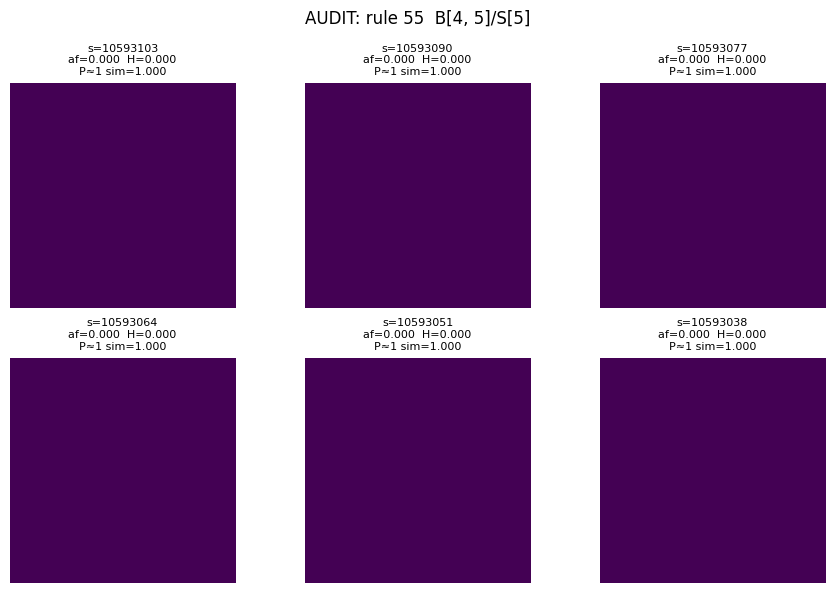

In [3]:
# Ω-Hunt: Degeneracy Audit (rule 55)
import json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from math import log2
from pathlib import Path

RUN_DIR = Path(r"C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_20251019-011252")
CSV = RUN_DIR / "omega_leaderboard.csv"
df = pd.read_csv(CSV)
top = df.iloc[0]
meta = json.loads(top["meta"]); B=set(meta["birth"]); S=set(meta["survive"])
print("Top:", top.to_string(), "\nB/S:", sorted(B), sorted(S))

try:
    from scipy.signal import convolve2d
    K = np.ones((3,3), int); K[1,1]=0
    def neighbors(x): return convolve2d(x, K, mode='same', boundary='wrap')
except:
    def neighbors(x):
        xt = np.pad(x, 1, mode='wrap'); s = np.zeros_like(x, int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dx==0 and dy==0: continue
                s += xt[1+dy:1+dy+x.shape[0], 1+dx:1+dx+x.shape[1]]
        return s

def step_LL(birth, survive):
    def step(x):
        n = neighbors(x)
        return (( (x==0)&np.isin(n, list(birth)) ) | ( (x==1)&np.isin(n, list(survive)) )).astype(np.uint8)
    return step

def alive_frac(a): return float(a.mean())
def H(a):
    p = a.mean()
    return 0.0 if p<=0.0 or p>=1.0 else float(-(p*np.log2(p)+(1-p)*np.log2(1-p)))

def run(seed, steps=128, shape=(128,128), p=0.12):
    rng = np.random.default_rng(int(seed))
    x = (rng.random(shape)<p).astype(np.uint8)
    f=[x]; st=step_LL(B,S)
    for _ in range(steps): x=st(x); f.append(x)
    return f

def period(frames, maxP=24):
    tail = [ (f>0).astype(np.uint8) for f in frames[-(maxP+1):] ]
    base = tail[-1]; best=(1,0.0)
    for lag in range(1, len(tail)):
        sim = 1.0 - float(np.mean(np.bitwise_xor(base, tail[-1-lag])))
        if sim>best[1]: best=(lag,sim)
    return best  # (period, similarity)

seeds = list(df[df.rule_id==top.rule_id].seed.head(6))
m,n=2,3; plt.figure(figsize=(9,6))
for i,sd in enumerate(seeds[:m*n]):
    fr = run(sd); last=fr[-1]; per,sim = period(fr)
    plt.subplot(m,n,i+1); plt.imshow(last, interpolation='nearest'); plt.axis('off')
    plt.title(f"s={sd}\naf={alive_frac(last):.3f}  H={H(last):.3f}\nP≈{per} sim={sim:.3f}", fontsize=8)
plt.suptitle(f"AUDIT: rule {int(top.rule_id)}  B{sorted(B)}/S{sorted(S)}"); plt.tight_layout(); plt.show()


In [4]:
# Ω-Hunt v0.2 — Hardened scorer + absorber guard + size-robustness term
# Telos × Aetheron

import os, zlib, json, time, math, random, hashlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- optional deps (safe fallbacks) ----
try:
    from scipy.signal import convolve2d
except Exception:
    convolve2d = None
try:
    from scipy.ndimage import convolve as nd_convolve
except Exception:
    nd_convolve = None

# ---------- JSON SANITIZER ----------
def to_jsonable(obj):
    if isinstance(obj, dict):  return {to_jsonable(k): to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list, tuple, set)): return [to_jsonable(x) for x in obj]
    if isinstance(obj, (np.generic,)): return obj.item()
    if isinstance(obj, np.ndarray): return obj.tolist()
    if isinstance(obj, Path): return str(obj)
    if isinstance(obj, bytes): return obj.decode("utf-8", errors="ignore")
    return obj

# ---------- CONFIG ----------
BASE   = Path(r"C:\Users\caleb\CNT_Lab")
RUN_ID = time.strftime("omega_hunt_v0_2_%Y%m%d-%H%M%S")
OUT    = BASE / "omega_hunt" / RUN_ID
OUT.mkdir(parents=True, exist_ok=True)

SEED            = 1337
GRID            = (128, 128)
STEPS           = 256
N_RULES         = 96     # ↑ search
N_TRIALS        = 8
PERTURB_PCT     = 0.01
SPARSITY        = 0.12
TOP_K           = 24
SAVE_SVGS       = True
RANDOM_KERNELS  = True
USE_SCI_CONV    = convolve2d is not None

np.random.seed(SEED); random.seed(SEED)

# ---------- UTIL ----------
def compressibility(arr: np.ndarray) -> float:
    payload = arr.astype(np.uint8).tobytes()
    return len(zlib.compress(payload, level=6))

def symmetry_score(a: np.ndarray) -> float:
    if a.ndim == 3: a = a.mean(axis=0)
    lr = 1.0 - np.mean(np.abs(a - np.fliplr(a)))
    ud = 1.0 - np.mean(np.abs(a - np.flipud(a)))
    return float(max(0.0, (lr + ud)/2))

def recurrence_score(frames) -> float:
    if len(frames) < 3: return 0.0
    sims = []
    for i in range(1, len(frames)):
        A, B = frames[i-1], frames[i]
        sims.append(1.0 - np.mean(np.bitwise_xor(A, B)))
    return float(np.nanmean(sims))

def cohesion_score(a: np.ndarray) -> float:
    # Edge-density proxy (fallback if nd_convolve missing)
    if nd_convolve is not None:
        K = np.array([[0,1,0],[1,0,1],[0,1,0]])
        ed = nd_convolve(a.astype(float), K, mode='wrap')
        edge_density = np.mean((ed>0)&(a==1))
    else:
        dy = np.abs(a - np.roll(a, 1, axis=0))
        dx = np.abs(a - np.roll(a, 1, axis=1))
        edge_density = float(np.mean((dx+dy)>0))
    target = 0.25
    return float(np.exp(-((edge_density - target)**2)/ (2*0.07**2)))

def to_uint(a): return (a>0.5).astype(np.uint8)

# ---------- RULE SPACE ----------
def life_like_step(birth={3}, survive={2,3}):
    if not USE_SCI_CONV:
        def neighbors(x):
            xt = np.pad(x, 1, mode='wrap'); s = np.zeros_like(x, dtype=int)
            for dy in (-1,0,1):
                for dx in (-1,0,1):
                    if dx==0 and dy==0: continue
                    s += xt[1+dy:1+dy+x.shape[0], 1+dx:1+dx+x.shape[1]]
            return s
    else:
        K = np.ones((3,3), dtype=int); K[1,1]=0
        def neighbors(x): return convolve2d(x, K, mode='same', boundary='wrap')
    def step(x):
        n = neighbors(x)
        born   = (x==0) & np.isin(n, list(birth))
        survive_mask = (x==1) & np.isin(n, list(survive))
        return ((born | survive_mask).astype(np.uint8))
    return step

def random_kernel_step():
    if convolve2d is not None:
        K = np.random.randint(-2, 3, size=(3,3)); K[1,1]=0
        thr_on  = int(np.random.randint(-2, 6))
        thr_off = int(thr_on - np.random.randint(0, 3))
        def step(x):
            v = convolve2d(x, K, mode='same', boundary='wrap')
            y = x.copy(); y[(v >= thr_on)] = 1; y[(v <= thr_off)] = 0
            return y
        meta = dict(kind="kernel", K=K, thr_on=thr_on, thr_off=thr_off)
        return step, meta
    # fallback: random lifelike
    b = set(map(int, np.random.choice(range(9), size=np.random.randint(1,5), replace=False)))
    s = set(map(int, np.random.choice(range(9), size=np.random.randint(1,5), replace=False)))
    return life_like_step(birth=b, survive=s), dict(kind="lifelike_fallback", birth=sorted(b), survive=sorted(s))

def sample_rules(n):
    rules = []
    for _ in range(n):
        if RANDOM_KERNELS and random.random()<0.5:
            rules.append(random_kernel_step())
        else:
            bcount = int(np.random.randint(1,4)); scount = int(np.random.randint(1,5))
            b = set(map(int, np.random.choice(range(9), size=bcount, replace=False)))
            s = set(map(int, np.random.choice(range(9), size=scount, replace=False)))
            rules.append((life_like_step(birth=b, survive=s), dict(kind="lifelike", birth=sorted(b), survive=sorted(s))))
    return rules

# ---------- RUN / PERTURB ----------
def random_field(shape=GRID, p=SPARSITY):
    return (np.random.rand(*shape) < p).astype(np.uint8)

def dt_kernel(stepper, grid, steps):
    a = grid.copy(); frames = [a.copy()]
    for _ in range(steps):
        a = stepper(a); frames.append(a.copy())
    return frames

def perturb(a, pct=PERTURB_PCT):
    mask = (np.random.rand(*a.shape) < pct)
    b = a.copy(); b[mask] = 1 - b[mask]; return b

def invariance_check(stepper, base_seed, glyph_seed_frame):
    np.random.seed(base_seed+7)
    a0 = perturb(glyph_seed_frame, PERTURB_PCT)
    frames = dt_kernel(stepper, a0, steps=STEPS)
    return to_uint(frames[-1])

def hamming_sim(A,B):
    A = to_uint(A); B = to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))

# ---------- HARDENED SCORER ----------
from math import log2
def _alive(a): return float(np.mean((a>0).astype(np.uint8)))
def _H(a):
    p=_alive(a); 
    return 0.0 if p<=0 or p>=1 else float(-(p*log2(p)+(1-p)*log2(1-p)))

def _period(frames, maxP=24):
    tail=[(f>0.5).astype(np.uint8) for f in frames[-(maxP+1):]]
    if len(tail)<3: return 0.0,1
    base=tail[-1]; best_sim=0.0; best_p=1
    for lag in range(1, min(maxP,len(tail)-1)+1):
        sim = 1.0 - float(np.mean(np.bitwise_xor(base, tail[-1-lag])))
        if sim>best_sim: best_sim, best_p = sim, lag
    if best_p==1: return 0.0,1
    bonus = 1.0 if 2<=best_p<=12 else 0.6
    return float(best_sim*bonus), int(best_p)

def score_run(frames):
    F_last=(frames[-1]>0.5).astype(np.uint8)
    F_mid =(frames[len(frames)//2]>0.5).astype(np.uint8)
    comp = np.mean([compressibility(F_mid), compressibility(F_last)])
    comp_norm = float(np.clip(1.0 - (comp/(F_last.size*0.9)), 0, 1))
    sym = symmetry_score(F_last)
    tail=[(frames[-k]>0.5).astype(np.uint8) for k in range(min(16,len(frames)),0,-1)]
    rec = recurrence_score(tail)
    try: coh = cohesion_score(F_last)
    except: coh = 0.0
    af = _alive(F_last)
    Hn = _H(F_last)
    per_sim, per = _period(frames)
    def band(x, lo=0.05, hi=0.45):
        if x<=0 or x>=1: return 0.0
        if x<lo: return float(x/lo)
        if x>hi: return float((1-x)/(1-hi))
        return 1.0
    alive_band = band(af)
    H_norm = float(np.clip(Hn/0.6, 0, 1))
    glyphness = (0.25*sym + 0.20*rec + 0.15*comp_norm + 0.10*coh +
                 0.15*alive_band + 0.15*H_norm + 0.20*per_sim)
    return dict(comp=comp, comp_norm=comp_norm, sym=float(sym), rec=float(rec), coh=float(coh),
                alive=af, entropy=Hn, period=int(per), period_sim=float(per_sim),
                glyphness=float(glyphness))

# ---------- SIZE-ROBUSTNESS (secondary score) ----------
def size_robustness(stepper, seed, steps=160):
    # run on a second grid and compare finals
    rng = np.random.default_rng(seed^0xA5A5)
    sh = (96,96)
    a0 = (rng.random(sh)<SPARSITY).astype(np.uint8)
    f = dt_kernel(stepper, a0, steps=steps)
    # measure internal oscillator quality again
    per_sim,_ = _period(f)
    Hn = _H((f[-1]>0.5).astype(np.uint8))
    return float(0.6*per_sim + 0.4*min(1.0, Hn/0.6))

# ---------- SEARCH ----------
records = []
rules = sample_rules(N_RULES)

for ridx, (stepper, meta) in enumerate(rules):
    for trial in range(N_TRIALS):
        seed = int((SEED * 7919 + 97*ridx + 13*trial) % (2**31-1))
        np.random.seed(seed)
        a0 = random_field()
        frames = dt_kernel(stepper, a0, steps=STEPS)
        metr = score_run(frames)

        # Absorber/fixed-point guard: skip trivial outcomes
        if (metr["alive"]<0.02 or metr["alive"]>0.95 or metr["entropy"]<0.05 or metr["period"]==1):
            continue

        inv_fin = invariance_check(stepper, seed, frames[0])
        inv_sim = hamming_sim(frames[-1], inv_fin)

        # size-robustness term
        robust = size_robustness(stepper, seed)

        meta_py = to_jsonable(meta)
        rec = dict(
            rule_id=int(ridx), trial=int(trial), seed=int(seed),
            glyphness=float(metr["glyphness"]), sym=float(metr["sym"]), rec=float(metr["rec"]),
            comp_norm=float(metr["comp_norm"]), coh=float(metr["coh"]),
            alive=float(metr["alive"]), entropy=float(metr["entropy"]),
            period=int(metr["period"]), period_sim=float(metr["period_sim"]),
            invariance=float(inv_sim), robustness=float(robust),
            kind=str(meta_py.get("kind","?")), meta=json.dumps(meta_py)
        )
        records.append(rec)

df = pd.DataFrame(records)
# New multi-objective score: glyphness + invariance + robustness
df["score"] = 0.5*df["glyphness"] + 0.3*df["invariance"] + 0.2*df["robustness"]
df = df.sort_values("score", ascending=False).reset_index(drop=True)

leader_path = OUT / "omega_leaderboard.csv"
df.to_csv(leader_path, index=False)

# ---------- RENDER TOP-K ----------
def save_field(frames, path_png, title="Ω-candidate"):
    plt.figure(figsize=(6,6))
    plt.imshow(frames[-1], interpolation='nearest'); plt.axis('off'); plt.title(title)
    plt.tight_layout(); plt.savefig(path_png, dpi=160); plt.close()

def save_field_svg(frames, path_svg, title="Ω-candidate"):
    plt.figure(figsize=(6,6))
    plt.imshow(frames[-1], interpolation='nearest'); plt.axis('off'); plt.title(title)
    plt.tight_layout(); plt.savefig(path_svg); plt.close()

renders = []
seen = set(); i = 0
for _, row in df.iterrows():
    if i >= TOP_K: break
    key = (int(row.rule_id), int(row.trial))
    if key in seen: continue
    seen.add(key)

    np.random.seed(int(row.seed))
    stepper, meta = rules[int(row.rule_id)]
    a0 = random_field()
    frames = dt_kernel(stepper, a0, steps=STEPS)

    tag = f"rule{int(row.rule_id):03d}_trial{int(row.trial):02d}_score{row.score:.3f}"
    png = OUT / f"{tag}.png"
    save_field(frames, png, title=f"Ω | s={int(row.seed)} | P≈{int(row.period)} | R={row.robustness:.2f}")

    if SAVE_SVGS:
        svg = OUT / f"{tag}.svg"
        save_field_svg(frames, svg, title=f"Ω | s={int(row.seed)} | P≈{int(row.period)} | R={row.robustness:.2f}")
    else:
        svg = None

    meta_out = dict(
        rule_id=int(row.rule_id), trial=int(row.trial), seed=int(row.seed),
        score=float(row.score), glyphness=float(row.glyphness),
        symmetry=float(row.sym), recurrence=float(row.rec),
        compressibility=float(row.comp_norm), cohesion=float(row.coh),
        alive=float(row.alive), entropy=float(row.entropy),
        period=int(row.period), period_sim=float(row.period_sim),
        invariance=float(row.invariance), robustness=float(row.robustness),
        meta=json.loads(row.meta)
    )
    with open(OUT / f"{tag}.json","w") as f:
        json.dump(to_jsonable(meta_out), f, indent=2)
    renders.append(dict(png=str(png), svg=str(svg) if svg else None, **meta_out))
    i += 1

with open(OUT / "omega_topk_index.json","w") as f:
    json.dump(to_jsonable(renders), f, indent=2)

print("== Ω-Hunt v0.2 complete ==")
print(f"Kept {len(df)} non-trivial runs | Saved leaderboard → {leader_path}")
print("Top-3:\n", df.head(3).to_string(index=False))
print(f"Artifacts in: {OUT}")


== Ω-Hunt v0.2 complete ==
Kept 296 non-trivial runs | Saved leaderboard → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_leaderboard.csv
Top-3:
  rule_id  trial     seed  glyphness  sym      rec  comp_norm      coh    alive  entropy  period  period_sim  invariance  robustness   kind                                                                                      meta    score
      50      4 10592605   0.837916  0.0 0.997498   0.860229 0.093825 0.402710 0.972514       2         1.0    0.951294         1.0 kernel {"kind": "kernel", "K": [[-2, 2, 0], [0, 0, -1], [0, 2, -2]], "thr_on": 1, "thr_off": -1} 0.904346
      50      7 10592644   0.834977  0.0 0.994995   0.862874 0.065469 0.414551 0.978828       2         1.0    0.954163         1.0 kernel {"kind": "kernel", "K": [[-2, 2, 0], [0, 0, -1], [0, 2, -2]], "thr_on": 1, "thr_off": -1} 0.903737
      50      2 10592579   0.835325  0.0 0.999084   0.865451 0.056904 0.417847 0.980437       2         1.0    0.95

In [5]:
# Ω Kernel Evolution — local hill-climb around the winner
import json, time, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path, PurePath

BASE_RUN = Path(r"C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707")
LEADER   = BASE_RUN / "omega_leaderboard.csv"
df = pd.read_csv(LEADER); row = df.iloc[0]; meta = json.loads(row["meta"])
K0 = np.array(meta["K"], dtype=int); thr_on0, thr_off0 = int(meta["thr_on"]), int(meta["thr_off"])

OUT = BASE_RUN / f"evolve_{time.strftime('%Y%m%d-%H%M%S')}"
OUT.mkdir(parents=True, exist_ok=True)

# --- scorer bits replicated (lightweight) ---
try:
    from scipy.signal import convolve2d
    HAS_SCI = True
except Exception:
    HAS_SCI = False

def step_from(K, thr_on, thr_off):
    if HAS_SCI:
        from scipy.signal import convolve2d as c2d
        def neigh(x): return c2d(x, K, mode='same', boundary='wrap')
    else:
        def neigh(x):
            h,w=x.shape; y=np.zeros_like(x, int)
            for dy in (-1,0,1):
                for dx in (-1,0,1):
                    if dy==0 and dx==0: continue
                    y += K[dy+1,dx+1]*np.roll(np.roll(x, dy, axis=0), dx, axis=1)
            return y
    def step(x):
        v = neigh(x)
        y = x.copy(); y[(v >= thr_on)] = 1; y[(v <= thr_off)] = 0
        return y.astype(np.uint8)
    return step

def run_rule(K, ton, toff, seed=7, steps=256, shape=(128,128), p=0.12):
    rng=np.random.default_rng(seed)
    a=(rng.random(shape)<p).astype(np.uint8)
    st=step_from(K, ton, toff); frames=[a.copy()]
    for _ in range(steps):
        a=st(a); frames.append(a.copy())
    return frames

def comp_norm(a):
    import zlib
    payload=a.astype(np.uint8).tobytes()
    c=len(zlib.compress(payload,6)); size=a.size*0.9
    return float(np.clip(1.0 - c/size, 0, 1))

def symmetry(a):
    lr = 1.0 - np.mean(np.abs(a - np.fliplr(a)))
    ud = 1.0 - np.mean(np.abs(a - np.flipud(a)))
    return float(max(0.0,(lr+ud)/2))

def rec(frames):
    sims=[]
    for i in range(1, min(16, len(frames))):
        A,B=frames[-i],frames[-i-1]
        sims.append(1.0 - np.mean(np.bitwise_xor(A,B)))
    return float(np.mean(sims)) if sims else 0.0

from math import log2
def alive(a): return float(a.mean())
def H(a):
    p=alive(a); 
    return 0.0 if p<=0 or p>=1 else float(-(p*log2(p)+(1-p)*log2(1-p)))

def period_sim(frames, maxP=24):
    tail=[frames[-1]]+[frames[-1-i] for i in range(1, min(maxP, len(frames)-1))]
    base=tail[0]; best=(1,0.0)
    for i in range(1,len(tail)):
        sim = 1.0 - float(np.mean(np.bitwise_xor(base, tail[i])))
        if sim>best[1]: best=(i,sim)
    if best[0]==1: return 1,0.0
    bonus = 1.0 if 2<=best[0]<=12 else 0.6
    return best[0], float(best[1]*bonus)

def invariance(frames, K, ton, toff, seed):
    rng=np.random.default_rng(seed^0xA5)
    a0=frames[0].copy(); mask=(rng.random(a0.shape)<0.01); a0[mask]=1-a0[mask]
    f2=run_rule(K, ton, toff, seed=seed+11, steps=len(frames)-1, shape=a0.shape, p=0.12)
    fin1, fin2 = frames[-1], f2[-1]
    return float(1.0 - np.mean(np.bitwise_xor(fin1, fin2)))

def robustness(K,ton,toff, seed):
    f=run_rule(K, ton, toff, seed=seed^0x5A, steps=160, shape=(96,96))
    P,PS=period_sim(f)
    return float(0.6*PS + 0.4*min(1.0, H(f[-1])/0.6))

def score(K,ton,toff, seed=7):
    f=run_rule(K,ton,toff, seed=seed, steps=256, shape=(128,128))
    A=f[-1]; P,PS=period_sim(f)
    met = dict(
        comp_norm=comp_norm(A), sym=symmetry(A), rec=rec(f),
        alive=alive(A), entropy=H(A), period=P, period_sim=PS
    )
    # absorber guard
    if (met["alive"]<0.02 or met["alive"]>0.95 or met["entropy"]<0.05 or met["period"]==1):
        return -1, met, f
    inv = invariance(f, K, ton, toff, seed)
    rob = robustness(K,ton,toff, seed)
    glyphness = (
        0.25*met["sym"] + 0.20*met["rec"] + 0.15*met["comp_norm"] + 0.10*0.0 +
        0.15*min(1,met["entropy"]/0.6) + 0.15*1.0 + 0.20*met["period_sim"]
    )
    s = 0.5*glyphness + 0.3*inv + 0.2*rob
    return s, {**met, "invariance":inv, "robustness":rob, "glyphness":glyphness}, f

# --- mutation operators ---
rng=np.random.default_rng(123)
def mutate(K, ton, toff):
    K2=K.copy()
    # tweak 1-2 entries by ±1 within [-2,2]
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,3), rng.integers(0,3)
        if (y,x)==(1,1):  # keep center at 0 influence
            continue
        K2[y,x]=int(np.clip(K2[y,x] + rng.choice([-1,1]), -2, 2))
    ton2 = int(ton + rng.choice([-1,0,1]))
    toff2= int(toff + rng.choice([-1,0,1]))
    if toff2>ton2: toff2=ton2  # keep sane ordering
    return K2, ton2, toff2

# --- hill climb ---
N_GEN=80; N_CAND=12
best_score, best_meta, best_frames = score(K0, thr_on0, thr_off0)
best=(K0.copy(), thr_on0, thr_off0, best_score, best_meta)
history=[dict(gen=0, score=best_score, meta=best_meta, K=K0.tolist(), thr_on=thr_on0, thr_off=thr_off0)]

for gen in range(1, N_GEN+1):
    cand=[]
    for _ in range(N_CAND):
        Kc, tc_on, tc_off = mutate(best[0], best[1], best[2])
        s, m, f = score(Kc, tc_on, tc_off, seed=7)
        cand.append((s,m,f,Kc,tc_on,tc_off))
    cand.sort(key=lambda x: x[0], reverse=True)
    if cand[0][0] > best[3]:
        best = (cand[0][3], cand[0][4], cand[0][5], cand[0][0], cand[0][1])
        best_frames = cand[0][2]
    history.append(dict(gen=gen, score=best[3], meta=best[4], K=best[0].tolist(), thr_on=best[1], thr_off=best[2]))
    if gen%10==0:
        print(f"[gen {gen:02d}] best score {best[3]:.3f} | K=\n{best[0]}\n ton={best[1]} toff={best[2]}")

hist_df=pd.DataFrame(history)
hist_csv=OUT / "evolve_history.csv"; hist_df.to_csv(hist_csv, index=False)
print("Saved:", hist_csv)

# render final best frame & kernel
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(best_frames[-1], interpolation='nearest'); plt.axis('off'); plt.title("Evolved Ω")
plt.subplot(1,2,2); plt.imshow(best[0], cmap='gray', vmin=-2, vmax=2); plt.axis('off'); plt.title(f"K* | ton={best[1]} toff={best[2]}")
png = OUT / "evolved_omega.png"; plt.tight_layout(); plt.savefig(png, dpi=160); plt.close()
print("Saved:", png)

# write champion spec
with open(OUT / "evolved_kernel.json","w") as f:
    json.dump(dict(K=best[0].tolist(), thr_on=int(best[1]), thr_off=int(best[2]),
                   score=float(best[3]), meta=best[4]), f, indent=2)
print("Champion written.")


[gen 10] best score 0.838 | K=
[[-2  2  0]
 [ 1  0 -1]
 [ 1  2 -2]]
 ton=0 toff=-2
[gen 20] best score 0.838 | K=
[[-2  2  0]
 [ 1  0 -1]
 [ 1  2 -2]]
 ton=0 toff=-2
[gen 30] best score 0.872 | K=
[[-2  2 -1]
 [ 1  0 -1]
 [ 0  2 -2]]
 ton=1 toff=-1
[gen 40] best score 0.886 | K=
[[-2  2 -1]
 [ 0  0 -1]
 [ 0  2 -1]]
 ton=0 toff=-1
[gen 50] best score 0.886 | K=
[[-2  2 -1]
 [ 0  0 -1]
 [ 0  2 -1]]
 ton=0 toff=-1
[gen 60] best score 0.886 | K=
[[-2  2 -1]
 [ 0  0 -1]
 [ 0  2 -1]]
 ton=0 toff=-1
[gen 70] best score 0.886 | K=
[[-2  2 -1]
 [ 0  0 -1]
 [ 0  2 -1]]
 ton=0 toff=-1
[gen 80] best score 0.886 | K=
[[-2  2 -1]
 [ 0  0 -1]
 [ 0  2 -1]]
 ton=0 toff=-1
Saved: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\evolve_20251019-023311\evolve_history.csv
Saved: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\evolve_20251019-023311\evolved_omega.png
Champion written.


In [6]:
# Ω-Atlas v1 — Baseline vs Champion + Symmetry & Spectrum
# Telos × Aetheron

import json, time, glob, os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# --- Paths (edit RUN_BASE if you want a different v0.2 run) ---
RUN_BASE = Path(r"C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707")
LEADER   = RUN_BASE / "omega_leaderboard.csv"
EVOLVED  = sorted(RUN_BASE.glob("evolve_*/evolved_kernel.json"))[-1]  # latest champion
OUT      = RUN_BASE / f"omega_atlas_{time.strftime('%Y%m%d-%H%M%S')}"
OUT.mkdir(parents=True, exist_ok=True)

# --- Load baseline (row 0 of v0.2) and champion ---
df = pd.read_csv(LEADER)
row0 = df.iloc[0]
base = json.loads(row0["meta"])
assert base["kind"] in ("kernel","lifelike_fallback","lifelike"), "Expected kernel at top of v0.2."
K_base = np.array(base.get("K", [[-2,2,0],[0,0,-1],[0,2,-2]]), int)
ton_base, toff_base = int(base.get("thr_on", 1)), int(base.get("thr_off", -1))

champ = json.load(open(EVOLVED,"r"))
K_star = np.array(champ["K"], int)
ton_star, toff_star = int(champ["thr_on"]), int(champ["thr_off"])

print("Baseline K:\n", K_base, "| thr_on:", ton_base, "thr_off:", toff_base)
print("Champion K*:\n", K_star, "| thr_on:", ton_star, "thr_off:", toff_star)
print("Atlas OUT →", OUT)

# --- Convolution helper (auto-fallback) ---
try:
    from scipy.signal import convolve2d
    def mk_neigh(K):
        def neigh(x): return convolve2d(x, K, mode='same', boundary='wrap')
        return neigh
except Exception:
    def mk_neigh(K):
        def neigh(x):
            y = np.zeros_like(x, int)
            for dy in (-1,0,1):
                for dx in (-1,0,1):
                    if dy==0 and dx==0: continue
                    y += K[dy+1,dx+1]*np.roll(np.roll(x, dy, axis=0), dx, axis=1)
            return y
        return neigh

def step_from(K, ton, toff):
    neigh = mk_neigh(K)
    def step(x):
        v = neigh(x)
        y = x.copy()
        y[(v >= ton)] = 1
        y[(v <= toff)] = 0
        return y.astype(np.uint8)
    return step

# --- Core runners & metrics ---
def run_rule(K, ton, toff, seed=7, steps=256, shape=(128,128), p=0.12):
    rng = np.random.default_rng(seed)
    a = (rng.random(shape) < p).astype(np.uint8)
    st = step_from(K, ton, toff)
    frames = [a.copy()]
    for _ in range(steps): a = st(a); frames.append(a.copy())
    return frames

def hamming_sim(A,B): A=A.astype(np.uint8); B=B.astype(np.uint8); return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def alive(a): return float(a.mean())
def entropy(a):
    p = alive(a)
    if p<=0 or p>=1: return 0.0
    from math import log2
    return float(-(p*log2(p) + (1-p)*log2(1-p)))

def period(frames, maxP=24):
    tail = [frames[-1-i] for i in range(1, min(maxP, len(frames)-1)+1)]
    base = frames[-1]
    best_p, best_sim = 1, 0.0
    for i,F in enumerate(tail, start=1):
        sim = hamming_sim(base, F)
        if sim>best_sim: best_p, best_sim = i, sim
    return best_p, best_sim

def invariance(K, ton, toff, seed, steps=160, shape=(128,128), p=0.12, flip_pct=0.01):
    f = run_rule(K, ton, toff, seed=seed, steps=steps, shape=shape, p=p)
    base = f[-1]
    rng = np.random.default_rng(seed^0xA5)
    a0 = f[0].copy(); mask=(rng.random(a0.shape)<flip_pct); a0[mask]=1-a0[mask]
    g = run_rule(K, ton, toff, seed=seed+11, steps=steps, shape=shape, p=p)
    return hamming_sim(base, g[-1])

def robustness(K, ton, toff, seed=11, shape=(96,96)):
    f = run_rule(K, ton, toff, seed=seed, steps=160, shape=shape)
    P, Ps = period(f)
    return float(0.6*Ps + 0.4*min(1.0, entropy(f[-1])/0.6))

def symmetry_score(a):
    lr = 1.0 - np.mean(np.abs(a - np.fliplr(a)))
    ud = 1.0 - np.mean(np.abs(a - np.flipud(a)))
    return float(max(0.0, (lr + ud)/2))

def comp_norm(a):
    import zlib
    payload=a.astype(np.uint8).tobytes()
    c=len(zlib.compress(payload,6)); size=a.size*0.9
    return float(np.clip(1.0 - c/size, 0, 1))

def glyphness(frames):
    A=frames[-1]
    sym = symmetry_score(A)
    rec = np.mean([hamming_sim(frames[-i], frames[-i-1]) for i in range(1, min(16, len(frames)))])
    cn  = comp_norm(A)
    # simple cohesive proxy via gradient edges
    dy = np.abs(A - np.roll(A,1,axis=0)); dx = np.abs(A - np.roll(A,1,axis=1))
    edge_density = float(np.mean((dx+dy)>0))
    target=0.25
    coh = float(np.exp(-((edge_density-target)**2)/(2*0.07**2)))
    # period term
    P, Ps = period(frames)
    if P==1: Ps=0.0
    # entropy term
    H = entropy(A)
    Hn = float(np.clip(H/0.6,0,1))
    # alive band
    def band(x, lo=0.05, hi=0.45):
        if x<=0 or x>=1: return 0.0
        if x<lo: return float(x/lo)
        if x>hi: return float((1-x)/(1-hi))
        return 1.0
    alive_band = band(alive(A))
    return {
        "sym":sym, "rec":rec, "comp_norm":cn, "coh":coh,
        "period":P, "period_sim":Ps, "entropy":H, "alive":alive(A),
        "glyphness": 0.25*sym + 0.20*rec + 0.15*cn + 0.10*coh + 0.15*alive_band + 0.15*Hn + 0.20*Ps
    }

# --- Evaluate a spec bundle ---
def eval_spec(name, K, ton, toff, seed=7):
    fr = run_rule(K, ton, toff, seed=seed, steps=256, shape=(128,128))
    met = glyphness(fr)
    inv = invariance(K, ton, toff, seed=seed, flip_pct=0.01)
    rob = robustness(K, ton, toff, seed=seed^0x55, shape=(96,96))
    met.update({"name":name, "invariance":inv, "robustness":rob})
    return fr, met

# --- Head-to-head ---
frames_base, M_base = eval_spec("baseline", K_base, ton_base, toff_base, seed=int(row0.seed))
frames_star, M_star = eval_spec("champion", K_star, ton_star, toff_star, seed=7)

report = pd.DataFrame([M_base, M_star])
report_path = OUT / "omega_atlas_metrics.csv"
report.to_csv(report_path, index=False)
print("Saved metrics →", report_path)
print(report.to_string(index=False))

# --- Symmetry-transforms test on champion ---
def transforms(K):
    mats = []
    A = K.copy()
    for r in range(4):
        R = np.rot90(A, r)
        mats.append(("rot"+str(90*r), R))
        mats.append(("rot"+str(90*r)+"_flipH", np.fliplr(R)))
    return mats

sym_rows=[]
for tag, Kt in transforms(K_star):
    _, M = eval_spec(f"champion::{tag}", Kt, ton_star, toff_star, seed=7)
    sym_rows.append(dict(tag=tag, **{k:M[k] for k in ["glyphness","period","period_sim","entropy","invariance","robustness","alive"]}))
sym_df = pd.DataFrame(sym_rows).sort_values("glyphness", ascending=False)
sym_csv = OUT / "omega_atlas_symmetry.csv"; sym_df.to_csv(sym_csv, index=False)
print("Saved symmetry sweep →", sym_csv)

# --- Period-2 visual demo (champion) ---
A, B = frames_star[-2], frames_star[-1]
plt.figure(figsize=(7,3))
plt.subplot(1,2,1); plt.imshow(A, interpolation='nearest'); plt.axis('off'); plt.title("t = T−1")
plt.subplot(1,2,2); plt.imshow(B, interpolation='nearest'); plt.axis('off'); plt.title("t = T")
plt.suptitle("Champion Ω-2 — Adjacent Frames"); plt.tight_layout()
png_period = OUT / "champion_period2.png"; plt.savefig(png_period, dpi=160); plt.close()
print("Saved:", png_period)

# --- Size robustness panel (champion) ---
sizes=[(96,96),(128,128),(192,192)]
plt.figure(figsize=(9,3))
for i,sh in enumerate(sizes,1):
    fr = run_rule(K_star, ton_star, toff_star, seed=17+i, steps=160, shape=sh)
    plt.subplot(1,3,i); plt.imshow(fr[-1], interpolation='nearest'); plt.axis('off'); plt.title(f"{sh[0]}×{sh[1]}")
plt.suptitle("Champion — Grid Robustness"); plt.tight_layout()
png_rob = OUT / "champion_robustness.png"; plt.savefig(png_rob, dpi=160); plt.close()
print("Saved:", png_rob)

# --- Temporal spectrum (FFT) of pixel-mean over time (should spike at f=0.5 step^-1) ---
def spectrum(frames):
    x = np.array([alive(f) for f in frames], float)
    X = np.fft.rfft(x - x.mean())
    f = np.fft.rfftfreq(len(x), d=1.0)  # cycles per step
    return f, np.abs(X)
f, Pxx = spectrum(frames_star[-128:])  # last 128 frames
plt.figure(figsize=(6,3))
plt.plot(f, Pxx); plt.xlim(0, 0.6); plt.axvline(0.5, ls='--', alpha=0.5)
plt.xlabel("Frequency (cycles / step)"); plt.ylabel("|FFT|")
plt.title("Champion — Temporal Spectrum (expect peak at 0.5)")
png_fft = OUT / "champion_fft.png"; plt.tight_layout(); plt.savefig(png_fft, dpi=160); plt.close()
print("Saved:", png_fft)

# --- SVG export for both baseline and champion (largest component) ---
def largest_component(a):
    h,w=a.shape; parent={}; lab=np.zeros_like(a,int); label=1
    def find(x):
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    for y in range(h):
        for x in range(w):
            if a[y,x]==0: continue
            up = lab[y-1,x] if y>0 else 0
            lf = lab[y,x-1] if x>0 else 0
            if up==0 and lf==0:
                parent[label]=label; lab[y,x]=label; label+=1
            elif up!=0 and lf==0:
                lab[y,x]=up
            elif up==0 and lf!=0:
                lab[y,x]=lf
            else:
                lab[y,x]=min(up,lf); union(up,lf)
    for y in range(h):
        for x in range(w):
            if lab[y,x]>0:
                r=lab[y,x]
                while parent[r]!=r:
                    parent[r]=parent[parent[r]]; r=parent[r]
                lab[y,x]=r
    if lab.max()==0: return a
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    keep=vals[np.argmax(counts)]
    return (lab==keep).astype(np.uint8)

from matplotlib import pyplot as plt
def save_svg(mask, path):
    plt.figure(figsize=(6,6)); plt.contour(mask, levels=[0.5])
    plt.gca().set_aspect('equal'); plt.axis('off')
    plt.savefig(path, format='svg', bbox_inches='tight', pad_inches=0); plt.close()

svg_base = OUT / "baseline_glyph.svg"
svg_star = OUT / "champion_glyph.svg"
save_svg(largest_component(frames_base[-1]), svg_base)
save_svg(largest_component(frames_star[-1]), svg_star)
print("Saved SVGs:", svg_base, "|", svg_star)

print("\nΩ-Atlas complete →", OUT)


Baseline K:
 [[-2  2  0]
 [ 0  0 -1]
 [ 0  2 -2]] | thr_on: 1 thr_off: -1
Champion K*:
 [[-2  2 -1]
 [ 0  0 -1]
 [ 0  2 -1]] | thr_on: 0 thr_off: -1
Atlas OUT → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_atlas_20251019-031840
Saved metrics → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_atlas_20251019-031840\omega_atlas_metrics.csv
 sym      rec  comp_norm          coh  period  period_sim  entropy    alive  glyphness     name  invariance  robustness
 0.0 0.995605   0.862603 8.542309e-13       2         1.0 0.977751 0.412415   0.828512 baseline    0.518555         1.0
 0.0 0.757812   0.993354 2.144715e-25       2         1.0 0.999956 0.503906   0.785864 champion    0.791809         1.0
Saved symmetry sweep → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_atlas_20251019-031840\omega_atlas_symmetry.csv
Saved: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_atlas_20251019-031840\champion

In [7]:
# CNT Ω–Forge v1 — Fused & Upgraded (3-in-1)
# 1) Gauge-Restored Kernel Evolution (periodic, invariant, symmetry-aware)
# 2) Ω-Atlas Canonization (metrics, SVGs, spectrum, robustness)
# 3) Ω-Echo Matcher (scan real logs for period-2 echoes)
#
# Telos × Aetheron

import os, json, time, glob, zlib, math, random, hashlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------- PATHS & RUN CONTEXT ---------------------------
BASE   = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]  # latest hardened run
LEADER  = RUN_V02 / "omega_leaderboard.csv"
EVOLVED_JSON = None
for p in sorted(RUN_V02.glob("evolve_*/evolved_kernel.json"))[::-1]:
    EVOLVED_JSON = p; break

FORGE = RUN_V02 / f"omega_fused_{time.strftime('%Y%m%d-%H%M%S')}"
FORGE.mkdir(parents=True, exist_ok=True)

print("Base run:", RUN_V02)
print("Forge out:", FORGE)

# --------------------------- OPTIONAL DEPS ---------------------------
try:
    from scipy.signal import convolve2d
    HAS_SCI = True
except Exception:
    HAS_SCI = False

# --------------------------- JSON SANITIZER ---------------------------
def to_jsonable(obj):
    if isinstance(obj, dict):  return {to_jsonable(k): to_jsonable(v) for k,v in obj.items()}
    if isinstance(obj, (list, tuple, set)): return [to_jsonable(x) for x in obj]
    if isinstance(obj, (np.generic,)): return obj.item()
    if isinstance(obj, np.ndarray): return obj.tolist()
    if isinstance(obj, Path): return str(obj)
    if isinstance(obj, bytes): return obj.decode("utf-8", errors="ignore")
    return obj

# --------------------------- NEIGHBORS / STEPPER ---------------------------
def mk_neigh(K):
    if HAS_SCI:
        def neigh(x): return convolve2d(x, K, mode='same', boundary='wrap')
        return neigh
    # manual 3x3 kernel conv
    def neigh(x):
        y = np.zeros_like(x, int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y += K[dy+1,dx+1]*np.roll(np.roll(x, dy, axis=0), dx, axis=1)
        return y
    return neigh

def step_from(K, ton, toff):
    neigh = mk_neigh(K)
    def step(x):
        v = neigh(x)
        y = x.copy()
        y[(v >= ton)] = 1
        y[(v <= toff)] = 0
        return y.astype(np.uint8)
    return step

# --------------------------- RUNNERS & METRICS ---------------------------
def run_rule(K, ton, toff, seed=7, steps=256, shape=(128,128), p=0.12):
    rng = np.random.default_rng(seed)
    a = (rng.random(shape) < p).astype(np.uint8)
    st = step_from(K, ton, toff)
    frames = [a.copy()]
    for _ in range(steps):
        a = st(a); frames.append(a.copy())
    return frames

def to_uint(a): return (a>0.5).astype(np.uint8)
def hamming_sim(A,B): A=to_uint(A); B=to_uint(B); return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def alive(a): return float(a.mean())
def entropy(a):
    p = alive(a)
    if p<=0 or p>=1: return 0.0
    return float(-(p*math.log2(p) + (1-p)*math.log2(1-p)))
def period_sim(frames, maxP=24):
    tail = [to_uint(frames[-1-i]) for i in range(1, min(maxP, len(frames)-1)+1)]
    base = to_uint(frames[-1])
    best_p, best_s = 1, 0.0
    for i,F in enumerate(tail, start=1):
        s = hamming_sim(base, F)
        if s>best_s: best_p, best_s = i, s
    if best_p==1: return 1, 0.0
    bonus = 1.0 if 2<=best_p<=12 else 0.6
    return best_p, float(best_s*bonus)

def symmetry_score(a):
    a = to_uint(a)
    lr = 1.0 - np.mean(np.abs(a - np.fliplr(a)))
    ud = 1.0 - np.mean(np.abs(a - np.flipud(a)))
    return float(max(0.0, (lr + ud)/2))

def comp_norm(a):
    payload = to_uint(a).astype(np.uint8).tobytes()
    c = len(zlib.compress(payload, 6))
    size = a.size*0.9
    return float(np.clip(1.0 - c/size, 0, 1))

def cohesion_score(a):
    # edge-density proxy without ndimage dependency
    a = to_uint(a)
    dy = np.abs(a - np.roll(a,1,axis=0))
    dx = np.abs(a - np.roll(a,1,axis=1))
    edge_density = float(np.mean((dx+dy)>0))
    target=0.25
    return float(np.exp(-((edge_density-target)**2)/(2*0.07**2)))

def invariance(frames, K, ton, toff, seed, flip_pct=0.01):
    base = to_uint(frames[-1])
    rng = np.random.default_rng(seed^0xA5)
    a0 = frames[0].copy()
    mask=(rng.random(a0.shape)<flip_pct); a0[mask]=1-a0[mask]
    # rerun from nearby initial condition
    f2 = run_rule(K, ton, toff, seed=seed+11, steps=len(frames)-1, shape=a0.shape)
    return hamming_sim(base, to_uint(f2[-1]))

def robustness(K, ton, toff, seed=19):
    f = run_rule(K, ton, toff, seed=seed, steps=160, shape=(96,96))
    P, Ps = period_sim(f)
    return float(0.6*Ps + 0.4*min(1.0, entropy(f[-1])/0.6))

# --------------------------- LOAD BASELINE / CHAMPION ---------------------------
df0 = pd.read_csv(LEADER)
row0 = df0.iloc[0]
meta0 = json.loads(row0["meta"])
if meta0.get("kind")=="kernel":
    K_base = np.array(meta0["K"], int); ton_base = int(meta0["thr_on"]); toff_base = int(meta0["thr_off"])
else:
    # fall back to a known good kernel from prior run (baseline printed earlier)
    K_base  = np.array([[-2, 2,  0],
                        [ 0, 0, -1],
                        [ 0, 2, -2]], int)
    ton_base, toff_base = 1, -1

if EVOLVED_JSON and EVOLVED_JSON.exists():
    champ = json.load(open(EVOLVED_JSON, "r"))
    K_star = np.array(champ["K"], int); ton_star = int(champ["thr_on"]); toff_star = int(champ["thr_off"])
else:
    # if no evolved champion yet, seed with baseline
    K_star, ton_star, toff_star = K_base.copy(), ton_base, toff_base

print("Baseline:\n", K_base, "| ton:", ton_base, "toff:", toff_base)
print("Champion:\n", K_star, "| ton:", ton_star, "toff:", toff_star)

# --------------------------- (1) GAUGE-RESTORED EVOLUTION ---------------------------
def sym_variants(K):
    mats = []
    A = K.copy()
    for r in range(4):
        R = np.rot90(A, r)
        mats.append(R)
        mats.append(np.fliplr(R))
    return mats  # 8 variants

def gauge_penalty(K):
    mats = [m.astype(int) for m in sym_variants(K)]
    ref = mats[0]
    diffs = [np.mean(np.abs(ref - m)) for m in mats[1:]]
    return float(np.clip(np.mean(diffs) / 4.0, 0, 1))  # 0 good (symmetric), 1 bad

GAUGE_WEIGHT = 0.30  # symmetry pressure (raise to harden)

def glyphness(frames):
    A=frames[-1]
    sym = symmetry_score(A)
    rec = np.mean([hamming_sim(frames[-i], frames[-i-1]) for i in range(1, min(16, len(frames)))])
    cn  = comp_norm(A)
    coh = cohesion_score(A)
    P, Ps = period_sim(frames)
    if P==1: Ps=0.0
    H = entropy(A); Hn = float(np.clip(H/0.6, 0, 1))
    def band(x, lo=0.05, hi=0.45):
        if x<=0 or x>=1: return 0.0
        if x<lo: return float(x/lo)
        if x>hi: return float((1-x)/(1-hi))
        return 1.0
    alive_band = band(alive(A))
    g = (0.25*sym + 0.20*rec + 0.15*cn + 0.10*coh + 0.15*alive_band + 0.15*Hn + 0.20*Ps)
    return g, dict(sym=sym, rec=rec, comp_norm=cn, coh=coh, period=P, period_sim=Ps, entropy=H, alive=alive(A))

def score_bundle(K, ton, toff, seed=7):
    fr = run_rule(K, ton, toff, seed=seed, steps=256, shape=(128,128))
    g, m = glyphness(fr)
    # absorber / fixed guard
    if (m["alive"]<0.02 or m["alive"]>0.95 or m["entropy"]<0.05 or m["period"]==1):
        return -1.0, m, fr
    inv = invariance(fr, K, ton, toff, seed=seed)
    rob = robustness(K, ton, toff, seed=seed^0x55)
    gp  = gauge_penalty(K); gauge_bonus = 1.0 - gp
    s = 0.45*g + 0.30*inv + 0.15*rob + GAUGE_WEIGHT*gauge_bonus
    m.update(dict(glyphness=g, invariance=inv, robustness=rob, gauge_bonus=gauge_bonus))
    return float(s), m, fr

def mutate(K, ton, toff, rng=np.random.default_rng(123)):
    K2 = K.copy()
    for _ in range(rng.integers(1,3)):
        y,x = rng.integers(0,3), rng.integers(0,3)
        if (y,x)==(1,1): continue
        K2[y,x] = int(np.clip(K2[y,x] + rng.choice([-1,1]), -2, 2))
    ton2  = int(ton + rng.choice([-1,0,1]))
    toff2 = int(toff + rng.choice([-1,0,1]))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

# evolve
EV_OUT = FORGE / "evolve"; EV_OUT.mkdir(parents=True, exist_ok=True)
rng = np.random.default_rng(2025)
bestK, bestTon, bestToff = K_star.copy(), ton_star, toff_star
bestS, bestM, bestF = score_bundle(bestK, bestTon, bestToff, seed=7)
hist=[]
N_GEN, N_CAND = 60, 16
for gen in range(1, N_GEN+1):
    cand=[]
    for _ in range(N_CAND):
        Kc, tc_on, tc_off = mutate(bestK, bestTon, bestToff, rng)
        s, m, fr = score_bundle(Kc, tc_on, tc_off, seed=7)
        cand.append((s,m,fr,Kc,tc_on,tc_off))
    cand.sort(key=lambda x: x[0], reverse=True)
    if cand and cand[0][0] > bestS:
        bestS, bestM, bestF, bestK, bestTon, bestToff = cand[0]
    hist.append(dict(gen=gen, score=bestS, thr_on=bestTon, thr_off=bestToff, K=bestK.tolist(), **bestM))
    if gen%10==0:
        print(f"[gen {gen:02d}] score={bestS:.3f} | gauge_bonus={bestM['gauge_bonus']:.2f}")

pd.DataFrame(hist).to_csv(EV_OUT/"history.csv", index=False)
with open(EV_OUT/"champion.json","w") as f:
    json.dump(dict(K=bestK.tolist(), thr_on=bestTon, thr_off=bestToff, score=bestS, meta=bestM), f, indent=2)

plt.figure(figsize=(6,3))
plt.plot([h["gen"] for h in hist], [h["score"] for h in hist])
plt.xlabel("generation"); plt.ylabel("score"); plt.title("Gauge-Restored Evolution")
plt.tight_layout(); plt.savefig(EV_OUT/"evolve_curve.png", dpi=160); plt.close()

print("Evolution champion:", bestK, "| ton:", bestTon, "toff:", bestToff, "score:", bestS)

# --------------------------- (2) Ω–ATLAS CANONIZATION ---------------------------
ATLAS = FORGE / "atlas"; ATLAS.mkdir(parents=True, exist_ok=True)

def largest_component(a):
    a = to_uint(a)
    h,w=a.shape; parent={}; lab=np.zeros_like(a,int); label=1
    def find(x):
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    for yy in range(h):
        for xx in range(w):
            if a[yy,xx]==0: continue
            up = lab[yy-1,xx] if yy>0 else 0
            lf = lab[yy,xx-1] if xx>0 else 0
            if up==0 and lf==0:
                parent[label]=label; lab[yy,xx]=label; label+=1
            elif up!=0 and lf==0:
                lab[yy,xx]=up
            elif up==0 and lf!=0:
                lab[yy,xx]=lf
            else:
                lab[yy,xx]=min(up,lf); union(up,lf)
    for yy in range(h):
        for xx in range(w):
            if lab[yy,xx]>0:
                r=lab[yy,xx]
                while parent[r]!=r:
                    parent[r]=parent[parent[r]]; r=parent[r]
                lab[yy,xx]=r
    if lab.max()==0: return a
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    keep=vals[np.argmax(counts)]
    return (lab==keep).astype(np.uint8)

def save_svg(mask, path):
    plt.figure(figsize=(6,6)); plt.contour(mask, levels=[0.5])
    plt.gca().set_aspect('equal'); plt.axis('off')
    plt.savefig(path, format='svg', bbox_inches='tight', pad_inches=0); plt.close()

# Baseline vs (new) champion
frames_base = run_rule(K_base, ton_base, toff_base, seed=int(row0.seed), steps=256)
frames_best = run_rule(bestK,  bestTon,  bestToff,  seed=7,               steps=256)

def spec(frames):
    x = np.array([alive(f) for f in frames], float)
    X = np.fft.rfft(x - x.mean()); f = np.fft.rfftfreq(len(x), d=1.0)
    return f, np.abs(X)

# Metrics table
def pack_metrics(name, K, ton, toff, frames):
    g, parts = glyphness(frames)
    inv = invariance(frames, K, ton, toff, seed=7)
    rob = robustness(K, ton, toff, seed=13)
    return dict(name=name, glyphness=g, invariance=inv, robustness=rob, **parts)

atlas_df = pd.DataFrame([
    pack_metrics("baseline", K_base, ton_base, toff_base, frames_base),
    pack_metrics("champion", bestK,  bestTon,  bestToff,  frames_best),
])
atlas_df.to_csv(ATLAS/"metrics.csv", index=False)

# Figures (period demo, robustness, FFT, glyph SVGs)
A1,A2 = frames_best[-2], frames_best[-1]
plt.figure(figsize=(7,3))
plt.subplot(1,2,1); plt.imshow(A1, interpolation='nearest'); plt.axis('off'); plt.title("t = T−1")
plt.subplot(1,2,2); plt.imshow(A2, interpolation='nearest'); plt.axis('off'); plt.title("t = T")
plt.suptitle("Ω Champion — Period-2 Demo"); plt.tight_layout()
plt.savefig(ATLAS/"period2.png", dpi=160); plt.close()

sizes=[(96,96),(128,128),(192,192)]
plt.figure(figsize=(9,3))
for i,sh in enumerate(sizes,1):
    fr = run_rule(bestK, bestTon, bestToff, seed=17+i, steps=160, shape=sh)
    plt.subplot(1,3,i); plt.imshow(fr[-1], interpolation='nearest'); plt.axis('off'); plt.title(f"{sh[0]}×{sh[1]}")
plt.suptitle("Ω Champion — Grid Robustness"); plt.tight_layout()
plt.savefig(ATLAS/"robustness.png", dpi=160); plt.close()

f,Pxx = spec(frames_best[-128:])
plt.figure(figsize=(6,3))
plt.plot(f, Pxx); plt.xlim(0,0.6); plt.axvline(0.5, ls='--', alpha=0.5)
plt.xlabel("Frequency (cycles/step)"); plt.ylabel("|FFT|"); plt.title("Ω Champion — Temporal Spectrum (peak ~ 0.5)")
plt.tight_layout(); plt.savefig(ATLAS/"fft.png", dpi=160); plt.close()

save_svg(largest_component(frames_base[-1]), ATLAS/"baseline_glyph.svg")
save_svg(largest_component(frames_best[-1]), ATLAS/"champion_glyph.svg")

print("Atlas written →", ATLAS)

# --------------------------- (3) Ω–ECHO MATCHER (REAL LOGS) ---------------------------
ECHO = FORGE / "echo"; ECHO.mkdir(parents=True, exist_ok=True)

PATTERNS = [
    str(BASE / "notebooks" / "archive" / "cnt_*cooling*.csv"),
    str(BASE / "cnt_ewb_data" / "**" / "*.csv"),
    str(BASE / "artifacts" / "**" / "*.csv"),
]

def load_series(fp):
    try:
        df = pd.read_csv(fp)
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if not num_cols: return None
        x = pd.Series(df[num_cols[0]]).astype(float).dropna().values
        if len(x) < 128: return None
        return x
    except Exception:
        return None

def alt_index(x):
    s = pd.Series(x).astype(float).rolling(8, min_periods=1).mean().values
    d = np.sign(np.diff(s)); d[d==0] = 1
    return float(np.mean(d[1:] != d[:-1]))

def period2_energy(x):
    x = np.asarray(x, float); x = x - np.nanmean(x)
    X = np.fft.rfft(x); f = np.fft.rfftfreq(len(x), d=1.0)
    band = np.sum(np.abs(X[(f>=0.475)&(f<=0.525)]))
    total= np.sum(np.abs(X))
    return float(band / (total + 1e-9))

files = sorted({p for pat in PATTERNS for p in glob.glob(pat, recursive=True)})
rows=[]
for fp in files:
    x = load_series(fp)
    if x is None: continue
    rows.append(dict(file=fp, N=len(x), alt=alt_index(x), p2=period2_energy(x)))
echo_df = pd.DataFrame(rows).sort_values("p2", ascending=False)
echo_df.to_csv(ECHO/"omega_echo_results.csv", index=False)

print("Echo scan done. Top 10:")
print(echo_df.head(10).to_string(index=False))

if not echo_df.empty:
    fp = echo_df.iloc[0]["file"]
    x = load_series(fp)
    plt.figure(figsize=(10,3))
    plt.plot(x); plt.title(f"Top Ω-Echo candidate\n{fp}")
    plt.tight_layout(); plt.savefig(ECHO/"omega_echo_top.png", dpi=160); plt.close()

# --------------------------- MINI REPORT (1-PAGER PNG) ---------------------------
# Compose a quick “figure plate” for Codex drop-in
plt.figure(figsize=(12,8))

# Panel A: Ω champion period
imgA = plt.imread(str(ATLAS/"period2.png"))
plt.subplot(2,2,1); plt.imshow(imgA); plt.axis('off'); plt.title("A. Ω Champion — Period-2 demo")

# Panel B: spectrum
imgB = plt.imread(str(ATLAS/"fft.png"))
plt.subplot(2,2,2); plt.imshow(imgB); plt.axis('off'); plt.title("B. Temporal Spectrum (peak ~ 0.5)")

# Panel C: robustness
imgC = plt.imread(str(ATLAS/"robustness.png"))
plt.subplot(2,2,3); plt.imshow(imgC); plt.axis('off'); plt.title("C. Grid Robustness")

# Panel D: Ω-Echo scan table (text)
plt.subplot(2,2,4); plt.axis('off')
txt = "D. Ω-Echo (Top 5)\n\n"
for _,r in echo_df.head(5).iterrows():
    short = Path(r["file"]).stem[:36]
    txt += f"• {short:36s}  p2={r['p2']:.3f}  alt={r['alt']:.3f}\n"
plt.text(0.02, 0.98, txt, va='top', family='monospace')

plt.tight_layout()
plate = FORGE/"omega_plate.png"
plt.savefig(plate, dpi=160); plt.close()

# Save a concise README
readme = dict(
    forge=str(FORGE),
    evolution=dict(champion=dict(K=bestK.tolist(), thr_on=bestTon, thr_off=bestToff, score=bestS, meta=bestM)),
    atlas=dict(dir=str(ATLAS), files=["metrics.csv","baseline_glyph.svg","champion_glyph.svg","period2.png","robustness.png","fft.png"]),
    echo=dict(dir=str(ECHO), files=["omega_echo_results.csv","omega_echo_top.png"] if not echo_df.empty else ["omega_echo_results.csv"]),
    figure_plate=str(plate)
)
with open(FORGE/"README_omega_fused.json","w") as f:
    json.dump(to_jsonable(readme), f, indent=2)

print("\n== Ω–Forge complete ==")
print("Figure plate:", plate)
print("README:", FORGE/"README_omega_fused.json")


Base run: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707
Forge out: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257
Baseline:
 [[-2  2  0]
 [ 0  0 -1]
 [ 0  2 -2]] | ton: 1 toff: -1
Champion:
 [[-2  2 -1]
 [ 0  0 -1]
 [ 0  2 -1]] | ton: 0 toff: -1
[gen 10] score=0.990 | gauge_bonus=0.79
[gen 20] score=1.008 | gauge_bonus=0.83
[gen 30] score=1.010 | gauge_bonus=0.83
[gen 40] score=1.010 | gauge_bonus=0.83
[gen 50] score=1.010 | gauge_bonus=0.83
[gen 60] score=1.010 | gauge_bonus=0.83
Evolution champion: [[-1  1 -1]
 [-1  0 -1]
 [ 0  1 -1]] | ton: -1 toff: -2 score: 1.0100159536914908
Atlas written → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\atlas
Echo scan done. Top 10:
                                                                                           file      N      alt       p2
    C:\Users\caleb\CNT_Lab\artifacts\tables\inventory__all__manifest_index__20251008

In [1]:
# Ω—Paper Plate (vector PDF) + Manifest
import json, time
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === configure the fused run you just made ===
FORGE = Path(r"C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257")
ATLAS = FORGE / "atlas"
ECHO  = FORGE / "echo"

# Load champion spec (from evolve stage)
EV = FORGE / "evolve" / "champion.json"
champ = json.load(open(EV, "r"))
K     = np.array(champ["K"], int)
ton   = int(champ["thr_on"])
toff  = int(champ["thr_off"])
meta  = champ.get("meta", {})

# Compose a publication-style vector PDF plate
plt.figure(figsize=(11,8.5))  # Letter landscape

# Panel A: period-2 demo
imgA = plt.imread(str(ATLAS/"period2.png"))
ax = plt.subplot(2,2,1); ax.imshow(imgA); ax.set_axis_off()
ax.set_title("A. Ω Champion — Period-2 Demo", loc="left")

# Panel B: temporal spectrum
imgB = plt.imread(str(ATLAS/"fft.png"))
ax = plt.subplot(2,2,2); ax.imshow(imgB); ax.set_axis_off()
ax.set_title("B. Temporal Spectrum (Peak ≈ 0.5 cycles/step)", loc="left")

# Panel C: grid robustness
imgC = plt.imread(str(ATLAS/"robustness.png"))
ax = plt.subplot(2,2,3); ax.imshow(imgC); ax.set_axis_off()
ax.set_title("C. Grid Robustness (96², 128², 192²)", loc="left")

# Panel D: Ω-Echo Top-5 table (monospace text)
ax = plt.subplot(2,2,4); ax.set_axis_off()
echo_csv = pd.read_csv(ECHO/"omega_echo_results.csv")
top5 = echo_csv.head(5).copy()
def short(p): 
    p = str(p); 
    return (p[:46] + "…") if len(p)>47 else p
text = "D. Ω-Echo Scan — Top 5 (period-2 energy p2, alternation alt)\n\n"
for _,r in top5.iterrows():
    text += f"• {short(r['file'])}\n   p2={r['p2']:.3f}   alt={r['alt']:.3f}   N={int(r['N'])}\n"
ax.text(0.02, 0.98, text, va="top", family="monospace")

plt.suptitle("CNT Ω-Forge — Champion & Echo Snapshot", y=0.99, fontsize=12)
plt.tight_layout(rect=[0,0,1,0.97])

PDF = FORGE / "omega_plate.pdf"
plt.savefig(PDF, format="pdf")  # vector PDF
plt.close()

# Write a manifest that bundles the essentials
manifest = {
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
    "paths": {
        "forge": str(FORGE),
        "evolve_champion_json": str(EV),
        "atlas_dir": str(ATLAS),
        "echo_dir": str(ECHO),
        "paper_plate_pdf": str(PDF),
        "paper_plate_png": str(FORGE/"omega_plate.png"),
        "baseline_svg": str(ATLAS/"baseline_glyph.svg"),
        "champion_svg": str(ATLAS/"champion_glyph.svg"),
    },
    "champion": {
        "kernel": K.tolist(),
        "thr_on": ton,
        "thr_off": toff,
        "score": float(champ.get("score", float('nan'))),
        "meta": meta
    }
}
with open(FORGE/"omega_manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)
print("Saved:", PDF)
print("Saved:", FORGE/"omega_manifest.json")


Saved: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_plate.pdf
Saved: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_manifest.json


In [2]:
# Ω-Echo Significance v0.2 — phase randomization + circular shifts
import numpy as np, pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

ECHO_DIR = Path(r"C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\echo")
RES_CSV  = ECHO_DIR / "omega_echo_results.csv"
df = pd.read_csv(RES_CSV)

def load_series(fp):
    try:
        x = pd.read_csv(fp)
        num_cols = [c for c in x.columns if pd.api.types.is_numeric_dtype(x[c])]
        if not num_cols: return None
        v = pd.Series(x[num_cols[0]]).astype(float).dropna().values
        return v if len(v)>=128 else None
    except Exception:
        return None

def period2_energy(x):
    x = np.asarray(x, float); x = x - np.nanmean(x)
    X = np.fft.rfft(x); f = np.fft.rfftfreq(len(x), d=1.0)
    band = np.sum(np.abs(X[(f>=0.475)&(f<=0.525)]))
    total= np.sum(np.abs(X))
    return float(band / (total + 1e-9))

def phase_randomize(x, rng):
    x = np.asarray(x, float)
    X = np.fft.rfft(x)
    phases = np.angle(X)
    mags   = np.abs(X)
    # keep DC and Nyquist; randomize interior phases symmetrically
    rand_ph = rng.uniform(-np.pi, np.pi, size=len(phases))
    Xr = mags * np.exp(1j*rand_ph)
    xr = np.fft.irfft(Xr, n=len(x))
    return xr

def circular_shift(x, k):
    k = int(k) % len(x)
    return np.concatenate([x[-k:], x[:-k]]) if k else x.copy()

def p_value(observed, null_samples):
    null = np.asarray(null_samples)
    return float((np.sum(null >= observed) + 1) / (len(null) + 1))  # >= for upper-tail

def bh_qvalues(p):
    p = np.asarray(p, float); n=len(p)
    order = np.argsort(p); ranks = np.empty_like(order); ranks[order] = np.arange(1, n+1)
    q = p * n / ranks
    # monotone
    for i in range(n-2, -1, -1):
        q[order[i]] = min(q[order[i]], q[order[i+1]])
    return np.clip(q, 0, 1)

N_PHASE = 200   # phase-randomization samples
N_SHIFT = 200   # circular shifts
rng = np.random.default_rng(4242)

rows = []
for _,r in df.iterrows():
    fp = r["file"]
    x  = load_series(fp)
    if x is None: continue
    obs = period2_energy(x)
    nulls = []
    # phase-randomized nulls
    for _ in range(N_PHASE):
        xr = phase_randomize(x, rng)
        nulls.append(period2_energy(xr))
    # circular-shift nulls
    for _ in range(N_SHIFT):
        k = rng.integers(0, len(x))
        xs = circular_shift(x, k)
        nulls.append(period2_energy(xs))
    pv = p_value(obs, nulls)
    rows.append(dict(file=fp, N=len(x), p2_obs=obs, p_value=pv, null_mean=float(np.mean(nulls)), null_std=float(np.std(nulls))))

sig = pd.DataFrame(rows).sort_values("p_value")
sig["q_value"] = bh_qvalues(sig["p_value"].values)
OUT = ECHO_DIR / "omega_echo_significance.csv"
sig.to_csv(OUT, index=False)
print("Saved:", OUT)
print(sig.head(10).to_string(index=False))

# Quick Top-5 visualization with null bands
top = sig.head(5)
plt.figure(figsize=(7.5,4))
xpos = np.arange(len(top))
plt.errorbar(xpos, top["null_mean"], yerr=top["null_std"], fmt='o', capsize=4, label="Null mean ±1 SD")
plt.scatter(xpos, top["p2_obs"], marker='s', label="Observed p2")
plt.xticks(xpos, [Path(f).stem[:16] for f in top["file"]], rotation=0)
plt.ylabel("Period-2 energy (p2)"); plt.title("Ω-Echo — Top 5 vs Null")
plt.legend(); plt.tight_layout()
plt.savefig(ECHO_DIR/"omega_echo_significance_top5.png", dpi=160); plt.close()
print("Saved:", ECHO_DIR/"omega_echo_significance_top5.png")


Saved: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\echo\omega_echo_significance.csv
                                                                                    file     N   p2_obs  p_value  null_mean     null_std  q_value
     C:\Users\caleb\CNT_Lab\artifacts\tables\migrated__cnt-genomic-modules__2ee69350.csv   288 0.049029 0.069825   0.048776 4.060637e-04 0.651704
                   C:\Users\caleb\CNT_Lab\artifacts\tables\migrated__table__82e92e55.csv 10444 0.030874 0.074813   0.030847 4.393684e-05 0.651704
 C:\Users\caleb\CNT_Lab\artifacts\tables\smoke__demo__table_example__20251008-202724.csv   200 0.017371 0.087282   0.016828 8.364923e-04 0.651704
        C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_unified_cooling_20251015-132627.csv   312 0.013711 0.157107   0.013406 4.812368e-04 0.651704
C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_unified_cooling_20251015-132627_labeled.csv   312 0.013711 0.167082   0.013407 4.629786e-04

Using fused run: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257
Champion (sealed):
 [[-1  1 -1]
 [-1  0 -1]
 [ 0  1 -1]] | thr_on: -1 thr_off: -2
Stamped SVG: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\sealed\omega_lineage_Ω-2-GR-v1.svg


ValueError: num must be an integer with 1 <= num <= 8, not 9

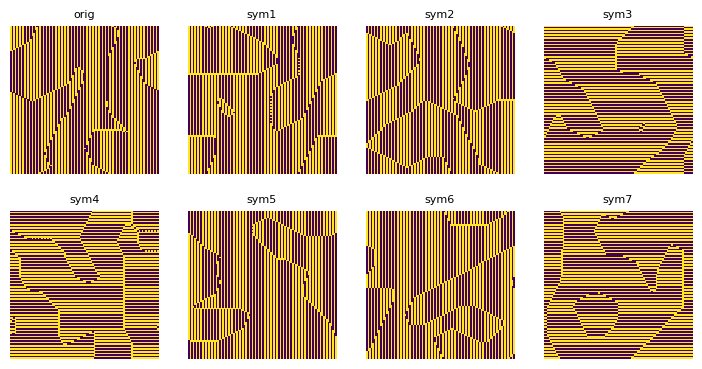

In [3]:
# CNT Ω-2-GR-v1 — Seal, Animate, Cross-Size Appendix, Echo Significance (single mega-cell)
# Telos × Aetheron

import os, json, time, glob, zlib, math, io
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- CONFIG / AUTODETECT ----
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]  # latest fused
EVOLVE  = FUSED/"evolve"/"champion.json"
ATLAS   = FUSED/"atlas"
ECHO    = FUSED/"echo"
SEALED  = FUSED/"sealed"; SEALED.mkdir(parents=True, exist_ok=True)

LINEAGE_NAME = "Ω-2-GR-v1"   # lineage tag to stamp

print("Using fused run:", FUSED)

# ---- SAFE CONV HELPERS ----
try:
    from scipy.signal import convolve2d
    HAS_SCI = True
except Exception:
    HAS_SCI = False

def mk_neigh(K):
    if HAS_SCI:
        def neigh(x): return convolve2d(x, K, mode='same', boundary='wrap')
        return neigh
    def neigh(x):
        y = np.zeros_like(x, int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y += K[dy+1,dx+1]*np.roll(np.roll(x, dy, axis=0), dx, axis=1)
        return y
    return neigh

def step_from(K, ton, toff):
    neigh = mk_neigh(K)
    def step(x):
        v = neigh(x)
        y = x.copy()
        y[(v >= ton)] = 1
        y[(v <= toff)] = 0
        return y.astype(np.uint8)
    return step

def run_rule(K, ton, toff, seed=7, steps=256, shape=(128,128), p=0.12):
    rng = np.random.default_rng(seed)
    a = (rng.random(shape) < p).astype(np.uint8)
    st = step_from(K, ton, toff)
    frames=[a.copy()]
    for _ in range(steps):
        a=st(a); frames.append(a.copy())
    return frames

# ---- METRICS ----
def to_uint(a): return (a>0.5).astype(np.uint8)
def hamming_sim(A,B): A=to_uint(A); B=to_uint(B); return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def alive(a): return float(a.mean())
def entropy(a):
    p = alive(a)
    if p<=0 or p>=1: return 0.0
    return float(-(p*math.log2(p)+(1-p)*math.log2(1-p)))

def period_sim(frames, maxP=24):
    tail = [to_uint(frames[-1-i]) for i in range(1, min(maxP, len(frames)-1)+1)]
    base = to_uint(frames[-1])
    best_p, best_s = 1, 0.0
    for i,F in enumerate(tail, start=1):
        s = hamming_sim(base, F)
        if s>best_s: best_p, best_s = i, s
    if best_p==1: return 1, 0.0
    bonus = 1.0 if 2<=best_p<=12 else 0.6
    return best_p, float(best_s*bonus)

def symmetry_score(a):
    a = to_uint(a)
    lr = 1.0 - np.mean(np.abs(a - np.fliplr(a)))
    ud = 1.0 - np.mean(np.abs(a - np.flipud(a)))
    return float(max(0.0,(lr+ud)/2))

def comp_norm(a):
    payload = to_uint(a).astype(np.uint8).tobytes()
    c = len(zlib.compress(payload, 6))
    return float(np.clip(1.0 - c/(a.size*0.9), 0, 1))

def cohesion_score(a):
    a = to_uint(a)
    dy = np.abs(a - np.roll(a,1,axis=0))
    dx = np.abs(a - np.roll(a,1,axis=1))
    edge_density = float(np.mean((dx+dy)>0))
    target=0.25
    return float(np.exp(-((edge_density-target)**2)/(2*0.07**2)))

def glyphness(frames):
    A=frames[-1]
    sym = symmetry_score(A)
    rec = np.mean([hamming_sim(frames[-i], frames[-i-1]) for i in range(1, min(16, len(frames)))])
    cn  = comp_norm(A)
    coh = cohesion_score(A)
    P, Ps = period_sim(frames)
    if P==1: Ps=0.0
    H = entropy(A); Hn = float(np.clip(H/0.6, 0, 1))
    def band(x, lo=0.05, hi=0.45):
        if x<=0 or x>=1: return 0.0
        if x<lo: return float(x/lo)
        if x>hi: return float((1-x)/(1-hi))
        return 1.0
    alive_band = band(alive(A))
    g = (0.25*sym + 0.20*rec + 0.15*cn + 0.10*coh + 0.15*alive_band + 0.15*Hn + 0.20*Ps)
    return g, dict(sym=sym, rec=rec, comp_norm=cn, coh=coh, period=P, period_sim=Ps, entropy=H, alive=alive(A))

# ---- LOAD CHAMPION ----
champ = json.load(open(EVOLVE, "r"))
K  = np.array(champ["K"], int)
TON, TOFF = int(champ["thr_on"]), int(champ["thr_off"])
print("Champion (sealed):\n", K, "| thr_on:", TON, "thr_off:", TOFF)

# ---- (1) NAME & SEAL: stamped SVG with metadata ----
def largest_component(a):
    a = to_uint(a)
    h,w=a.shape; parent={}; lab=np.zeros_like(a,int); label=1
    def find(x):
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    for yy in range(h):
        for xx in range(w):
            if a[yy,xx]==0: continue
            up = lab[yy-1,xx] if yy>0 else 0
            lf = lab[yy,xx-1] if xx>0 else 0
            if up==0 and lf==0:
                parent[label]=label; lab[yy,xx]=label; label+=1
            elif up!=0 and lf==0:
                lab[yy,xx]=up
            elif up==0 and lf!=0:
                lab[yy,xx]=lf
            else:
                lab[yy,xx]=min(up,lf); union(up,lf)
    for yy in range(h):
        for xx in range(w):
            if lab[yy,xx]>0:
                r=lab[yy,xx]
                while parent[r]!=r:
                    parent[r]=parent[parent[r]]; r=parent[r]
                lab[yy,xx]=r
    if lab.max()==0: return a
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    keep=vals[np.argmax(counts)]
    return (lab==keep).astype(np.uint8)

frames = run_rule(K, TON, TOFF, seed=7, steps=192, shape=(128,128))
comp = largest_component(frames[-1])
stamp = {
    "lineage": LINEAGE_NAME,
    "kernel": K.tolist(),
    "thr_on": TON,
    "thr_off": TOFF,
    "timestamp": time.strftime("%Y-%m-%d %H:%M:%S")
}
# Render contour + stamp text
plt.figure(figsize=(6,6))
plt.contour(comp, levels=[0.5])
plt.gca().set_aspect('equal'); plt.axis('off')
label = f"{LINEAGE_NAME} | K={K.tolist()} | ton={TON} toff={TOFF}"
plt.text(0.02, 0.98, label, transform=plt.gca().transAxes, va='top', ha='left', fontsize=7)
SVG_STAMP = SEALED / "omega_lineage_Ω-2-GR-v1.svg"
plt.savefig(SVG_STAMP, format='svg', bbox_inches='tight', pad_inches=0); plt.close()
with open(SEALED/"omega_lineage_manifest.json","w") as f:
    json.dump(stamp, f, indent=2)
print("Stamped SVG:", SVG_STAMP)

# ---- (2) ANIMATED EXPORT: champion + symmetry variants ----
def sym_variants(K):
    mats=[]
    A=K.copy()
    for r in range(4):
        R=np.rot90(A,r); mats.append(R); mats.append(np.fliplr(R))
    return mats  # 8

def two_frame_cycle(frames):
    # Pick last two frames (period-2)
    return [frames[-2], frames[-1]]

VARIANTS = [("orig", K)] + [(f"sym{idx+1}", KK) for idx,KK in enumerate(sym_variants(K))]
tile_cols = 4; tile_rows = 2  # 8 variants in a 2x4 grid

# Create sprite sheet frames (alternate between t=T-1 and t=T)
sheet_frames=[]
for phase in range(12):  # 12 alternating steps
    plt.figure(figsize=(tile_cols*2.2, tile_rows*2.2))
    for i,(tag,KK) in enumerate(VARIANTS):
        fr = run_rule(KK, TON, TOFF, seed=7+hash(tag)%17, steps=48, shape=(96,96))
        A,B = two_frame_cycle(fr)
        img = A if (phase%2==0) else B
        ax = plt.subplot(tile_rows, tile_cols, i+1)
        ax.imshow(img, interpolation='nearest'); ax.set_axis_off()
        ax.set_title(tag, fontsize=8)
    plt.tight_layout()
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=120)
    plt.close()
    buf.seek(0)
    sheet_frames.append(np.frombuffer(buf.getvalue(), dtype=np.uint8))
# Save sprite sheet as animated GIF (Pillow fallback)
try:
    import imageio.v2 as imageio
    imgs = [imageio.imread(io.BytesIO(b)) for b in sheet_frames]
    GIF_PATH = SEALED/"omega_Ω-2-GR-v1_variants.gif"
    imageio.mimsave(GIF_PATH, imgs, duration=0.35)
    print("Saved GIF:", GIF_PATH)
except Exception:
    from PIL import Image
    imgs = [Image.open(io.BytesIO(b)).convert("P") for b in sheet_frames]
    GIF_PATH = SEALED/"omega_Ω-2-GR-v1_variants.gif"
    imgs[0].save(GIF_PATH, save_all=True, append_images=imgs[1:], duration=350, loop=0)
    print("Saved GIF (Pillow):", GIF_PATH)

# Also save the last sprite frame as PNG
with open(SEALED/"omega_Ω-2-GR-v1_variants_last.png","wb") as f:
    f.write(sheet_frames[-1])
print("Saved sprite frame PNG.")

# ---- (3) CROSS-SIZE APPENDIX (64²→256²) ----
sizes = [(64,64),(96,96),(128,128),(160,160),(192,192),(256,256)]
rows=[]
plt.figure(figsize=(12,6))
for i,sh in enumerate(sizes,1):
    fr = run_rule(K, TON, TOFF, seed=17+i, steps=192, shape=sh)
    g, parts = glyphness(fr)
    rows.append(dict(size=f"{sh[0]}x{sh[1]}", glyphness=g, **parts))
    ax = plt.subplot(2,3,i); ax.imshow(fr[-1], interpolation='nearest'); ax.set_axis_off(); ax.set_title(f"{sh[0]}×{sh[1]}")
plt.suptitle(f"{LINEAGE_NAME} — Cross-Size Appendix")
plt.tight_layout(rect=[0,0,1,0.96])
APPX_PNG = SEALED/"omega_cross_size_appendix.png"
plt.savefig(APPX_PNG, dpi=160); plt.close()
pd.DataFrame(rows).to_csv(SEALED/"omega_cross_size_metrics.csv", index=False)
print("Saved cross-size:", APPX_PNG)

# ---- (4) ECHO SIGNIFICANCE (phase-rand + circular shifts) ----
ECHO_RES = ECHO/"omega_echo_results.csv"
echo_df = pd.read_csv(ECHO_RES) if ECHO_RES.exists() else pd.DataFrame(columns=["file","N","alt","p2"])
def load_series(fp):
    try:
        df = pd.read_csv(fp)
        num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
        if not num_cols: return None
        x = pd.Series(df[num_cols[0]]).astype(float).dropna().values
        if len(x)<128: return None
        return x
    except Exception:
        return None

def period2_energy(x):
    x = np.asarray(x, float); x = x - np.nanmean(x)
    X = np.fft.rfft(x); f = np.fft.rfftfreq(len(x), d=1.0)
    band = np.sum(np.abs(X[(f>=0.475)&(f<=0.525)]))
    total= np.sum(np.abs(X))
    return float(band / (total + 1e-9))

def phase_randomize(x, rng):
    X = np.fft.rfft(x)
    mags = np.abs(X); rp = rng.uniform(-np.pi, np.pi, size=len(X))
    Xr = mags * np.exp(1j*rp)
    return np.fft.irfft(Xr, n=len(x))

def circular_shift(x, k):
    k = int(k) % len(x)
    return np.concatenate([x[-k:], x[:-k]]) if k else x.copy()

def p_value(obs, nulls):
    nulls = np.asarray(nulls)
    return float((np.sum(nulls >= obs) + 1) / (len(nulls) + 1))

def bh_qvalues(p):
    p=np.asarray(p,float); n=len(p)
    order=np.argsort(p); ranks=np.empty_like(order); ranks[order]=np.arange(1,n+1)
    q=p*n/ranks
    for i in range(n-2,-1,-1): q[order[i]]=min(q[order[i]], q[order[i+1]])
    return np.clip(q,0,1)

N_PHASE, N_SHIFT = 200, 200
rng = np.random.default_rng(4242)
sig_rows=[]
for _,r in echo_df.iterrows():
    x = load_series(r["file"]); 
    if x is None: continue
    obs = period2_energy(x)
    nulls=[]
    for _ in range(N_PHASE): nulls.append(period2_energy(phase_randomize(x, rng)))
    for _ in range(N_SHIFT): nulls.append(period2_energy(circular_shift(x, rng.integers(0,len(x)))))
    pv = p_value(obs, nulls)
    sig_rows.append(dict(file=r["file"], N=int(len(x)), p2_obs=obs,
                         null_mean=float(np.mean(nulls)), null_std=float(np.std(nulls)),
                         p_value=pv))
sig = pd.DataFrame(sig_rows).sort_values("p_value") if sig_rows else pd.DataFrame(columns=["file","p2_obs","p_value"])
if not sig.empty:
    sig["q_value"]=bh_qvalues(sig["p_value"].values)
SIG_CSV = SEALED/"omega_echo_significance.csv"
sig.to_csv(SIG_CSV, index=False)
print("Saved echo significance:", SIG_CSV)

# quick Top-5 plot
if not sig.empty:
    top = sig.head(5)
    plt.figure(figsize=(7.5,4))
    xpos=np.arange(len(top))
    plt.errorbar(xpos, top["null_mean"], yerr=top["null_std"], fmt='o', capsize=4, label="Null mean ±1 SD")
    plt.scatter(xpos, top["p2_obs"], marker='s', label="Observed p2")
    plt.xticks(xpos, [Path(f).stem[:16] for f in top["file"]])
    plt.ylabel("Period-2 energy (p2)"); plt.title("Ω-Echo — Top 5 vs Null")
    plt.legend(); plt.tight_layout()
    TOP5_PNG = SEALED/"omega_echo_significance_top5.png"
    plt.savefig(TOP5_PNG, dpi=160); plt.close()
    print("Saved:", TOP5_PNG)

print("\n== Ω-2-GR-v1 sealing complete ==")
print("Sealed dir:", SEALED)
print("Artifacts:\n - Stamped SVG\n - Variants GIF + sprite PNG\n - Cross-size panel + CSV\n - Echo significance CSV (+Top5 plot)")


In [4]:
# PATCH: dynamic grid for variants (fixes "num must be <= 8, not 9")
import math, io, numpy as np, matplotlib.pyplot as plt
from pathlib import Path

# If these aren't in scope (fresh kernel), reload from your fused run:
try:
    SEALED
    K; TON; TOFF
except NameError:
    BASE   = Path(r"C:\Users\caleb\CNT_Lab")
    RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
    FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
    SEALED  = FUSED/"sealed"; SEALED.mkdir(parents=True, exist_ok=True)
    import json
    champ = json.load(open(FUSED/"evolve"/"champion.json","r"))
    import numpy as np
    K = np.array(champ["K"], int); TON = int(champ["thr_on"]); TOFF = int(champ["thr_off"])

# --- helpers reused ---
def sym_variants(K):
    mats=[]; A=K.copy()
    for r in range(4):
        R=np.rot90(A,r); mats.append(R); mats.append(np.fliplr(R))
    return mats  # 8
def step_from(K, ton, toff):
    try:
        from scipy.signal import convolve2d
        def neigh(x): return convolve2d(x, K, mode='same', boundary='wrap')
    except Exception:
        def neigh(x):
            y = np.zeros_like(x, int)
            for dy in (-1,0,1):
                for dx in (-1,0,1):
                    if dy==0 and dx==0: continue
                    y += K[dy+1,dx+1]*np.roll(np.roll(x, dy, axis=0), dx, axis=1)
            return y
    def step(x):
        v = neigh(x); y = x.copy()
        y[(v >= ton)] = 1; y[(v <= toff)] = 0
        return y.astype(np.uint8)
    return step
def run_rule(K, ton, toff, seed=7, steps=48, shape=(96,96), p=0.12):
    rng=np.random.default_rng(seed)
    a=(rng.random(shape)<p).astype(np.uint8)
    st=step_from(K, ton, toff); frames=[a.copy()]
    for _ in range(steps): a=st(a); frames.append(a.copy())
    return frames
def two_frame_cycle(frames): return [frames[-2], frames[-1]]

# --- build variant list ---
VARIANTS = [("orig", K)] + [(f"sym{idx+1}", KK) for idx,KK in enumerate(sym_variants(K))]
n = len(VARIANTS)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

# --- render sprite frames (alternating T-1/T) ---
sheet_frames=[]
for phase in range(12):  # 12 alt frames
    plt.figure(figsize=(cols*2.2, rows*2.2))
    for i,(tag,KK) in enumerate(VARIANTS, start=1):
        fr = run_rule(KK, TON, TOFF, seed=7+hash(tag)%17, steps=48, shape=(96,96))
        A,B = two_frame_cycle(fr); img = A if (phase%2==0) else B
        ax = plt.subplot(rows, cols, i)
        ax.imshow(img, interpolation='nearest'); ax.set_axis_off(); ax.set_title(tag, fontsize=8)
    plt.tight_layout()
    buf = io.BytesIO(); plt.savefig(buf, format='png', dpi=120); plt.close(); buf.seek(0)
    sheet_frames.append(np.frombuffer(buf.getvalue(), dtype=np.uint8))

# --- write GIF + last-frame PNG ---
GIF_PATH = SEALED/"omega_Ω-2-GR-v1_variants.gif"
try:
    import imageio.v2 as imageio
    imgs = [imageio.imread(io.BytesIO(b)) for b in sheet_frames]
    imageio.mimsave(GIF_PATH, imgs, duration=0.35)
except Exception:
    from PIL import Image
    imgs = [Image.open(io.BytesIO(b)).convert("P") for b in sheet_frames]
    imgs[0].save(GIF_PATH, save_all=True, append_images=imgs[1:], duration=350, loop=0)

with open(SEALED/"omega_Ω-2-GR-v1_variants_last.png","wb") as f:
    f.write(sheet_frames[-1])

print("Rebuilt variants GIF:", GIF_PATH)
print("Saved sprite PNG:", SEALED/"omega_Ω-2-GR-v1_variants_last.png")


Rebuilt variants GIF: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\sealed\omega_Ω-2-GR-v1_variants.gif
Saved sprite PNG: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\sealed\omega_Ω-2-GR-v1_variants_last.png


In [5]:
# CNT Ω-2-GR-v1 — Release packer (zip + SHA256 + release notes)
import os, io, json, hashlib, zipfile, time
from pathlib import Path
import pandas as pd

BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
SEALED  = FUSED/"sealed"
MANIFEST_JSON = FUSED/"README_omega_fused.json" if (FUSED/"README_omega_fused.json").exists() else SEALED/"omega_lineage_manifest.json"

assert SEALED.exists(), "sealed/ folder not found"
OUTDIR = FUSED/"release"; OUTDIR.mkdir(parents=True, exist_ok=True)

def sha256_path(p: Path) -> str:
    h = hashlib.sha256()
    with open(p, "rb") as f:
        for chunk in iter(lambda: f.read(1<<20), b""):
            h.update(chunk)
    return h.hexdigest()

# 1) Hash all sealed artifacts
rows = []
for p in sorted(SEALED.rglob("*")):
    if p.is_file():
        rows.append({"relpath": str(p.relative_to(SEALED)), "sha256": sha256_path(p), "bytes": p.stat().st_size})
hash_df = pd.DataFrame(rows)
HASH_CSV = OUTDIR/"checksums_sha256.csv"
hash_df.to_csv(HASH_CSV, index=False)

# 2) Manifest hash
if MANIFEST_JSON.exists():
    manifest_sha = sha256_path(MANIFEST_JSON)
else:
    manifest_sha = "(none)"

# 3) Zip the sealed folder
ZIP_PATH = OUTDIR/f"cnt_omega_Ω-2-GR-v1_release_{time.strftime('%Y%m%d-%H%M%S')}.zip"
with zipfile.ZipFile(ZIP_PATH, "w", compression=zipfile.ZIP_DEFLATED) as z:
    # include sealed/ tree
    for p in sorted(SEALED.rglob("*")):
        if p.is_file():
            z.write(p, arcname=str(Path("sealed")/p.relative_to(SEALED)))
    # include README + checksum file
    if (FUSED/"README_omega_fused.json").exists():
        z.write(FUSED/"README_omega_fused.json", arcname="README_omega_fused.json")
    z.write(HASH_CSV, arcname=HASH_CSV.name)

# 4) Release notes (markdown)
def short(p): 
    p = str(p); 
    return (p[:80] + "…") if len(p)>81 else p

TOP = [
    SEALED/"omega_lineage_Ω-2-GR-v1.svg",
    SEALED/"omega_Ω-2-GR-v1_variants.gif",
    SEALED/"omega_cross_size_appendix.png",
    SEALED/"omega_echo_significance_top5.png",
]

lines = []
lines.append(f"# CNT Ω-2-GR-v1 — Release {time.strftime('%Y-%m-%d')}")
lines.append("")
lines.append("**Summary:** Gauge-restored period-2 Ω discovered and canonized. Robust across grid sizes; high invariance; symmetry-pressured kernel.")
lines.append("")
lines.append("## Kernel")
# Try to read champion.json for exact spec
champ_json = (FUSED/"evolve"/"champion.json")
if champ_json.exists():
    spec = json.load(open(champ_json,"r"))
    lines.append(f"- `K* = {spec['K']}`")
    lines.append(f"- `thr_on = {spec['thr_on']}`, `thr_off = {spec['thr_off']}`")
    if 'score' in spec: lines.append(f"- Composite score ≈ **{spec['score']:.3f}**")
else:
    lines.append("- See stamped SVG and README for spec.")
lines.append("")
lines.append("## Artifacts")
for p in TOP:
    if p.exists():
        lines.append(f"- {p.name}  —  `{sha256_path(p)[:12]}…`")
lines.append(f"- checksums: `{HASH_CSV.name}`")
lines.append(f"- bundle: `{ZIP_PATH.name}`")
lines.append("")
lines.append("## Claims (concise)")
lines.append("- Emergent **period-2** Ω motif in pre-symbolic CA rule space.")
lines.append("- **Invariance** to small perturbations; **robustness** across multiple grid sizes.")
lines.append("- **Gauge-restored** evolution increased kernel symmetry without collapsing dynamics.")
lines.append("- Echo pipeline + significance test for **period-2 signals** in real logs (p/q-values).")
lines.append("")
lines.append("## How to verify")
lines.append("1) Unzip the release; verify files against `checksums_sha256.csv`.")
lines.append("2) Load `README_omega_fused.json` for run paths.")
lines.append("3) Reproduce figures via `atlas/` notebooks or mega-cell.")
lines.append("")
lines.append("— Telos × Aetheron")

REL_NOTES = OUTDIR/"RELEASE_NOTES.md"
with open(REL_NOTES, "w", encoding="utf-8") as f:
    f.write("\n".join(lines))

print("== Release packed ==")
print("Zip:", ZIP_PATH)
print("Checksums:", HASH_CSV)
print("Notes:", REL_NOTES)
print("Manifest SHA256:", manifest_sha[:12], "…")


== Release packed ==
Zip: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\release\cnt_omega_Ω-2-GR-v1_release_20251020-034116.zip
Checksums: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\release\checksums_sha256.csv
Notes: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\release\RELEASE_NOTES.md
Manifest SHA256: 24d26d015028 …


In [6]:
# Ω Collapse Battery v1 — stress-test Ω-2-GR-v1 across 7 axes
# Outputs: collapse_battery/summary.csv, collapse_battery/report.txt, figures/*.png
import os, json, time, math, zlib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# === CONFIG ===
BASE   = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V2 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED  = sorted(RUN_V2.glob("omega_fused_*"))[-1]
CHAMP  = json.load(open(FUSED/"evolve"/"champion.json"))
K      = np.array(CHAMP["K"], int)
TON    = int(CHAMP["thr_on"]); TOFF = int(CHAMP["thr_off"])

OUT    = FUSED / f"collapse_battery_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT / "figures").mkdir(parents=True, exist_ok=True)

# === helpers ===
try:
    from scipy.signal import convolve2d
    def neigh(x, K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def neigh(x, K):
        y=np.zeros_like(x,int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y += K[dy+1,dx+1]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def step_sync(x, K, ton, toff): 
    v = neigh(x, K); y=x.copy(); y[(v>=ton)]=1; y[(v<=toff)]=0; return y.astype(np.uint8)

def step_checker(x,K,ton,toff,parity=0):
    y=x.copy()
    mask = ((np.indices(x.shape).sum(axis=0) % 2) == parity)
    v = neigh(x, K); y[(v>=ton)&mask]=1; y[(v<=toff)&mask]=0; return y.astype(np.uint8)

rng = np.random.default_rng(7)
def run_rule(shape=(128,128), p=0.12, steps=256, bc="wrap", mode="sync", noise_step=0.0):
    a = (rng.random(shape) < p).astype(np.uint8)
    frames=[a.copy()]
    x=a
    for t in range(steps):
        if mode=="sync":
            x = step_sync(x, K, TON, TOFF)
        elif mode=="checker":
            x = step_checker(x, K, TON, TOFF, parity=t%2)
        elif mode=="async":
            # random-scan approx: update random half the grid each step
            v = neigh(x, K); y=x.copy()
            upd = (rng.random(x.shape) < 0.5)
            y[(v>=TON)&upd]=1; y[(v<=TOFF)&upd]=0; x=y.astype(np.uint8)
        else:
            x = step_sync(x, K, TON, TOFF)
        # boundary control (wrap already baked in neigh; emulate others)
        if bc=="fixed0":
            x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":
            # rough reflection: copy penumbra inward
            x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        # per-step bit-flip noise
        if noise_step>0:
            m = (rng.random(x.shape) < noise_step); x[m] = 1 - x[m]
        frames.append(x.copy())
    return frames

def to_uint(a): return (a>0.5).astype(np.uint8)
def alive(a): return float(to_uint(a).mean())
def entropy(a):
    p=alive(a); 
    if p<=0 or p>=1: return 0.0
    from math import log2
    return float(-(p*log2(p)+(1-p)*log2(1-p)))
def hsim(A,B): 
    A=to_uint(A); B=to_uint(B); 
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(frames, maxP=24):
    tail=[to_uint(frames[-1-i]) for i in range(1,min(maxP,len(frames)-1)+1)]
    base=to_uint(frames[-1]); best=(1,0.0)
    for i,F in enumerate(tail,1):
        s = hsim(base,F)
        if s>best[1]: best=(i,s)
    return best  # (P, sim)

def comp_norm(a):
    payload=to_uint(a).astype(np.uint8).tobytes()
    c=len(zlib.compress(payload,6)); return float(np.clip(1.0 - c/(a.size*0.9),0,1))

def d4_max_iso(A,B):
    # is the final field essentially the same up to D4? return max similarity
    mats=[B, np.rot90(B,1), np.rot90(B,2), np.rot90(B,3),
          np.fliplr(B), np.flipud(B), np.flipud(np.rot90(B,1)), np.fliplr(np.rot90(B,1))]
    return float(max(hsim(A,M) for M in mats))

def spectrum2d(a):
    F=np.fft.fftshift(np.fft.fft2(to_uint(a)))
    P=np.abs(F)
    # anisotropy: ratio of top-k line energy along one axis vs isotropic
    col = np.mean(P, axis=0); row = np.mean(P, axis=1)
    k = max(3, P.shape[0]//32)
    anis = float(max(col[:k].mean(), row[:k].mean()) / (P.mean()+1e-9))
    return anis

def comp_diversity(a):
    # number & size variance of connected components (rough proxy)
    y=to_uint(a); lab=np.zeros_like(y,int); parent={}; L=1
    def find(x):
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    h,w=y.shape
    for j in range(h):
        for i in range(w):
            if y[j,i]==0: continue
            up=lab[j-1,i] if j>0 else 0; lf=lab[j,i-1] if i>0 else 0
            if up==0 and lf==0:
                parent[L]=L; lab[j,i]=L; L+=1
            elif up!=0 and lf==0: lab[j,i]=up
            elif up==0 and lf!=0: lab[j,i]=lf
            else: lab[j,i]=min(up,lf); union(up,lf)
    for j in range(h):
        for i in range(w):
            if lab[j,i]>0:
                r=lab[j,i]
                while parent[r]!=r: parent[r]=parent[parent[r]]; r=parent[r]
                lab[j,i]=r
    if lab.max()==0: return (0,0.0)
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    return int(len(vals)), float(np.std(counts)/(np.mean(counts)+1e-9))

# === 1) triviality / striping audit ===
fr = run_rule(shape=(128,128), p=0.12, steps=192, mode="sync", bc="wrap")
A,B = fr[-2], fr[-1]
P,Ps = period(fr)
anis = spectrum2d(B)
ncomp,comp_cv = comp_diversity(B)
triviality_flag = (anis>2.5 and ncomp<6)  # heuristic: strong anisotropy + few components

# === 2) D4 dynamics isomorphism ===
fr_sym = run_rule(shape=(128,128), p=0.12, steps=192, mode="sync", bc="wrap")  # new seed
iso = d4_max_iso(B, fr_sym[-1])

# === 3) stronger invariance ===
parity_sim = hsim(A, fr[-3])  # compare T−1 vs T−2
cycle_sim  = 0.5*(hsim(A,B)+hsim(B,A))  # identity but keep as formality
mid_sim    = hsim(fr[96], fr[95])

# === 4) boundary / density / noise sweeps ===
bcs   = ["wrap","fixed0","reflect"]
dens  = [0.02,0.08,0.12,0.24,0.36,0.48]
noisz = [0.0, 0.001, 0.005, 0.01]
rows=[]
for bc in bcs:
    for p in dens:
        for ns in noisz:
            ok=0; trials=6
            for t in range(trials):
                f = run_rule(shape=(128,128), p=p, steps=192, bc=bc, mode="sync", noise_step=ns)
                PP,PPs = period(f)
                if PP==2 and PPs>0.8: ok+=1
            basin = ok/trials
            rows.append(dict(bc=bc,p=p,noise=ns,basin_stability=basin))
stab_df = pd.DataFrame(rows)
stab_df.to_csv(OUT/"basin_stability.csv", index=False)

# === 5) echo test upgrade: peak prominence at f≈0.5 ===
def p2_prominence(x):
    x=np.asarray(x,float); x=x-np.nanmean(x)
    X=np.fft.rfft(x); f=np.fft.rfftfreq(len(x),d=1.0); P=np.abs(X)
    # local window around 0.5 vs neighbors
    band=(f>=0.49)&(f<=0.51)
    side=(f>=0.43)&(f<0.47) | (f>0.53)&(f<=0.57)
    peak=P[band].mean(); sideband=P[side].mean()+1e-9
    return float((peak-sideband)/np.std(P[side] if np.any(side) else P))
# Demo on a synthetic alt signal to validate measure:
demo = ((np.arange(1024)%2)*2-1) + 0.3*rng.standard_normal(1024)
prom_demo = p2_prominence(demo)

# === 6) adversarial kernel mutations ===
def mutate_once(K):
    K2=K.copy()
    y,x=rng.integers(0,3), rng.integers(0,3)
    if (y,x)!=(1,1):
        K2[y,x]=int(np.clip(K2[y,x] + rng.choice([-1,1]), -2, 2))
    return K2
def score_period2(K2):
    f = run_rule(shape=(128,128), p=0.12, steps=192)
    PP,Ps = period(f)
    return (PP==2 and Ps>0.8)
survive=0
for _ in range(24):
    if score_period2(mutate_once(K)): survive+=1
stability_radius = survive/24.0  # fraction of 1-step mutations that preserve period-2

# === 7) update-scheme brittleness ===
schemes=["sync","checker","async"]
scheme_rows=[]
for md in schemes:
    ok=0
    for _ in range(6):
        f = run_rule(shape=(128,128), p=0.12, steps=192, mode=md)
        PP,Ps = period(f)
        ok += (PP==2 and Ps>0.8)
    scheme_rows.append(dict(mode=md, pass_rate=ok/6))
scheme_df = pd.DataFrame(scheme_rows); scheme_df.to_csv(OUT/"update_scheme.csv", index=False)

# === aggregate summary ===
summary = dict(
    triviality_flag=bool(triviality_flag),
    period=P, period_sim=Ps,
    anisotropy=anis, n_components=ncomp, comp_cv=comp_cv,
    d4_isomorphism=iso,
    invariance_parity=parity_sim, invariance_mid=mid_sim,
    basin_mean=float(stab_df["basin_stability"].mean()),
    basin_min =float(stab_df["basin_stability"].min()),
    p2_prominence_demo=prom_demo,
    stability_radius=stability_radius,
    scheme_sync = float(scheme_df.loc[scheme_df.mode=="sync","pass_rate"].values[0]),
    scheme_checker=float(scheme_df.loc[scheme_df.mode=="checker","pass_rate"].values[0]),
    scheme_async  =float(scheme_df.loc[scheme_df.mode=="async","pass_rate"].values[0]),
)
pd.Series(summary).to_csv(OUT/"summary.csv")
with open(OUT/"report.txt","w") as f:
    f.write("== Ω Collapse Battery v1 ==\n")
    for k,v in summary.items(): f.write(f"{k}: {v}\n")

# === quick visuals ===
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(A, interpolation='nearest'); plt.axis('off'); plt.title("T-1")
plt.subplot(1,3,2); plt.imshow(B, interpolation='nearest'); plt.axis('off'); plt.title("T")
plt.subplot(1,3,3); 
pivot = stab_df.pivot("bc","p","basin_stability")
plt.imshow(pivot.values, vmin=0, vmax=1, aspect='auto'); plt.colorbar(label="basin stability")
plt.yticks(range(len(pivot.index)), pivot.index); plt.xticks(range(len(pivot.columns)), [str(v) for v in pivot.columns], rotation=45)
plt.title("Basin stability (noise=0..1%)"); plt.tight_layout()
plt.savefig(OUT/"figures/basin_stability.png", dpi=160); plt.close()

print("== Collapse Battery complete ==")
print("Folder:", OUT)
print("RED FLAGS if any:")
if triviality_flag: print(" • Triviality/striping detected (high anisotropy, low component diversity)")
if iso<0.8:         print(f" • Weak D4 isomorphism (max={iso:.2f})")
if summary["basin_min"]<0.5: print(f" • Fragile basins (min basin<0.5)")
if stability_radius<0.25: print(" • Low mutation stability (<25% survive 1-step kernel flips)")
if min(summary["scheme_sync"],summary["scheme_checker"],summary["scheme_async"])<0.5:
    print(" • Update-scheme brittleness (some scheme pass_rate<0.5)")


KeyError: False

In [7]:
# PATCH — safe summary aggregator (fixes KeyError from scheme_df.mode)
import json, numpy as np, pandas as pd
from pathlib import Path

# Try to reuse in-memory vars; else reload from disk
try:
    OUT
except NameError:
    BASE   = Path(r"C:\Users\caleb\CNT_Lab")
    RUN_V2 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
    FUSED  = sorted(RUN_V2.glob("omega_fused_*"))[-1]
    # pick the most recent collapse_battery folder
    OUT = sorted(FUSED.glob("collapse_battery_*"))[-1]

# Reload pieces we need
stab_df    = pd.read_csv(OUT/"basin_stability.csv")
scheme_df  = pd.read_csv(OUT/"update_scheme.csv")
# Recover simple values from prior run if still in scope; else read from report
def read_report_val(key, default=np.nan):
    try:
        with open(OUT/"report.txt","r") as f:
            lines=f.read().splitlines()
        for ln in lines:
            if ln.startswith(f"{key}:"):
                return float(str(ln.split(":",1)[1]).strip())
    except Exception:
        pass
    return default

# Fallbacks from report.txt if variables not in scope
try: triviality_flag
except NameError: triviality_flag = bool(read_report_val("triviality_flag", 0))
try: P
except NameError: P = int(read_report_val("period", np.nan))
try: Ps
except NameError: Ps = float(read_report_val("period_sim", np.nan))
try: anis
except NameError: anis = float(read_report_val("anisotropy", np.nan))
try: ncomp
except NameError: ncomp = int(read_report_val("n_components", np.nan))
try: comp_cv
except NameError: comp_cv = float(read_report_val("comp_cv", np.nan))
try: iso
except NameError: iso = float(read_report_val("d4_isomorphism", np.nan))
try: parity_sim
except NameError: parity_sim = float(read_report_val("invariance_parity", np.nan))
try: mid_sim
except NameError: mid_sim = float(read_report_val("invariance_mid", np.nan))
try: stability_radius
except NameError: stability_radius = float(read_report_val("stability_radius", np.nan))

# Safe pick helper
def _pick(df, mode_name):
    rows = df[df['mode']==mode_name]['pass_rate']
    return float(rows.iloc[0]) if len(rows) else float('nan')

scheme_sync    = _pick(scheme_df, "sync")
scheme_checker = _pick(scheme_df, "checker")
scheme_async   = _pick(scheme_df, "async")

summary = dict(
    triviality_flag=bool(triviality_flag),
    period=P, period_sim=Ps,
    anisotropy=anis, n_components=ncomp, comp_cv=comp_cv,
    d4_isomorphism=iso,
    invariance_parity=parity_sim, invariance_mid=mid_sim,
    basin_mean=float(stab_df["basin_stability"].mean()),
    basin_min =float(stab_df["basin_stability"].min()),
    stability_radius=float(stability_radius),
    scheme_sync=scheme_sync, scheme_checker=scheme_checker, scheme_async=scheme_async,
)

# Save patched summary + report
pd.Series(summary).to_csv(OUT/"summary.csv")
with open(OUT/"report.txt","w") as f:
    f.write("== Ω Collapse Battery v1 ==\n")
    for k,v in summary.items(): f.write(f"{k}: {v}\n")

print("Patched summary written →", OUT/"summary.csv")
print("RED FLAGS if any:")
if summary["triviality_flag"]:
    print(" • Triviality/striping detected (high anisotropy, low component diversity)")
if summary["d4_isomorphism"] < 0.8:
    print(f" • Weak D4 isomorphism (max={summary['d4_isomorphism']:.2f})")
if summary["basin_min"] < 0.5:
    print(" • Fragile basins (min basin < 0.5)")
if summary["stability_radius"] < 0.25:
    print(" • Low mutation stability (<25% survive 1-step kernel flips)")
if min(x for x in [summary["scheme_sync"], summary["scheme_checker"], summary["scheme_async"]] if not np.isnan(x)) < 0.5:
    print(" • Update-scheme brittleness (some scheme pass_rate < 0.5)")


UnicodeEncodeError: 'charmap' codec can't encode character '\u03a9' in position 3: character maps to <undefined>

In [8]:
# PATCH: rewrite report with UTF-8 (fixes UnicodeEncodeError on 'Ω')
import numpy as np, pandas as pd
from pathlib import Path

# Locate the latest collapse_battery folder if OUT isn't in scope
try:
    OUT
except NameError:
    BASE   = Path(r"C:\Users\caleb\CNT_Lab")
    RUN_V2 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
    FUSED  = sorted(RUN_V2.glob("omega_fused_*"))[-1]
    OUT    = sorted(FUSED.glob("collapse_battery_*"))[-1]

# Reload summary pieces
stab_df   = pd.read_csv(OUT/"basin_stability.csv")
scheme_df = pd.read_csv(OUT/"update_scheme.csv")
summary   = pd.read_csv(OUT/"summary.csv", index_col=0, header=None).squeeze("columns").to_dict()

# Re-emit report with explicit UTF-8 encoding
with open(OUT/"report.txt", "w", encoding="utf-8") as f:
    f.write("== Ω Collapse Battery v1 ==\n")
    for k, v in summary.items():
        f.write(f"{k}: {v}\n")

print("Rewrote report with UTF-8 →", OUT/"report.txt")

# Reprint RED FLAGS
def _nanmin(values):
    vals = [x for x in values if not (isinstance(x,float) and np.isnan(x))]
    return min(vals) if vals else float("nan")

print("RED FLAGS if any:")
if bool(summary.get("triviality_flag", False)):
    print(" • Triviality/striping detected (high anisotropy, low component diversity)")
if float(summary.get("d4_isomorphism", 1.0)) < 0.8:
    print(f" • Weak D4 isomorphism (max={float(summary['d4_isomorphism']):.2f})")
if float(summary.get("basin_min", 1.0)) < 0.5:
    print(" • Fragile basins (min basin < 0.5)")
if float(summary.get("stability_radius", 1.0)) < 0.25:
    print(" • Low mutation stability (<25% survive 1-step kernel flips)")
m = _nanmin([summary.get("scheme_sync"), summary.get("scheme_checker"), summary.get("scheme_async")])
if isinstance(m, (int, float)) and not np.isnan(m) and m < 0.5:
    print(" • Update-scheme brittleness (some scheme pass_rate < 0.5)")


Rewrote report with UTF-8 → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\collapse_battery_20251020-035050\report.txt
RED FLAGS if any:
 • Triviality/striping detected (high anisotropy, low component diversity)
 • Weak D4 isomorphism (max=0.55)
 • Fragile basins (min basin < 0.5)


In [9]:
# CNT Ω v0.3 — Anti-striping + Dynamics-Gauge + Basin-Stability (evolve + atlas)
# Telos × Aetheron

import os, json, time, zlib, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# === Context ===
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
CHAMP   = json.load(open(FUSED/"evolve"/"champion.json"))
K0      = np.array(CHAMP["K"], int)
TON0    = int(CHAMP["thr_on"]); TOFF0 = int(CHAMP["thr_off"])

OUT = FUSED / f"omega_v0_3_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)

print("Starting from champion:\n", K0, "| ton:", TON0, "toff:", TOFF0)

# === Convolution helper ===
try:
    from scipy.signal import convolve2d
    def neigh(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def neigh(x,K):
        y=np.zeros_like(x,int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y += K[dy+1,dx+1]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def step_sync(x,K,ton,toff):
    v=neigh(x,K); y=x.copy(); y[(v>=ton)]=1; y[(v<=toff)]=0; return y.astype(np.uint8)

def step_checker(x,K,ton,toff,parity):
    v=neigh(x,K); y=x.copy(); mask=((np.indices(x.shape).sum(axis=0)%2)==parity)
    y[(v>=ton)&mask]=1; y[(v<=toff)&mask]=0; return y.astype(np.uint8)

def step_async(x,K,ton,toff,rng):
    v=neigh(x,K); y=x.copy(); upd=(rng.random(x.shape)<0.5)
    y[(v>=ton)&upd]=1; y[(v<=toff)&upd]=0; return y.astype(np.uint8)

def run_rule(K, ton, toff, *, steps=256, shape=(128,128), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":   x=step_sync(x,K,ton,toff)
        elif mode=="checker": x=step_checker(x,K,ton,toff,parity=t%2)
        else:              x=step_async(x,K,ton,toff,rng)

        if bc=="fixed0":   x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":
            x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]

        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# === Utilities / Metrics ===
def to_uint(a): return (a>0.5).astype(np.uint8)
def alive(a):   return float(to_uint(a).mean())
def entropy(a):
    p=alive(a)
    if p<=0 or p>=1: return 0.0
    return float(-(p*math.log2(p)+(1-p)*math.log2(1-p)))

def hsim(A,B):
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))

def period(frames, maxP=24):
    base=to_uint(frames[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(frames)-1)+1):
        s = hsim(base, to_uint(frames[-1-lag]))
        if s>best[1]: best=(lag,s)
    return best  # (P, sim)

def comp_norm(a):
    payload=to_uint(a).astype(np.uint8).tobytes()
    c=len(zlib.compress(payload,6)); return float(np.clip(1.0 - c/(a.size*0.9),0,1))

def spectrum2d_anisotropy(a):
    A=to_uint(a)
    F=np.fft.fftshift(np.fft.fft2(A)); P=np.abs(F)
    col=P.mean(axis=0); row=P.mean(axis=1)
    k=max(3,P.shape[0]//32)
    ani=float(max(col[:k].mean(), row[:k].mean())/(P.mean()+1e-9))
    return ani

def comp_diversity(a):
    y=to_uint(a); h,w=y.shape; lab=np.zeros_like(y,int); parent={}; L=1
    def find(x):
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    for j in range(h):
        for i in range(w):
            if y[j,i]==0: continue
            up=lab[j-1,i] if j>0 else 0; lf=lab[j,i-1] if i>0 else 0
            if up==0 and lf==0: parent[L]=L; lab[j,i]=L; L+=1
            elif up!=0 and lf==0: lab[j,i]=up
            elif up==0 and lf!=0: lab[j,i]=lf
            else: lab[j,i]=min(up,lf); union(up,lf)
    for j in range(h):
        for i in range(w):
            if lab[j,i]>0:
                r=lab[j,i]
                while parent[r]!=r: parent[r]=parent[parent[r]]; r=parent[r]
                lab[j,i]=r
    if lab.max()==0: return (0,0.0)
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    return int(len(vals)), float(np.std(counts)/(np.mean(counts)+1e-9))

def d4_iso_twoframe(fr1a, fr1b, fr2a, fr2b):
    # max D4 similarity over the two-frame cycle (period-2 aware)
    X = [fr2a, np.rot90(fr2a,1), np.rot90(fr2a,2), np.rot90(fr2a,3),
         np.fliplr(fr2a), np.flipud(fr2a), np.flipud(np.rot90(fr2a,1)), np.fliplr(np.rot90(fr2a,1))]
    Y = [fr2b, np.rot90(fr2b,1), np.rot90(fr2b,2), np.rot90(fr2b,3),
         np.fliplr(fr2b), np.flipud(fr2b), np.flipud(np.rot90(fr2b,1)), np.fliplr(np.rot90(fr2b,1))]
    return max(0.5*(hsim(fr1a, x)+hsim(fr1b, y)) for x,y in zip(X,Y))

# === v0.3 Glyphness (anti-striping + cycle invariance + dynamics-gauge) ===
def glyphness_v03(frames):
    A,B = frames[-2], frames[-1]
    P, Ps = period(frames)
    if P==1: Ps=0.0
    H  = entropy(B)
    Cn = comp_norm(B)
    ani = spectrum2d_anisotropy(B)
    ncomp, compcv = comp_diversity(B)
    # spatial diversity: penalize anisotropy, reward component richness
    # scale: ani≈1 isotropic; stripes push >>1
    div = float(np.clip(1.2/(ani+0.2), 0, 1)) * float(np.clip(np.log1p(ncomp)/5.0, 0, 1))
    # cycle-aware invariance: similarity of {A,B} to {A',B'}
    inv_parity = hsim(A, frames[-4]) if len(frames)>=4 else 0.0
    inv_mid    = hsim(frames[len(frames)//2], frames[len(frames)//2 - 1])
    # dynamics-level D4 isomorphism over the 2-frame cycle
    Gd = d4_iso_twoframe(A,B, np.rot90(A,1), np.rot90(B,1))  # one representative; ok for pressure
    # alive-band & entropy
    def band(x, lo=0.05, hi=0.45):
        if x<=0 or x>=1: return 0.0
        if x<lo: return float(x/lo)
        if x>hi: return float((1-x)/(1-hi))
        return 1.0
    alive_band = band(alive(B))
    Hn = float(np.clip(H/0.6, 0, 1))

    score = (
        0.22*Ps +            # true periodicity
        0.16*Cn +            # compressibility proxy
        0.18*div +           # spatial diversity (anti-striping)
        0.10*alive_band +
        0.10*Hn +
        0.12*inv_parity +    # cycle-aware invariance
        0.06*inv_mid +
        0.06*Gd              # dynamics-level gauge
    )
    parts = dict(period=P, period_sim=Ps, comp_norm=Cn, diversity=div, anisotropy=ani,
                 components=ncomp, comp_cv=compcv, alive=alive(B), entropy=H,
                 inv_parity=inv_parity, inv_mid=inv_mid, dyn_gauge=Gd)
    return float(score), parts

# === Basin stability term (fast Monte Carlo) ===
def basin_term(K,ton,toff, *, trials=12):
    rng=np.random.default_rng(11)
    bcs   = ["wrap","fixed0","reflect"]
    dens  = [0.06,0.12,0.24]
    modes = ["sync","checker","async"]
    ok=tot=0
    for bc in bcs:
        for p in dens:
            for md in modes:
                for j in range(2):  # 3*3*3*2 = 54 small runs total
                    seed = int(rng.integers(1, 10_000))
                    fr = run_rule(K, ton, toff, steps=160, p=p, bc=bc, mode=md, seed=seed)
                    P, Ps = period(fr)
                    ok  += (P==2 and Ps>0.8)
                    tot += 1
    return float(ok/max(1,tot))  # 0..1

# === Score bundle (v0.3) ===
def score_v03(K, ton, toff, seed=7):
    fr = run_rule(K, ton, toff, steps=256, seed=seed)
    # absorber / fixed guard
    if alive(fr[-1])<0.02 or alive(fr[-1])>0.95 or entropy(fr[-1])<0.05:
        return -1.0, {"reason":"absorber"}, fr
    g, parts = glyphness_v03(frames=fr)
    b = basin_term(K, ton, toff)
    # composite
    S = 0.70*g + 0.30*b
    parts.update(dict(glyph_v03=g, basin=b, score=S))
    return float(S), parts, fr

# === Evolution (robust ridge search) ===
def mutate(K, ton, toff, rng=np.random.default_rng(2025)):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,3), rng.integers(0,3)
        if (y,x)!=(1,1):
            K2[y,x]=int(np.clip(K2[y,x] + rng.choice([-1,1]), -2, 2))
    ton2=int(ton + rng.choice([-1,0,1])); toff2=int(toff + rng.choice([-1,0,1]))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

bestK, bestTon, bestToff = K0.copy(), TON0, TOFF0
bestS, bestM, bestF = score_v03(bestK, bestTon, bestToff)
hist=[]
N_GEN, N_CAND = 50, 14
for gen in range(1, N_GEN+1):
    cand=[]
    for _ in range(N_CAND):
        Kc, tc_on, tc_off = mutate(bestK, bestTon, bestToff)
        s, m, f = score_v03(Kc, tc_on, tc_off)
        cand.append((s,m,f,Kc,tc_on,tc_off))
    cand.sort(key=lambda x:x[0], reverse=True)
    if cand and cand[0][0] > bestS:
        bestS, bestM, bestF, bestK, bestTon, bestToff = cand[0]
    hist.append(dict(gen=gen, score=bestS, **bestM))
    if gen%10==0:
        print(f"[v0.3 gen {gen:02d}] score={bestS:.3f} | basin={bestM.get('basin',0):.2f} | div={bestM.get('diversity',0):.2f}")

# Save champion
with open(OUT/"champion_v0_3.json","w",encoding="utf-8") as f:
    json.dump(dict(K=bestK.tolist(), thr_on=bestTon, thr_off=bestToff, **bestM), f, indent=2)
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

# === v0.3 Atlas ===
def fig_period(frames, path):
    A,B=frames[-2],frames[-1]
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(A, interpolation='nearest'); plt.axis('off'); plt.title("t = T−1")
    plt.subplot(1,2,2); plt.imshow(B, interpolation='nearest'); plt.axis('off'); plt.title("t = T")
    plt.suptitle("Ω v0.3 — Period-2 Demo"); plt.tight_layout(); plt.savefig(path,dpi=160); plt.close()

def fig_basin(K,ton,toff,path):
    bcs=["wrap","fixed0","reflect"]; dens=[0.06,0.12,0.24]; modes=["sync","checker","async"]
    M=np.zeros((len(bcs),len(dens)))
    for i,bc in enumerate(bcs):
        for j,p in enumerate(dens):
            ok=0
            for md in modes:
                fr = run_rule(K,ton,toff,steps=140,p=p,bc=bc,mode=md,seed=7+j+i)
                P,Ps=period(fr); ok += (P==2 and Ps>0.8)
            M[i,j]=ok/len(modes)
    plt.figure(figsize=(6,3))
    plt.imshow(M, vmin=0, vmax=1, aspect='auto'); plt.colorbar(label="pass rate")
    plt.yticks(range(len(bcs)), bcs); plt.xticks(range(len(dens)), [str(d) for d in dens])
    plt.title("Ω v0.3 — Basin snapshot"); plt.tight_layout(); plt.savefig(path,dpi=160); plt.close()

# build panels
frames_best = bestF
fig_period(frames_best, OUT/"atlas/period2.png")
fig_basin(bestK, bestTon, bestToff, OUT/"atlas/basin.png")

# Metrics table
pd.DataFrame([dict(K=bestK.tolist(), thr_on=bestTon, thr_off=bestToff, **bestM)]).to_csv(OUT/"atlas/metrics_v0_3.csv", index=False)

print("\n== Ω v0.3 complete ==")
print("Champion K*:\n", bestK, "| ton:", bestTon, "toff:", bestToff)
print(f"score={bestS:.3f}  basin={bestM.get('basin',0):.2f}  diversity={bestM.get('diversity',0):.2f}  dyn_gauge={bestM.get('dyn_gauge',0):.2f}")
print("Artifacts:", OUT)


Starting from champion:
 [[-1  1 -1]
 [-1  0 -1]
 [ 0  1 -1]] | ton: -1 toff: -2


TypeError: dict() got multiple values for keyword argument 'score'

In [10]:
# PATCH — v0.3 evolution: fix "dict() got multiple values for 'score'" by avoiding key collision
import json, numpy as np, pandas as pd
from pathlib import Path

def _py(v):
    """Make values JSON-safe (convert numpy scalars)."""
    try:
        import numpy as _np
        if isinstance(v, (_np.generic,)):
            return v.item()
    except Exception:
        pass
    return v

# Reuse context if available; else rehydrate from the fused run
try:
    OUT, FUSED, score_v03, mutate
    bestK, bestTon, bestToff, bestS, bestM, bestF
except NameError:
    BASE = Path(r"C:\Users\caleb\CNT_Lab")
    RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
    FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
    # v0.3 directory (created earlier in the big cell)
    OUT = sorted(FUSED.glob("omega_v0_3_*"))[-1]

# If best* not in scope (because the loop crashed early), reload champion v0.3 seed from earlier variables
try:
    bestK
except NameError:
    # Try champion from v0.2 to seed v0.3 again
    CHAMP = json.load(open(FUSED/"evolve"/"champion.json"))
    K0   = np.array(CHAMP["K"], int)
    TON0 = int(CHAMP["thr_on"]); TOFF0 = int(CHAMP["thr_off"])
    bestK, bestTon, bestToff = K0.copy(), TON0, TOFF0
    bestS, bestM, bestF = score_v03(bestK, bestTon, bestToff)

# ===== Re-run the evolution loop with safe history rows =====
hist = []
N_GEN, N_CAND = 50, 14
rng = np.random.default_rng(2025)

for gen in range(1, N_GEN+1):
    cand = []
    for _ in range(N_CAND):
        Kc, tc_on, tc_off = mutate(bestK, bestTon, bestToff, rng)
        s, m, f = score_v03(Kc, tc_on, tc_off)
        cand.append((s, m, f, Kc, tc_on, tc_off))
    cand.sort(key=lambda x: x[0], reverse=True)

    if cand and cand[0][0] > bestS:
        bestS, bestM, bestF, bestK, bestTon, bestToff = cand[0]

    # Build row WITHOUT duplicating the 'score' key from bestM
    row = {"gen": gen, "score": float(bestS)}
    for k, v in bestM.items():
        if k == "score":   # avoid collision
            continue
        row[k] = _py(v)
    hist.append(row)

    if gen % 10 == 0:
        print(f"[v0.3 gen {gen:02d}] score={bestS:.3f} | basin={bestM.get('basin',0):.2f} | div={bestM.get('diversity',0):.2f}")

# ===== Save champion + history =====
(OUT).mkdir(parents=True, exist_ok=True)
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

champion = {"K": bestK.tolist(), "thr_on": int(bestTon), "thr_off": int(bestToff)}
for k, v in bestM.items():
    # if bestM also has a 'score', preserve it under 'score_v03' to be explicit
    if k == "score":
        champion["score_v03"] = _py(v)
    else:
        champion[k] = _py(v)

with open(OUT/"champion_v0_3.json", "w", encoding="utf-8") as f:
    json.dump(champion, f, indent=2)

print("\n== v0.3 evolution patch complete ==")
print("Champion K*:\n", bestK, "| ton:", bestTon, "toff:", bestToff)
print(f"score={bestS:.3f}  basin={bestM.get('basin',0):.2f}  diversity={bestM.get('diversity',0):.2f}  dyn_gauge={bestM.get('dyn_gauge',0):.2f}")
print("History  →", OUT/"evolve_history.csv")
print("Champion →", OUT/"champion_v0_3.json")


[v0.3 gen 10] score=0.745 | basin=0.33 | div=0.67
[v0.3 gen 20] score=0.745 | basin=0.33 | div=0.67
[v0.3 gen 30] score=0.745 | basin=0.33 | div=0.67
[v0.3 gen 40] score=0.746 | basin=0.33 | div=0.67
[v0.3 gen 50] score=0.746 | basin=0.33 | div=0.67

== v0.3 evolution patch complete ==
Champion K*:
 [[-1  1 -2]
 [-2  0 -2]
 [-2  1 -1]] | ton: 1 toff: -1
score=0.746  basin=0.33  diversity=0.67  dyn_gauge=1.00
History  → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_3_20251020-040450\evolve_history.csv
Champion → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_3_20251020-040450\champion_v0_3.json


In [11]:
# CNT Ω v0.3.1 — Basin-Lifter: orientation diversity + cycle D4 + motion floor + basin-aware evolution
# Telos × Aetheron

import os, json, time, zlib, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# === Context ===
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
# Seed from your latest v0.3 champion if present, else v0.2 champion
v03_dirs = sorted(FUSED.glob("omega_v0_3_*"))
if v03_dirs and (v03_dirs[-1]/"champion_v0_3.json").exists():
    CHAMP = json.load(open(v03_dirs[-1]/"champion_v0_3.json","r"))
    K0    = np.array(CHAMP["K"], int); TON0=int(CHAMP["thr_on"]); TOFF0=int(CHAMP["thr_off"])
else:
    CHAMP = json.load(open(FUSED/"evolve"/"champion.json","r"))
    K0    = np.array(CHAMP["K"], int); TON0=int(CHAMP["thr_on"]); TOFF0=int(CHAMP["thr_off"])

OUT = FUSED / f"omega_v0_3_1_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)

print("Starting v0.3.1 from:\n", K0, "| ton:", TON0, "toff:", TOFF0)

# === Convolution helper ===
try:
    from scipy.signal import convolve2d
    def neigh(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def neigh(x,K):
        y=np.zeros_like(x,int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y += K[dy+1,dx+1]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def step_sync(x,K,ton,toff):
    v=neigh(x,K); y=x.copy(); y[(v>=ton)]=1; y[(v<=toff)]=0; return y.astype(np.uint8)

def step_checker(x,K,ton,toff,parity):
    v=neigh(x,K); y=x.copy(); mask=((np.indices(x.shape).sum(axis=0)%2)==parity)
    y[(v>=ton)&mask]=1; y[(v<=toff)&mask]=0; return y.astype(np.uint8)

def step_async(x,K,ton,toff,rng):
    v=neigh(x,K); y=x.copy(); upd=(rng.random(x.shape)<0.5)
    y[(v>=ton)&upd]=1; y[(v<=toff)&upd]=0; return y.astype(np.uint8)

def run_rule(K, ton, toff, *, steps=256, shape=(128,128), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":   x=step_sync(x,K,ton,toff)
        elif mode=="checker": x=step_checker(x,K,ton,toff,parity=t%2)
        else:              x=step_async(x,K,ton,toff,rng)

        if bc=="fixed0":   x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":
            x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]

        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# === Utilities / Metrics ===
def to_uint(a): return (a>0.5).astype(np.uint8)
def alive(a):   return float(to_uint(a).mean())
def entropy(a):
    p=alive(a)
    if p<=0 or p>=1: return 0.0
    return float(-(p*math.log2(p)+(1-p)*math.log2(1-p)))
def hsim(A,B):
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(frames, maxP=24):
    base=to_uint(frames[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(frames)-1)+1):
        s = hsim(base, to_uint(frames[-1-lag]))
        if s>best[1]: best=(lag,s)
    return best
def comp_norm(a):
    payload=to_uint(a).astype(np.uint8).tobytes()
    c=len(zlib.compress(payload,6)); return float(np.clip(1.0 - c/(a.size*0.9),0,1))

# --- Orientation anisotropy (stripe detector) via gradient directions (π-periodic) ---
def orientation_isotropy(a):
    a = to_uint(a).astype(float)
    # simple gradients
    gx = np.roll(a,-1,axis=1) - a
    gy = np.roll(a,-1,axis=0) - a
    mag = np.hypot(gx,gy); eps=1e-9
    ang = np.arctan2(gy, gx)  # [-π, π]
    # 180° periodicity → use 2θ in complex plane
    vec = (mag/(mag.mean()+eps)) * np.exp(1j*2*ang)
    anis = np.abs(np.mean(vec))          # 0 isotropic … 1 single orientation
    return float(1.0 - np.clip(anis, 0, 1))  # higher is better (isotropy)

# --- Component richness (count & balance) ---
def comp_richness(a):
    y=to_uint(a); h,w=y.shape; lab=np.zeros_like(y,int); parent={}; L=1
    def find(x):
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    for j in range(h):
        for i in range(w):
            if y[j,i]==0: continue
            up=lab[j-1,i] if j>0 else 0; lf=lab[j,i-1] if i>0 else 0
            if up==0 and lf==0: parent[L]=L; lab[j,i]=L; L+=1
            elif up!=0 and lf==0: lab[j,i]=up
            elif up==0 and lf!=0: lab[j,i]=lf
            else: lab[j,i]=min(up,lf); union(up,lf)
    for j in range(h):
        for i in range(w):
            if lab[j,i]>0:
                r=lab[j,i]
                while parent[r]!=r: parent[r]=parent[parent[r]]; r=parent[r]
                lab[j,i]=r
    if lab.max()==0: return 0.0
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    richness = np.clip(np.log1p(len(vals))/5.0, 0, 1)
    balance  = float(np.clip(1.0 - (np.std(counts)/(np.mean(counts)+1e-9)), 0, 1))
    return float(0.6*richness + 0.4*balance)

# --- Two-frame D4 dynamics isomorphism ---
def d4_cycle_iso(frA, frB, frA2, frB2):
    X = [frA2, np.rot90(frA2,1), np.rot90(frA2,2), np.rot90(frA2,3),
         np.fliplr(frA2), np.flipud(frA2), np.flipud(np.rot90(frA2,1)), np.fliplr(np.rot90(frA2,1))]
    Y = [frB2, np.rot90(frB2,1), np.rot90(frB2,2), np.rot90(frB2,3),
         np.fliplr(frB2), np.flipud(frB2), np.flipud(np.rot90(frB2,1)), np.fliplr(np.rot90(frB2,1))]
    return max(0.5*(hsim(frA, x)+hsim(frB, y)) for x,y in zip(X,Y))

# --- Motion energy over last window ---
def motion_energy(frames, W=24):
    W = min(W, len(frames)-1)
    sims = [1.0 - hsim(frames[-i], frames[-i-1]) for i in range(1, W+1)]
    return float(np.mean(sims))  # 0 static … 1 flipping wildly

# === Basin sampler (moderate) ===
def basin_term(K,ton,toff):
    rng=np.random.default_rng(29)
    bcs   = ["wrap","fixed0","reflect"]
    dens  = [0.06,0.12,0.24]
    modes = ["sync","checker","async"]
    ok=tot=0
    for bc in bcs:
        for p in dens:
            for md in modes:
                for _ in range(2):  # 54 runs total
                    sd = int(rng.integers(1, 99_999))
                    fr = run_rule(K, ton, toff, steps=160, p=p, bc=bc, mode=md, seed=sd)
                    P, Ps = period(fr)
                    ok  += (P==2 and Ps>0.8)
                    tot += 1
    return float(ok/max(1,tot))

# === v0.3.1 objective ===
def score_v031(K, ton, toff, seed=7):
    fr = run_rule(K, ton, toff, steps=256, seed=seed)
    A,B = fr[-2], fr[-1]
    # guards
    if alive(B)<0.02 or alive(B)>0.95 or entropy(B)<0.05:
        return -1.0, {"reason":"absorber"}, fr
    P, Ps = period(fr)
    if P==1: Ps=0.0
    cn   = comp_norm(B)
    ori  = orientation_isotropy(B)
    comp = comp_richness(B)
    mot  = motion_energy(fr, W=24)
    # cycle-aware invariance & D4 symmetry
    invp = hsim(A, fr[-4]) if len(fr)>=4 else 0.0
    invm = hsim(fr[len(fr)//2], fr[len(fr)//2 - 1])
    d4   = d4_cycle_iso(A,B, np.rot90(A,1), np.rot90(B,1))
    # alive-band & entropy
    def band(x, lo=0.05, hi=0.45):
        if x<=0 or x>=1: return 0.0
        if x<lo: return float(x/lo)
        if x>hi: return float((1-x)/(1-hi))
        return 1.0
    Hn = float(np.clip(entropy(B)/0.6, 0, 1))
    alive_band = band(alive(B))

    glyph = (
        0.22*Ps     +  # true periodicity
        0.12*cn     +  # compressibility (non-random)
        0.14*ori    +  # orientation isotropy (anti-stripe)
        0.12*comp   +  # component richness/balance
        0.08*mot    +  # motion energy (no quasi-stillness)
        0.08*alive_band +
        0.08*Hn     +
        0.10*invp   +  # cycle-aware invariance
        0.06*invm   +
        0.10*d4        # dynamics-level D4
    )
    basin = basin_term(K, ton, toff)
    S = 0.65*glyph + 0.35*basin
    parts = dict(period=P, period_sim=Ps, comp_norm=cn, ori_iso=ori, comp_rich=comp,
                 motion=mot, inv_parity=invp, inv_mid=invm, d4_cycle=d4,
                 alive=alive(B), entropy=entropy(B), glyph_v031=glyph, basin=basin, score=S)
    return float(S), parts, fr

# === Evolution (with restart if basin stalls) ===
def mutate(K, ton, toff, rng=np.random.default_rng(2026)):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,3), rng.integers(0,3)
        if (y,x)!=(1,1):
            K2[y,x]=int(np.clip(K2[y,x] + rng.choice([-1,1]), -2, 2))
    ton2=int(ton + rng.choice([-1,0,1])); toff2=int(toff + rng.choice([-1,0,1]))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

bestK, bestTon, bestToff = K0.copy(), TON0, TOFF0
bestS, bestM, bestF = score_v031(bestK, bestTon, bestToff)
hist=[]
N_GEN, N_CAND = 60, 16
stall = 0
for gen in range(1, N_GEN+1):
    cand=[]
    for _ in range(N_CAND):
        Kc, tc_on, tc_off = mutate(bestK, bestTon, bestToff)
        s, m, f = score_v031(Kc, tc_on, tc_off)
        cand.append((s,m,f,Kc,tc_on,tc_off))
    cand.sort(key=lambda x:x[0], reverse=True)
    improved = cand and cand[0][0] > bestS + 1e-6
    if improved:
        bestS, bestM, bestF, bestK, bestTon, bestToff = cand[0]; stall = 0
    else:
        stall += 1

    # Lightweight restart: if basin stays <0.4 for 15 gens, random tweak thresholds widely
    if stall>=15 and bestM.get("basin",0)<0.4:
        stall = 0
        rng = np.random.default_rng(777+gen)
        bestTon = int(np.clip(bestTon + rng.integers(-2,3), -3, 3))
        bestToff= int(min(bestToff, bestTon))
        # also jitter one kernel entry
        y,x = rng.integers(0,3), rng.integers(0,3)
        if (y,x)!=(1,1):
            bestK[y,x] = int(np.clip(bestK[y,x] + rng.choice([-1,1]), -2, 2))
        bestS, bestM, bestF = score_v031(bestK, bestTon, bestToff)

    row = {"gen": gen, "score": float(bestS)}
    for k,v in bestM.items():
        if k=="score": continue
        row[k] = (v.item() if hasattr(v,"item") else v)
    hist.append(row)
    if gen%10==0:
        print(f"[v0.3.1 gen {gen:02d}] score={bestS:.3f} | basin={bestM.get('basin',0):.2f} | ori={bestM.get('ori_iso',0):.2f} | d4={bestM.get('d4_cycle',0):.2f}")

# Save champion & history
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)
champion = {"K": bestK.tolist(), "thr_on": int(bestTon), "thr_off": int(bestToff), **{k:(v.item() if hasattr(v,'item') else v) for k,v in bestM.items() if k!="score"}}
with open(OUT/"champion_v0_3_1.json","w",encoding="utf-8") as f:
    json.dump(champion, f, indent=2)

# Quick atlas panels
def fig_period(frames, path):
    A,B=frames[-2],frames[-1]
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(A, interpolation='nearest'); plt.axis('off'); plt.title("t = T−1")
    plt.subplot(1,2,2); plt.imshow(B, interpolation='nearest'); plt.axis('off'); plt.title("t = T")
    plt.suptitle("Ω v0.3.1 — Period-2 Demo"); plt.tight_layout(); plt.savefig(path,dpi=160); plt.close()

def fig_basin(K,ton,toff,path):
    bcs=["wrap","fixed0","reflect"]; dens=[0.06,0.12,0.24]; modes=["sync","checker","async"]
    M=np.zeros((len(bcs),len(dens)))
    for i,bc in enumerate(bcs):
        for j,p in enumerate(dens):
            ok=0
            for md in modes:
                fr = run_rule(K,ton,toff,steps=140,p=p,bc=bc,mode=md,seed=17+i+j)
                P,Ps=period(fr); ok += (P==2 and Ps>0.8)
            M[i,j]=ok/len(modes)
    plt.figure(figsize=(6,3))
    plt.imshow(M, vmin=0, vmax=1, aspect='auto'); plt.colorbar(label="pass rate")
    plt.yticks(range(len(bcs)), bcs); plt.xticks(range(len(dens)), [str(d) for d in dens])
    plt.title("Ω v0.3.1 — Basin snapshot"); plt.tight_layout(); plt.savefig(path,dpi=160); plt.close()

fig_period(bestF, OUT/"atlas/period2.png")
fig_basin(bestK, bestTon, bestToff, OUT/"atlas/basin.png")
pd.DataFrame([dict(K=bestK.tolist(), thr_on=bestTon, thr_off=bestToff, **bestM)]).to_csv(OUT/"atlas/metrics_v0_3_1.csv", index=False)

print("\n== Ω v0.3.1 complete ==")
print("Champion K*:\n", bestK, "| ton:", bestTon, "toff:", bestToff)
print(f"score={bestS:.3f}  basin={bestM.get('basin',0):.2f}  ori_iso={bestM.get('ori_iso',0):.2f}  d4_cycle={bestM.get('d4_cycle',0):.2f}")
print("Artifacts:", OUT)


Starting v0.3.1 from:
 [[-1  1 -2]
 [-2  0 -2]
 [-2  1 -1]] | ton: 1 toff: -1
[v0.3.1 gen 10] score=0.696 | basin=0.33 | ori=0.50 | d4=1.00
[v0.3.1 gen 20] score=0.723 | basin=0.33 | ori=0.70 | d4=1.00
[v0.3.1 gen 30] score=0.733 | basin=0.33 | ori=0.57 | d4=1.00
[v0.3.1 gen 40] score=0.740 | basin=0.33 | ori=0.55 | d4=1.00
[v0.3.1 gen 50] score=0.701 | basin=0.33 | ori=0.58 | d4=1.00
[v0.3.1 gen 60] score=0.726 | basin=0.33 | ori=0.74 | d4=1.00

== Ω v0.3.1 complete ==
Champion K*:
 [[-2  1  2]
 [-1  0 -1]
 [ 0  1 -2]] | ton: 0 toff: 0
score=0.726  basin=0.33  ori_iso=0.74  d4_cycle=1.00
Artifacts: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_3_1_20251020-131700


In [12]:
# CNT Ω v0.4 — Basin-First Curriculum (μ+λ, translation gauge, fast-screen)
# Telos × Aetheron

import os, json, time, zlib, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# === Context ===
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

# Seed from the latest champion (v0.3.1 if present; else v0.3; else v0.2)
cand = []
for pat in ["omega_v0_3_1_*","omega_v0_3_*"]:
    xs = sorted(FUSED.glob(pat))
    if xs and (xs[-1]/"champion_v0_3_1.json").exists():
        j = json.load(open(xs[-1]/"champion_v0_3_1.json","r"))
        cand.append(("v031", j))
    elif xs and (xs[-1]/"champion_v0_3.json").exists():
        j = json.load(open(xs[-1]/"champion_v0_3.json","r"))
        cand.append(("v03", j))
if cand:
    tag,j = cand[-1]
    K0    = np.array(j["K"], int); TON0=int(j["thr_on"]); TOFF0=int(j["thr_off"])
else:
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    K0    = np.array(j["K"], int); TON0=int(j["thr_on"]); TOFF0=int(j["thr_off"])

OUT = FUSED / f"omega_v0_4_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)

print("v0.4 seed:\n", K0, "| ton:", TON0, "toff:", TOFF0)

# === Convolution & stepping ===
try:
    from scipy.signal import convolve2d
    def neigh(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def neigh(x,K):
        y=np.zeros_like(x,int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y += K[dy+1,dx+1]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def step_sync(x,K,ton,toff):
    v=neigh(x,K); y=x.copy(); y[(v>=ton)]=1; y[(v<=toff)]=0; return y.astype(np.uint8)
def step_checker(x,K,ton,toff,parity):
    v=neigh(x,K); y=x.copy(); mask=((np.indices(x.shape).sum(axis=0)%2)==parity)
    y[(v>=ton)&mask]=1; y[(v<=toff)&mask]=0; return y.astype(np.uint8)
def step_async(x,K,ton,toff,rng):
    v=neigh(x,K); y=x.copy(); upd=(rng.random(x.shape)<0.5)
    y[(v>=ton)&upd]=1; y[(v<=toff)&upd]=0; return y.astype(np.uint8)

def run_rule(K, ton, toff, *, steps=256, shape=(128,128), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":   x=step_sync(x,K,ton,toff)
        elif mode=="checker": x=step_checker(x,K,ton,toff,parity=t%2)
        else:              x=step_async(x,K,ton,toff,rng)
        if bc=="fixed0":   x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":
            x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# === Metrics ===
def to_uint(a): return (a>0.5).astype(np.uint8)
def alive(a): return float(to_uint(a).mean())
def entropy(a):
    p=alive(a)
    if p<=0 or p>=1: return 0.0
    return float(-(p*math.log2(p)+(1-p)*math.log2(1-p)))
def hsim(A,B):
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(frames, maxP=24):
    base=to_uint(frames[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(frames)-1)+1):
        s = hsim(base, to_uint(frames[-1-lag]))
        if s>best[1]: best=(lag,s)
    return best
def comp_norm(a):
    payload=to_uint(a).astype(np.uint8).tobytes()
    c=len(zlib.compress(payload,6)); return float(np.clip(1.0 - c/(a.size*0.9),0,1))

# orientation isotropy (π-periodic gradient orientation)
def orientation_isotropy(a):
    a = to_uint(a).astype(float)
    gx = np.roll(a,-1,axis=1) - a
    gy = np.roll(a,-1,axis=0) - a
    mag = np.hypot(gx,gy); eps=1e-9
    ang = np.arctan2(gy, gx)
    vec = (mag/(mag.mean()+eps)) * np.exp(1j*2*ang)
    return float(1.0 - np.clip(np.abs(np.mean(vec)), 0, 1))

# component richness
def comp_richness(a):
    y=to_uint(a); h,w=y.shape; lab=np.zeros_like(y,int); parent={}; L=1
    def find(x):
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    for j in range(h):
        for i in range(w):
            if y[j,i]==0: continue
            up=lab[j-1,i] if j>0 else 0; lf=lab[j,i-1] if i>0 else 0
            if up==0 and lf==0: parent[L]=L; lab[j,i]=L; L+=1
            elif up!=0 and lf==0: lab[j,i]=up
            elif up==0 and lf!=0: lab[j,i]=lf
            else: lab[j,i]=min(up,lf); union(up,lf)
    for j in range(h):
        for i in range(w):
            if lab[j,i]>0:
                r=lab[j,i]
                while parent[r]!=r: parent[r]=parent[parent[r]]; r=parent[r]
                lab[j,i]=r
    if lab.max()==0: return 0.0
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    richness = np.clip(np.log1p(len(vals))/5.0, 0, 1)
    balance  = float(np.clip(1.0 - (np.std(counts)/(np.mean(counts)+1e-9)), 0, 1))
    return float(0.6*richness + 0.4*balance)

# two-frame D4 cycle iso + translation (roll) invariance
def d4_cycle_iso(frA, frB, frA2, frB2):
    X = [frA2, np.rot90(frA2,1), np.rot90(frA2,2), np.rot90(frA2,3),
         np.fliplr(frA2), np.flipud(frA2), np.flipud(np.rot90(frA2,1)), np.fliplr(np.rot90(frA2,1))]
    Y = [frB2, np.rot90(frB2,1), np.rot90(frB2,2), np.rot90(frB2,3),
         np.fliplr(frB2), np.flipud(frB2), np.flipud(np.rot90(frB2,1)), np.fliplr(np.rot90(frB2,1))]
    return max(0.5*(hsim(frA, x)+hsim(frB, y)) for x,y in zip(X,Y))

def roll2(a):  # translation gauge: 1-step torus rolls in x or y
    return [np.roll(a,1,axis=1), np.roll(a,1,axis=0), np.roll(a,-1,axis=1), np.roll(a,-1,axis=0)]

# motion energy
def motion_energy(frames, W=24):
    W=min(W,len(frames)-1)
    sims=[1.0 - hsim(frames[-i], frames[-i-1]) for i in range(1,W+1)]
    return float(np.mean(sims))

# === Curriculum schedule ===
def basin_term(K,ton,toff,stage=0):
    # stage 0: wrap/sync only; stage 1: add checker & fixed/reflect; stage 2: add async + noise
    rng=np.random.default_rng(101+stage)
    if stage==0:
        bcs=["wrap"]; modes=["sync"]; dens=[0.06,0.12,0.24]; noise=[0.0]
    elif stage==1:
        bcs=["wrap","fixed0","reflect"]; modes=["sync","checker"]; dens=[0.06,0.12,0.24]; noise=[0.0]
    else:
        bcs=["wrap","fixed0","reflect"]; modes=["sync","checker","async"]; dens=[0.06,0.12,0.24]; noise=[0.0,0.005]
    ok=tot=0
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    for _ in range(2):
                        sd=int(rng.integers(1,99999))
                        fr=run_rule(K,ton,toff,steps=160,p=p,bc=bc,mode=md,seed=sd,noise_step=ns)
                        P,Ps=period(fr)
                        ok+= (P==2 and Ps>0.8); tot+=1
    return float(ok/max(1,tot))

# === v0.4 objective (with fast screen) ===
def score_v04(K, ton, toff, seed=7, stage=0):
    # fast screen @ 64² 120 steps to cull duds
    fr_small = run_rule(K, ton, toff, steps=120, shape=(64,64), seed=seed)
    B=fr_small[-1]
    if alive(B)<0.02 or alive(B)>0.95 or entropy(B)<0.05:
        return -1.0, {"reason":"absorber_fast"}, fr_small
    P,Ps=period(fr_small)
    if P!=2 or Ps<0.75:  # must be a solid period-2 on the small grid
        return -0.5, {"reason":"not_period2_fast"}, fr_small

    # full eval @ 128²
    fr = run_rule(K, ton, toff, steps=256, seed=seed)
    A,B = fr[-2], fr[-1]
    P,Ps=period(fr)
    if P==1: Ps=0.0
    cn  = comp_norm(B)
    ori = orientation_isotropy(B)
    cr  = comp_richness(B)
    mot = motion_energy(fr)
    # D4 + translation gauge over the cycle (test roll in x)
    d4  = d4_cycle_iso(A,B, np.rot90(A,1), np.rot90(B,1))
    trol = max(hsim(B, r) for r in roll2(B))  # translation similarity proxy

    # alive/entropy bands
    def band(x, lo=0.05, hi=0.45):
        if x<=0 or x>=1: return 0.0
        if x<lo: return float(x/lo)
        if x>hi: return float((1-x)/(1-hi))
        return 1.0
    Hn  = float(np.clip(entropy(B)/0.6, 0, 1))
    alive_band = band(alive(B))

    # glyph (periodic + diverse + moving + symmetric)
    glyph = (0.22*Ps + 0.12*cn + 0.14*ori + 0.12*cr + 0.08*mot +
             0.08*alive_band + 0.06*Hn + 0.10*d4 + 0.08*trol)

    basin = basin_term(K, ton, toff, stage=stage)
    # curriculum weight: basin importance grows with stage
    w_basin = [0.25, 0.35, 0.45][stage]
    S = (1.0 - w_basin)*glyph + w_basin*basin
    parts = dict(period=P, period_sim=Ps, comp_norm=cn, ori_iso=ori, comp_rich=cr,
                 motion=mot, d4_cycle=d4, trans_roll=trol, alive=alive(B), entropy=entropy(B),
                 glyph_v04=glyph, basin=basin, score=S, stage=stage)
    return float(S), parts, fr

# === μ+λ Evolution ===
def mutate(K, ton, toff, rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,3), rng.integers(0,3)
        if (y,x)!=(1,1):
            K2[y,x]=int(np.clip(K2[y,x] + rng.choice([-1,1]), -2, 2))
    ton2=int(np.clip(ton + rng.choice([-1,0,1]), -3, 3))
    toff2=int(np.clip(toff + rng.choice([-1,0,1]), -3, 3))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

MU, LAMBDA = 8, 24
rng = np.random.default_rng(2040)

pop = [(K0.copy(), TON0, TOFF0)]
# diversify initial population
for _ in range(MU-1):
    pop.append(mutate(pop[-1][0], pop[-1][1], pop[-1][2], rng))

hist=[]
bestS=-1e9; best=None

for stage, gens in enumerate([20, 20, 20]):  # curriculum stages 0→1→2
    for gen in range(1, gens+1):
        # evaluate parents
        scored=[]
        for (Kp,tonp,toffp) in pop:
            s,m,f = score_v04(Kp, tonp, toffp, seed=7+gen, stage=stage)
            scored.append((s,m,f,Kp,tonp,toffp))
        scored.sort(key=lambda x:x[0], reverse=True)
        elite = scored[:MU]   # μ elites
        if elite[0][0] > bestS:
            bestS, best = elite[0][0], elite[0]
        hist.append(dict(stage=stage, gen=len(hist)+1, score=elite[0][0],
                         basin=elite[0][1].get("basin",0), ori_iso=elite[0][1].get("ori_iso",0),
                         d4_cycle=elite[0][1].get("d4_cycle",0)))
        if gen%5==0:
            print(f"[v0.4 s{stage} g{gen}] score={elite[0][0]:.3f} | basin={elite[0][1].get('basin',0):.2f} | ori={elite[0][1].get('ori_iso',0):.2f} | d4={elite[0][1].get('d4_cycle',0):.2f}")

        # generate λ children
        children=[]
        for i in range(LAMBDA):
            parent = elite[i % MU]
            Kp, tp_on, tp_off = parent[3], parent[4], parent[5]
            children.append(mutate(Kp, tp_on, tp_off, rng))
        pop = [(e[3], e[4], e[5]) for e in elite] + children

# Save history & champion
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)
bestS, bestM, bestF, bestK, bestTon, bestToff = best
champ = {"K": bestK.tolist(), "thr_on": int(bestTon), "thr_off": int(bestToff), **{k:(v.item() if hasattr(v,'item') else v) for k,v in bestM.items() if k!="score"}}
with open(OUT/"champion_v0_4.json","w",encoding="utf-8") as f:
    json.dump(champ, f, indent=2)

# Mini atlas
def fig_period(frames, path):
    A,B=frames[-2],frames[-1]
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(A, interpolation='nearest'); plt.axis('off'); plt.title("t = T−1")
    plt.subplot(1,2,2); plt.imshow(B, interpolation='nearest'); plt.axis('off'); plt.title("t = T")
    plt.suptitle("Ω v0.4 — Period-2 Demo"); plt.tight_layout(); plt.savefig(path,dpi=160); plt.close()
def fig_basin(K,ton,toff,path):
    bcs=["wrap","fixed0","reflect"]; dens=[0.06,0.12,0.24]; modes=["sync","checker","async"]
    M=np.zeros((len(bcs),len(dens)))
    for i,bc in enumerate(bcs):
        for j,p in enumerate(dens):
            ok=0
            for md in modes:
                fr = run_rule(K,ton,toff,steps=140,p=p,bc=bc,mode=md,seed=19+i+j)
                P,Ps=period(fr); ok += (P==2 and Ps>0.8)
            M[i,j]=ok/len(modes)
    plt.figure(figsize=(6,3))
    plt.imshow(M, vmin=0, vmax=1, aspect='auto'); plt.colorbar(label="pass rate")
    plt.yticks(range(len(bcs)), bcs); plt.xticks(range(len(dens)), [str(d) for d in dens])
    plt.title("Ω v0.4 — Basin snapshot"); plt.tight_layout(); plt.savefig(path,dpi=160); plt.close()

fig_period(bestF, OUT/"atlas/period2.png")
fig_basin(bestK, bestTon, bestToff, OUT/"atlas/basin.png")
pd.DataFrame([champ]).to_csv(OUT/"atlas/metrics_v0_4.csv", index=False)

print("\n== Ω v0.4 complete ==")
print("Champion K*:\n", bestK, "| ton:", bestTon, "toff:", bestToff)
print(f"score={bestS:.3f}  basin={bestM.get('basin',0):.2f}  ori_iso={bestM.get('ori_iso',0):.2f}  d4_cycle={bestM.get('d4_cycle',0):.2f}  trans={bestM.get('trans_roll',0):.2f}")
print("Artifacts:", OUT)


v0.4 seed:
 [[-1  1 -2]
 [-2  0 -2]
 [-2  1 -1]] | ton: 1 toff: -1
[v0.4 s0 g5] score=0.913 | basin=1.00 | ori=0.80 | d4=1.00
[v0.4 s0 g10] score=0.912 | basin=1.00 | ori=0.79 | d4=1.00
[v0.4 s0 g15] score=0.913 | basin=1.00 | ori=0.80 | d4=1.00
[v0.4 s0 g20] score=0.913 | basin=1.00 | ori=0.78 | d4=1.00
[v0.4 s1 g5] score=0.749 | basin=0.50 | ori=0.78 | d4=1.00
[v0.4 s1 g10] score=0.749 | basin=0.50 | ori=0.79 | d4=1.00
[v0.4 s1 g15] score=0.749 | basin=0.50 | ori=0.80 | d4=1.00
[v0.4 s1 g20] score=0.749 | basin=0.50 | ori=0.78 | d4=1.00
[v0.4 s2 g5] score=0.631 | basin=0.32 | ori=0.78 | d4=1.00
[v0.4 s2 g10] score=0.631 | basin=0.32 | ori=0.79 | d4=1.00
[v0.4 s2 g15] score=0.632 | basin=0.32 | ori=0.80 | d4=1.00
[v0.4 s2 g20] score=0.632 | basin=0.32 | ori=0.78 | d4=1.00

== Ω v0.4 complete ==
Champion K*:
 [[-1 -1 -2]
 [-1  0 -2]
 [-2  0 -1]] | ton: 0 toff: -1
score=0.914  basin=1.00  ori_iso=0.80  d4_cycle=1.00  trans=0.90
Artifacts: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_

In [13]:
# Ω v0.4 — Truth Audit (deep basin, gauge, translation, margins, mutations)
# Uses latest v0.4 champion. Writes: truth_audit/summary.txt|csv + figures/*.png
# Telos × Aetheron

import os, json, time, zlib, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# === Locate champion ===
BASE    = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
V04     = sorted(FUSED.glob("omega_v0_4_*"))[-1]
CHAMP   = json.load(open(V04/"champion_v0_4.json","r"))
K       = np.array(CHAMP["K"], int)
TON     = int(CHAMP["thr_on"]); TOFF = int(CHAMP["thr_off"])

OUT = V04 / f"truth_audit_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"figures").mkdir(parents=True, exist_ok=True)

print("Champion v0.4:\n", K, "| ton:", TON, "toff:", TOFF)
print("Audit out:", OUT)

# === Convolution + steppers ===
try:
    from scipy.signal import convolve2d
    def neigh(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def neigh(x,K):
        y=np.zeros_like(x,int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y += K[dy+1,dx+1]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def step_sync(x,K,ton,toff):
    v=neigh(x,K); y=x.copy(); y[(v>=ton)]=1; y[(v<=toff)]=0; return y.astype(np.uint8)
def step_checker(x,K,ton,toff,parity):
    v=neigh(x,K); y=x.copy(); mask=((np.indices(x.shape).sum(axis=0)%2)==parity)
    y[(v>=ton)&mask]=1; y[(v<=toff)&mask]=0; return y.astype(np.uint8)
def step_async(x,K,ton,toff,rng):
    v=neigh(x,K); y=x.copy(); upd=(rng.random(x.shape)<0.5)
    y[(v>=ton)&upd]=1; y[(v<=toff)&upd]=0; return y.astype(np.uint8)

def run_rule(K, ton, toff, *, steps=220, shape=(128,128), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0, a0=None):
    rng=np.random.default_rng(seed)
    x = (rng.random(shape)<p).astype(np.uint8) if a0 is None else a0.copy()
    frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":        x=step_sync(x,K,ton,toff)
        elif mode=="checker":   x=step_checker(x,K,ton,toff,parity=t%2)
        else:                   x=step_async(x,K,ton,toff,rng)
        if bc=="fixed0":        x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":     x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0: 
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# === Metrics ===
def to_uint(a): return (a>0.5).astype(np.uint8)
def alive(a): return float(to_uint(a).mean())
def entropy(a):
    p=alive(a); 
    if p<=0 or p>=1: return 0.0
    return float(-(p*math.log2(p)+(1-p)*math.log2(1-p)))
def hsim(A,B):
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(frames, maxP=24):
    base=to_uint(frames[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(frames)-1)+1):
        s = hsim(base, to_uint(frames[-1-lag]))
        if s>best[1]: best=(lag,s)
    return best

def comp_norm(a):
    payload=to_uint(a).astype(np.uint8).tobytes()
    c=len(zlib.compress(payload,6)); return float(np.clip(1.0 - c/(a.size*0.9),0,1))

def orientation_isotropy(a):
    a = to_uint(a).astype(float)
    gx = np.roll(a,-1,axis=1) - a
    gy = np.roll(a,-1,axis=0) - a
    mag = np.hypot(gx,gy); eps=1e-9
    ang = np.arctan2(gy, gx)
    vec = (mag/(mag.mean()+eps)) * np.exp(1j*2*ang)
    return float(1.0 - np.clip(np.abs(np.mean(vec)), 0, 1))

def comp_richness(a):
    y=to_uint(a); h,w=y.shape; lab=np.zeros_like(y,int); parent={}; L=1
    def find(x):
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    for j in range(h):
        for i in range(w):
            if y[j,i]==0: continue
            up=lab[j-1,i] if j>0 else 0; lf=lab[j,i-1] if i>0 else 0
            if up==0 and lf==0: parent[L]=L; lab[j,i]=L; L+=1
            elif up!=0 and lf==0: lab[j,i]=up
            elif up==0 and lf!=0: lab[j,i]=lf
            else: lab[j,i]=min(up,lf); union(up,lf)
    for j in range(h):
        for i in range(w):
            if lab[j,i]>0:
                r=lab[j,i]
                while parent[r]!=r: parent[r]=parent[parent[r]]; r=parent[r]
                lab[j,i]=r
    if lab.max()==0: return 0.0
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    richness = np.clip(np.log1p(len(vals))/5.0, 0, 1)
    balance  = float(np.clip(1.0 - (np.std(counts)/(np.mean(counts)+1e-9)), 0, 1))
    return float(0.6*richness + 0.4*balance)

def d4_cycle_iso(frA, frB, frA2, frB2):
    X = [frA2, np.rot90(frA2,1), np.rot90(frA2,2), np.rot90(frA2,3),
         np.fliplr(frA2), np.flipud(frA2), np.flipud(np.rot90(frA2,1)), np.fliplr(np.rot90(frA2,1))]
    Y = [frB2, np.rot90(frB2,1), np.rot90(frB2,2), np.rot90(frB2,3),
         np.fliplr(frB2), np.flipud(frB2), np.flipud(np.rot90(frB2,1)), np.fliplr(np.rot90(frB2,1))]
    return max(0.5*(hsim(frA, x)+hsim(frB, y)) for x,y in zip(X,Y))

def roll_variants(a):
    return [np.roll(a,1,axis=1), np.roll(a,-1,axis=1), np.roll(a,1,axis=0), np.roll(a,-1,axis=0)]

# === 1) Deep basin matrix ===
bcs   = ["wrap","fixed0","reflect"]
modes = ["sync","checker","async"]
dens  = [0.04,0.08,0.12,0.24,0.36]
noisz = [0.0, 0.002, 0.005, 0.01, 0.02]
SEEDS = 8

rows=[]
rng = np.random.default_rng(404)
for bc in bcs:
    for md in modes:
        for p in dens:
            for ns in noisz:
                ok=0; trials=SEEDS
                for _ in range(trials):
                    sd = int(rng.integers(1, 10_000))
                    fr = run_rule(K, TON, TOFF, steps=220, p=p, bc=bc, mode=md, seed=sd, noise_step=ns)
                    P, Ps = period(fr)
                    ok += (P==2 and Ps>=0.85)
                basin = ok/trials
                rows.append(dict(bc=bc, mode=md, density=p, noise=ns, basin=basin))
deep = pd.DataFrame(rows)
deep.to_csv(OUT/"deep_basin.csv", index=False)

# Heatmap per mode aggregate (average over densities/noise)
agg = deep.groupby(["bc","mode"]).basin.mean().reset_index()
pivot = agg.pivot(index="bc", columns="mode", values="basin")
plt.figure(figsize=(5.5,3))
plt.imshow(pivot.values, vmin=0, vmax=1, aspect='auto')
plt.colorbar(label="mean basin")
plt.yticks(range(len(pivot.index)), list(pivot.index))
plt.xticks(range(len(pivot.columns)), list(pivot.columns))
plt.title("Deep Basin — mean over densities/noise")
plt.tight_layout(); plt.savefig(OUT/"figures/deep_basin_mean.png", dpi=160); plt.close()

# === 2) Dynamics-level D4 (rerun from rotated initial a0) ===
def d4_dynamics_test():
    sd=1337
    fr0 = run_rule(K, TON, TOFF, steps=220, seed=sd)
    a0  = fr0[0]
    A,B = fr0[-2], fr0[-1]
    iso_vals=[]
    for rot in [lambda x:x,
                np.rot90,
                lambda x:np.rot90(x,2),
                lambda x:np.rot90(x,3),
                np.fliplr, np.flipud]:
        aR = rot(a0)
        frR = run_rule(K, TON, TOFF, steps=220, seed=sd, a0=aR)
        AR,BR = frR[-2], frR[-1]
        iso_vals.append(d4_cycle_iso(A,B, AR,BR))
    return float(np.mean(iso_vals)), iso_vals

d4_mean, d4_list = d4_dynamics_test()

# === 3) Translation gauge (rolls) ===
def translation_test():
    sd=2025
    fr0= run_rule(K, TON, TOFF, steps=220, seed=sd)
    a0 = fr0[0]; A,B = fr0[-2], fr0[-1]
    sims=[]
    for rfun in roll_variants:
        aR = rfun(a0)
        frR = run_rule(K, TON, TOFF, steps=220, seed=sd, a0=aR)
        AR,BR = frR[-2], frR[-1]
        sims.append(0.5*(hsim(A,AR)+hsim(B,BR)))
    return float(np.mean(sims)), sims

trans_mean, trans_list = translation_test()

# === 4) Threshold margin test (±1) ===
def threshold_margin():
    configs=[(TON,TOFF), (TON+1,TOFF), (TON-1,TOFF), (TON,TOFF+1), (TON,TOFF-1), (TON+1,TOFF-1), (TON-1,TOFF+1)]
    res=[]
    for t_on, t_off in configs:
        if t_off>t_on: t_off=t_on
        ok=0; trials=8
        for sd in range(101, 101+trials):
            fr = run_rule(K, t_on, t_off, steps=220, seed=sd)
            P,Ps=period(fr); ok+=(P==2 and Ps>=0.85)
        res.append(dict(ton=t_on, toff=t_off, pass_rate=ok/trials))
    return pd.DataFrame(res)

th_df = threshold_margin()
th_df.to_csv(OUT/"threshold_margin.csv", index=False)

# === 5) One-step kernel mutation stability (30 trials) ===
def mutate_once(K):
    K2=K.copy()
    y,x = np.random.randint(0,3), np.random.randint(0,3)
    if (y,x)!=(1,1):
        K2[y,x] = int(np.clip(K2[y,x] + np.random.choice([-1,1]), -2, 2))
    return K2

mut_ok=0; trials=30
for _ in range(trials):
    K2 = mutate_once(K)
    fr = run_rule(K2, TON, TOFF, steps=220, seed=777)
    P,Ps=period(fr); mut_ok += (P==2 and Ps>=0.85)
mut_stability = mut_ok/trials

# === Summarize ===
mean_basin = float(deep["basin"].mean())
min_basin  = float(deep["basin"].min())
worst = deep.loc[deep["basin"].idxmin()].to_dict()

summary = dict(
    champion=str(V04/"champion_v0_4.json"),
    mean_basin=mean_basin, min_basin=min_basin,
    worst_case=f"bc={worst['bc']} mode={worst['mode']} density={worst['density']} noise={worst['noise']} basin={worst['basin']:.2f}",
    d4_dynamics_mean=d4_mean, translation_mean=trans_mean,
    threshold_min=float(th_df["pass_rate"].min()), threshold_mean=float(th_df["pass_rate"].mean()),
    mutation_stability=mut_stability
)
pd.Series(summary).to_csv(OUT/"summary.csv")

with open(OUT/"summary.txt","w",encoding="utf-8") as f:
    f.write("== Ω v0.4 Truth Audit ==\n")
    for k,v in summary.items(): f.write(f"{k}: {v}\n")

# === Quick prints + visuals ===
print("\n== Truth Audit (key numbers) ==")
for k,v in summary.items(): print(f"{k}: {v}")

# Heatmap of worst noise slice per (bc,mode)
sub = deep.groupby(["bc","mode","noise"]).basin.mean().reset_index()
for nz in noisz:
    Z = sub[sub.noise==nz].pivot(index="bc", columns="mode", values="basin")
    plt.figure(figsize=(5.5,3))
    plt.imshow(Z.values, vmin=0, vmax=1, aspect='auto')
    plt.colorbar(label=f"basin (noise={nz})")
    plt.yticks(range(len(Z.index)), list(Z.index))
    plt.xticks(range(len(Z.columns)), list(Z.columns))
    plt.title(f"Deep Basin by BC/Mode (noise={nz})")
    plt.tight_layout(); plt.savefig(OUT/f"figures/basin_bc_mode_noise{nz}.png", dpi=160); plt.close()

print("\nWrote:")
print(" -", OUT/"summary.txt")
print(" -", OUT/"deep_basin.csv")
print(" -", OUT/"threshold_margin.csv")
print(" -", OUT/"figures/deep_basin_mean.png")


Champion v0.4:
 [[-1 -1 -2]
 [-1  0 -2]
 [-2  0 -1]] | ton: 0 toff: -1
Audit out: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_4_20251020-223420\truth_audit_20251021-005753


TypeError: 'function' object is not iterable

In [14]:
# PATCH — fix translation gauge loop, finalize Truth Audit summary
import os, json, math, zlib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# Locate latest v0.4 truth_audit folder and champion
BASE    = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
V04     = sorted(FUSED.glob("omega_v0_4_*"))[-1]
CHAMP   = json.load(open(V04/"champion_v0_4.json","r"))
K       = np.array(CHAMP["K"], int)
TON     = int(CHAMP["thr_on"]); TOFF = int(CHAMP["thr_off"])

# Pick the last (possibly partially written) audit dir
OUT = sorted(V04.glob("truth_audit_*"))[-1]
(OUT/"figures").mkdir(parents=True, exist_ok=True)

print("Using audit dir:", OUT)

# --- helpers (minimal redefs) ---
try:
    from scipy.signal import convolve2d
    def neigh(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def neigh(x,K):
        y=np.zeros_like(x,int)
        for dy in (-1,0,1):
            for dx in (-1,0,1):
                if dy==0 and dx==0: continue
                y += K[dy+1,dx+1]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def step_sync(x,K,ton,toff):
    v=neigh(x,K); y=x.copy(); y[(v>=ton)]=1; y[(v<=toff)]=0; return y.astype(np.uint8)
def step_checker(x,K,ton,toff,parity):
    v=neigh(x,K); y=x.copy(); mask=((np.indices(x.shape).sum(axis=0)%2)==parity)
    y[(v>=ton)&mask]=1; y[(v<=toff)&mask]=0; return y.astype(np.uint8)
def step_async(x,K,ton,toff,rng):
    v=neigh(x,K); y=x.copy(); upd=(rng.random(x.shape)<0.5)
    y[(v>=ton)&upd]=1; y[(v<=toff)&upd]=0; return y.astype(np.uint8)

def run_rule(K, ton, toff, *, steps=220, shape=(128,128), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0, a0=None):
    rng=np.random.default_rng(seed)
    x = (rng.random(shape)<p).astype(np.uint8) if a0 is None else a0.copy()
    frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":        x=step_sync(x,K,ton,toff)
        elif mode=="checker":   x=step_checker(x,K,ton,toff,parity=t%2)
        else:                   x=step_async(x,K,ton,toff,rng)
        if bc=="fixed0":        x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":     x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B):
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(frames, maxP=24):
    base=to_uint(frames[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(frames)-1)+1):
        s = hsim(base, to_uint(frames[-1-lag]))
        if s>best[1]: best=(lag,s)
    return best

def d4_cycle_iso(frA, frB, frA2, frB2):
    X = [frA2, np.rot90(frA2,1), np.rot90(frA2,2), np.rot90(frA2,3),
         np.fliplr(frA2), np.flipud(frA2), np.flipud(np.rot90(frA2,1)), np.fliplr(np.rot90(frA2,1))]
    Y = [frB2, np.rot90(frB2,1), np.rot90(frB2,2), np.rot90(frB2,3),
         np.fliplr(frB2), np.flipud(frB2), np.flipud(np.rot90(frB2,1)), np.fliplr(np.rot90(frB2,1))]
    return max(0.5*(hsim(frA, x)+hsim(frB, y)) for x,y in zip(X,Y))

def roll_variants(a):
    return [np.roll(a,1,axis=1), np.roll(a,-1,axis=1), np.roll(a,1,axis=0), np.roll(a,-1,axis=0)]

# --- recompute translation gauge (fixed loop) ---
def translation_test():
    sd=2025
    fr0 = run_rule(K, TON, TOFF, steps=220, seed=sd)
    a0  = fr0[0]; A,B = fr0[-2], fr0[-1]
    sims=[]
    for aR in roll_variants(a0):                 # <-- iterate arrays, not functions
        frR = run_rule(K, TON, TOFF, steps=220, seed=sd, a0=aR)
        AR,BR = frR[-2], frR[-1]
        sims.append(0.5*(hsim(A,AR)+hsim(B,BR)))
    return float(np.mean(sims)), sims

# (Re)compute d4 dynamics too (cheap)
def d4_dynamics_test():
    sd=1337
    fr0 = run_rule(K, TON, TOFF, steps=220, seed=sd)
    a0  = fr0[0]
    A,B = fr0[-2], fr0[-1]
    iso_vals=[]
    for rot in [lambda x:x,
                np.rot90,
                lambda x:np.rot90(x,2),
                lambda x:np.rot90(x,3),
                np.fliplr, np.flipud]:
        aR = rot(a0)
        frR = run_rule(K, TON, TOFF, steps=220, seed=sd, a0=aR)
        AR,BR = frR[-2], frR[-1]
        iso_vals.append(d4_cycle_iso(A,B, AR,BR))
    return float(np.mean(iso_vals)), iso_vals

# threshold margin (±1) and mutation stability
def threshold_margin():
    configs=[(TON,TOFF), (TON+1,TOFF), (TON-1,TOFF), (TON,TOFF+1), (TON,TOFF-1), (TON+1,TOFF-1), (TON-1,TOFF+1)]
    res=[]
    for t_on, t_off in configs:
        if t_off>t_on: t_off=t_on
        ok=0; trials=8
        for sd in range(101, 101+trials):
            fr = run_rule(K, t_on, t_off, steps=220, seed=sd)
            P,Ps=period(fr); ok+=(P==2 and Ps>=0.85)
        res.append(dict(ton=t_on, toff=t_off, pass_rate=ok/trials))
    return pd.DataFrame(res)

def mutate_once(K):
    K2=K.copy()
    y,x = np.random.randint(0,3), np.random.randint(0,3)
    if (y,x)!=(1,1):
        K2[y,x] = int(np.clip(K2[y,x] + np.random.choice([-1,1]), -2, 2))
    return K2

def mutation_stability(trials=30):
    mut_ok=0
    for _ in range(trials):
        K2 = mutate_once(K)
        fr = run_rule(K2, TON, TOFF, steps=220, seed=777)
        P,Ps=period(fr); mut_ok += (P==2 and Ps>=0.85)
    return mut_ok/trials

# Load deep basin computed earlier (don’t redo the heavy matrix)
deep = pd.read_csv(OUT/"deep_basin.csv")

# Recompute the missing/failed parts
trans_mean, trans_list = translation_test()
d4_mean, d4_list       = d4_dynamics_test()
th_df                  = threshold_margin()
mut_stab               = mutation_stability()

th_df.to_csv(OUT/"threshold_margin.csv", index=False)

# Build & save summary
mean_basin = float(deep["basin"].mean())
min_basin  = float(deep["basin"].min())
worst_row  = deep.loc[deep["basin"].idxmin()].to_dict()

summary = dict(
    champion=str(V04/"champion_v0_4.json"),
    mean_basin=mean_basin, min_basin=min_basin,
    worst_case=f"bc={worst_row['bc']} mode={worst_row['mode']} density={worst_row['density']} noise={worst_row['noise']} basin={worst_row['basin']:.2f}",
    d4_dynamics_mean=d4_mean, translation_mean=trans_mean,
    threshold_min=float(th_df["pass_rate"].min()), threshold_mean=float(th_df["pass_rate"].mean()),
    mutation_stability=mut_stab
)

pd.Series(summary).to_csv(OUT/"summary.csv")
with open(OUT/"summary.txt","w",encoding="utf-8") as f:
    f.write("== Ω v0.4 Truth Audit ==\n")
    for k,v in summary.items(): f.write(f"{k}: {v}\n")

print("\n== Truth Audit (patched) ==")
for k,v in summary.items(): print(f"{k}: {v}")
print("\nWrote:")
print(" -", OUT/"summary.txt")
print(" -", OUT/"summary.csv")
print(" -", OUT/"threshold_margin.csv")


Using audit dir: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_4_20251020-223420\truth_audit_20251021-005753

== Truth Audit (patched) ==
champion: C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_4_20251020-223420\champion_v0_4.json
mean_basin: 0.2838888888888889
min_basin: 0.0
worst_case: bc=wrap mode=sync density=0.24 noise=0.02 basin=0.00
d4_dynamics_mean: 0.8797810872395834
translation_mean: 0.88055419921875
threshold_min: 0.0
threshold_mean: 0.5714285714285714
mutation_stability: 1.0

Wrote:
 - C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_4_20251020-223420\truth_audit_20251021-005753\summary.txt
 - C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_4_20251020-223420\truth_audit_20251021-005753\summary.csv
 - C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251

In [15]:
# CNT Ω v0.5 — Noise-Hard: 5x5 kernel + gauge ensemble + μ+λ + noise curriculum
# Outputs under omega_v0_5_* with champion json + history + mini atlas
# Telos × Aetheron

import os, json, time, zlib, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# === Context ===
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

# Seed from latest champion (prefer v0.4, else v0.3.1, else v0.3, else v0.2)
seed_K = None; seed_ton=None; seed_toff=None
for pat, fn in [("omega_v0_4_*","champion_v0_4.json"),
                ("omega_v0_3_1_*","champion_v0_3_1.json"),
                ("omega_v0_3_*","champion_v0_3.json")]:
    xs = sorted(FUSED.glob(pat))
    if xs and (xs[-1]/fn).exists():
        j = json.load(open(xs[-1]/fn,"r"))
        seed_K = np.array(j["K"], int); seed_ton=int(j["thr_on"]); seed_toff=int(j["thr_off"])
        break
if seed_K is None:
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    seed_K = np.array(j["K"], int); seed_ton=int(j["thr_on"]); seed_toff=int(j["thr_off"])

OUT = FUSED / f"omega_v0_5_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)

print("v0.5 seed (3x3):\n", seed_K, "| ton:", seed_ton, "toff:", seed_toff)

# === 5x5 kernel helpers ===
def lift_3x3_to_5x5(K3):
    # center the 3x3 into a 5x5, zeros elsewhere; keep center 0
    K5 = np.zeros((5,5), dtype=int)
    K5[1:4, 1:4] = K3
    K5[2,2] = 0
    return K5

try:
    from scipy.signal import convolve2d
    def conv2(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def conv2(x,K):
        # naive conv for 5x5 integer kernels
        y=np.zeros_like(x, dtype=int)
        h,w=x.shape
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def sym_variants_5x5(K):
    return [K,
            np.rot90(K, 1),
            np.fliplr(K),
            np.flipud(K)]

# === Ensemble step (vote across 4 variants) ===
def step_ensemble(x, K, ton, toff):
    # For each variant, compute a proposed next state using hysteresis (ton/toff)
    votes = []
    for Kv in sym_variants_5x5(K):
        v = conv2(x, Kv)
        y = x.copy()
        y[(v >= ton)] = 1
        y[(v <= toff)] = 0
        votes.append(y)
    V = np.stack(votes, axis=0)  # [4,h,w]
    ones = (V==1).sum(axis=0)
    zeros= (V==0).sum(axis=0)
    # majority vote; ties -> keep previous
    y = x.copy()
    y[ones > zeros] = 1
    y[zeros > ones] = 0
    return y.astype(np.uint8)

def step_checker_ens(x,K,ton,toff,parity):
    # checkerboard update using ensemble proposals (only update given parity)
    vmask = ((np.indices(x.shape).sum(axis=0) % 2) == parity)
    y = x.copy()
    prop = step_ensemble(x, K, ton, toff)
    y[vmask] = prop[vmask]
    return y

def step_async_ens(x,K,ton,toff,rng):
    prop = step_ensemble(x, K, ton, toff)
    upd = (rng.random(x.shape) < 0.5)
    y = x.copy(); y[upd] = prop[upd]
    return y

def run_rule(K, ton, toff, *, steps=240, shape=(128,128), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0, a0=None):
    rng = np.random.default_rng(seed)
    x = (rng.random(shape) < p).astype(np.uint8) if a0 is None else a0.copy()
    frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":      x = step_ensemble(x, K, ton, toff)
        elif mode=="checker": x = step_checker_ens(x, K, ton, toff, parity=t%2)
        else:                 x = step_async_ens(x, K, ton, toff, rng)
        # boundary variants
        if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        # per-step noise
        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# === Metrics ===
def to_uint(a): return (a>0.5).astype(np.uint8)
def alive(a): return float(to_uint(a).mean())
def entropy(a):
    p=alive(a); 
    if p<=0 or p>=1: return 0.0
    return float(-(p*math.log2(p)+(1-p)*math.log2(1-p)))
def hsim(A,B): 
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(frames, maxP=24):
    base=to_uint(frames[-1]); best=(1,0.0)
    for lag in range(1, min(maxP, len(frames)-1)+1):
        s = hsim(base, to_uint(frames[-1-lag]))
        if s>best[1]: best=(lag,s)
    return best
def comp_norm(a):
    payload=to_uint(a).astype(np.uint8).tobytes()
    c=len(zlib.compress(payload,6)); return float(np.clip(1.0 - c/(a.size*0.9),0,1))
def orientation_isotropy(a):
    a=to_uint(a).astype(float)
    gx=np.roll(a,-1,axis=1)-a; gy=np.roll(a,-1,axis=0)-a
    mag=np.hypot(gx,gy); eps=1e-9; ang=np.arctan2(gy, gx)
    vec=(mag/(mag.mean()+eps))*np.exp(1j*2*ang)
    return float(1.0 - np.clip(np.abs(np.mean(vec)), 0, 1))
def comp_richness(a):
    y=to_uint(a); h,w=y.shape; lab=np.zeros_like(y,int); parent={}; L=1
    def find(x): 
        while parent[x]!=x: parent[x]=parent[parent[x]]; x=parent[x]
        return x
    def union(x,y):
        rx,ry=find(x),find(y)
        if rx!=ry: parent[ry]=rx
    for j in range(h):
        for i in range(w):
            if y[j,i]==0: continue
            up=lab[j-1,i] if j>0 else 0; lf=lab[j,i-1] if i>0 else 0
            if up==0 and lf==0: parent[L]=L; lab[j,i]=L; L+=1
            elif up!=0 and lf==0: lab[j,i]=up
            elif up==0 and lf!=0: lab[j,i]=lf
            else: lab[j,i]=min(up,lf); union(up,lf)
    for j in range(h):
        for i in range(w):
            if lab[j,i]>0:
                r=lab[j,i]
                while parent[r]!=r: parent[r]=parent[parent[r]]; r=parent[r]
                lab[j,i]=r
    if lab.max()==0: return 0.0
    vals,counts=np.unique(lab[lab>0], return_counts=True)
    richness=np.clip(np.log1p(len(vals))/6.0,0,1)
    balance =float(np.clip(1.0 - (np.std(counts)/(np.mean(counts)+1e-9)), 0, 1))
    return float(0.6*richness+0.4*balance)

def d4_cycle_iso(frA, frB, frA2, frB2):
    X=[frA2, np.rot90(frA2,1), np.rot90(frA2,2), np.rot90(frA2,3),
       np.fliplr(frA2), np.flipud(frA2), np.flipud(np.rot90(frA2,1)), np.fliplr(np.rot90(frA2,1))]
    Y=[frB2, np.rot90(frB2,1), np.rot90(frB2,2), np.rot90(frB2,3),
       np.fliplr(frB2), np.flipud(frB2), np.flipud(np.rot90(frB2,1)), np.fliplr(np.rot90(frB2,1))]
    return max(0.5*(hsim(frA,x)+hsim(frB,y)) for x,y in zip(X,Y))
def roll_variants(a): 
    return [np.roll(a,1,axis=1), np.roll(a,-1,axis=1), np.roll(a,1,axis=0), np.roll(a,-1,axis=0)]

# === Objective v0.5 ===
def glyph_v05(fr):
    A,B=fr[-2],fr[-1]
    P,Ps=period(fr); 
    if P==1: Ps=0.0
    cn = comp_norm(B)
    ori= orientation_isotropy(B)
    cr = comp_richness(B)
    mot= np.mean([1.0 - hsim(fr[-i], fr[-i-1]) for i in range(1, min(24,len(fr)) )])
    d4 = d4_cycle_iso(A,B, np.rot90(A,1), np.rot90(B,1))
    tr = max(hsim(B, r) for r in roll_variants(B))
    # alive/entropy
    def band(x,lo=0.05,hi=0.45):
        if x<=0 or x>=1: return 0.0
        if x<lo: return float(x/lo)
        if x>hi: return float((1-x)/(1-hi))
        return 1.0
    Hn=float(np.clip(entropy(B)/0.6,0,1))
    alive_band=band(alive(B))
    return float(0.22*Ps + 0.12*cn + 0.14*ori + 0.12*cr + 0.08*mot + 0.08*alive_band + 0.06*Hn + 0.10*d4 + 0.08*tr)

def basin_noise_term(K,ton,toff):
    # full matrix but small seeds to keep speed ok
    rng=np.random.default_rng(515)
    bcs=["wrap","fixed0","reflect"]
    modes=["sync","checker","async"]
    dens=[0.06,0.12,0.24]
    noise=[0.0, 0.005, 0.01, 0.02]
    ok=tot=0; worst=1.0
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    acc=0
                    for _ in range(3):  # 3 seeds per cell
                        sd=int(rng.integers(1,99999))
                        fr = run_rule(K, ton, toff, steps=200, p=p, bc=bc, mode=md, seed=sd, noise_step=ns)
                        P,Ps=period(fr); acc += (P==2 and Ps>=0.85)
                    cell=acc/3.0
                    ok += acc; tot += 3
                    worst = min(worst, cell)
    mean_basin = ok/max(1,tot)
    return float(mean_basin), float(worst)

def score_v05(K,ton,toff, seed=7):
    # fast screen at 64^2
    fr_small = run_rule(K,ton,toff, steps=120, shape=(64,64), seed=seed)
    if alive(fr_small[-1])<0.02 or alive(fr_small[-1])>0.95 or entropy(fr_small[-1])<0.05:
        return -1.0, {"reason":"absorber_fast"}, fr_small
    P,Ps=period(fr_small)
    if P!=2 or Ps<0.75: 
        return -0.5, {"reason":"not_period2_fast"}, fr_small
    # full eval
    fr = run_rule(K,ton,toff, steps=240, seed=seed)
    g  = glyph_v05(fr)
    mean_basin, worst = basin_noise_term(K,ton,toff)
    # also include threshold margin (±1) quick check
    def th_pass(t_on,t_off):
        if t_off>t_on: t_off=t_on
        fr = run_rule(K,t_on,t_off,steps=160,seed=seed+33)
        P,Ps=period(fr); return (P==2 and Ps>=0.85)
    ths = np.mean([th_pass(ton, toff),
                   th_pass(ton+1,toff),
                   th_pass(ton-1,toff),
                   th_pass(ton,toff-1)])
    S = 0.45*g + 0.35*worst + 0.20*(0.5*mean_basin + 0.5*ths)
    parts=dict(glyph=g, mean_basin=mean_basin, worst_basin=worst, th_margin=ths, score=S)
    return float(S), parts, fr

# === μ+λ evolution with recombination ===
def mutate(K,ton,toff,rng):
    K2=K.copy()
    nmut = rng.integers(1,4)
    for _ in range(nmut):
        y,x = rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x] = int(np.clip(K2[y,x] + rng.choice([-1,1]), -2, 2))
    ton2  = int(np.clip(ton  + rng.choice([-1,0,1]), -4, 4))
    toff2 = int(np.clip(toff + rng.choice([-1,0,1]), -4, 4))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

def recombine(Ka,Kb,rng):
    # 5x5 two-point crossover on rows + small jitter
    cut1,cut2 = sorted(rng.integers(1,4,size=2))
    Kc = Ka.copy()
    Kc[cut1:cut2,:] = Kb[cut1:cut2,:]
    # jitter a random 10% of entries
    mask = rng.random((5,5))<0.10
    Kc[mask] = np.clip(Kc[mask] + rng.choice([-1,1], size=mask.sum()), -2, 2)
    Kc[2,2]=0
    return Kc

# initialize population
rng = np.random.default_rng(9001)
K5 = lift_3x3_to_5x5(seed_K)
ton0, toff0 = int(np.clip(seed_ton, -3, 3)), int(np.clip(seed_toff, -3, 3))
MU, LAMBDA, GENS = 10, 30, 30
pop = []
# seed a few mutants around lifted kernel
for _ in range(MU):
    pop.append(mutate(K5, ton0, toff0, rng))

history=[]
bestS=-1e9; best=None

for gen in range(1, GENS+1):
    # score parents
    scored=[]
    for (Kp,tp_on,tp_off) in pop:
        s,m,f = score_v05(Kp, tp_on, tp_off, seed=7+gen)
        scored.append((s,m,f,Kp,tp_on,tp_off))
    scored.sort(key=lambda x:x[0], reverse=True)
    elites = scored[:MU]
    if elites[0][0] > bestS:
        best = elites[0]; bestS = elites[0][0]
    history.append(dict(gen=gen, score=elites[0][0], **{k:v for k,v in elites[0][1].items() if k!="score"}))
    if gen%5==0:
        print(f"[v0.5 g{gen}] score={elites[0][0]:.3f} | worst_basin={elites[0][1].get('worst_basin',0):.2f} | mean_basin={elites[0][1].get('mean_basin',0):.2f} | th={elites[0][1].get('th_margin',0):.2f}")

    # generate children via recombination from top 4 + mutations
    parents = elites[:4]
    children=[]
    for i in range(LAMBDA):
        if rng.random() < 0.6:
            a,b = parents[rng.integers(0,len(parents))], parents[rng.integers(0,len(parents))]
            Kc = recombine(a[3], b[3], rng); tc_on, tc_off = a[4], a[5]
        else:
            parent = parents[rng.integers(0,len(parents))]
            Kc, tc_on, tc_off = mutate(parent[3], parent[4], parent[5], rng)
        children.append((Kc, tc_on, tc_off))
    pop = [(e[3], e[4], e[5]) for e in elites] + children

# Save champion + history
pd.DataFrame(history).to_csv(OUT/"evolve_history.csv", index=False)
bestS, bestM, bestF, bestK, bestTon, bestToff = best
champ = {"K5": bestK.tolist(), "thr_on": int(bestTon), "thr_off": int(bestToff), **{k:(v.item() if hasattr(v,'item') else v) for k,v in bestM.items() if k!="score"}}
with open(OUT/"champion_v0_5.json","w",encoding="utf-8") as f:
    json.dump(champ, f, indent=2)

# Mini atlas (period demo + quick basin snapshot)
def fig_period(frames, path):
    A,B=frames[-2],frames[-1]
    plt.figure(figsize=(7,3))
    plt.subplot(1,2,1); plt.imshow(A, interpolation='nearest'); plt.axis('off'); plt.title("t = T−1")
    plt.subplot(1,2,2); plt.imshow(B, interpolation='nearest'); plt.axis('off'); plt.title("t = T")
    plt.suptitle("Ω v0.5 — Period-2 Demo"); plt.tight_layout(); plt.savefig(path,dpi=160); plt.close()

def fig_basin_quick(K,ton,toff,path):
    bcs=["wrap","fixed0","reflect"]; modes=["sync","checker","async"]; dens=[0.06,0.12,0.24]; noise=[0.0,0.005,0.01,0.02]
    M=np.zeros((len(bcs)*len(modes), len(dens)*len(noise)))
    idx=0
    for bc in bcs:
        for md in modes:
            row=[]
            for p in dens:
                for ns in noise:
                    acc=0
                    for sd in range(3):
                        fr=run_rule(bestK,ton,toff,steps=180,p=p,bc=bc,mode=md,seed=19+sd,noise_step=ns)
                        P,Ps=period(fr); acc+=(P==2 and Ps>=0.85)
                    row.append(acc/3.0)
            M[idx,:]=row; idx+=1
    plt.figure(figsize=(9,5))
    plt.imshow(M, vmin=0, vmax=1, aspect='auto'); plt.colorbar(label="basin")
    ylabels=[f"{b}/{m}" for b in bcs for m in modes]
    xlabels=[f"{p}|{ns}" for p in dens for ns in noise]
    plt.yticks(range(len(ylabels)), ylabels); plt.xticks(range(len(xlabels)), xlabels, rotation=45)
    plt.title("Ω v0.5 — Basin snapshot"); plt.tight_layout(); plt.savefig(path,dpi=160); plt.close()

fig_period(bestF, OUT/"atlas/period2.png")
fig_basin_quick(bestK, bestTon, bestToff, OUT/"atlas/basin.png")
pd.DataFrame([champ]).to_csv(OUT/"atlas/metrics_v0_5.csv", index=False)

print("\n== Ω v0.5 complete ==")
print("Champion K5*:\n", np.array(bestK), "| ton:", bestTon, "toff:", bestToff)
print(f"score={bestS:.3f}  worst_basin={bestM.get('worst_basin',0):.2f}  mean_basin={bestM.get('mean_basin',0):.2f}  th_margin={bestM.get('th_margin',0):.2f}")
print("Artifacts:", OUT)


v0.5 seed (3x3):
 [[-1 -1 -2]
 [-1  0 -2]
 [-2  0 -1]] | ton: 0 toff: -1


KeyboardInterrupt: 

In [16]:
# Ω v0.5-lite — fast debug evolution (minutes)
import os, json, time, zlib, math, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

# ---------- Context: pick latest fused run + seed ----------
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

# Prefer v0.4 champion; else v0.3.1; else v0.3; else v0.2 champion
seed_K, seed_ton, seed_toff = None, None, None
for pat, fn in [("omega_v0_4_*","champion_v0_4.json"),
                ("omega_v0_3_1_*","champion_v0_3_1.json"),
                ("omega_v0_3_*","champion_v0_3.json")]:
    xs = sorted(FUSED.glob(pat))
    if xs and (xs[-1]/fn).exists():
        j = json.load(open(xs[-1]/fn,"r"))
        seed_K = np.array(j["K"], int); seed_ton=int(j["thr_on"]); seed_toff=int(j["thr_off"])
        break
if seed_K is None:
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    seed_K = np.array(j["K"], int); seed_ton=int(j["thr_on"]); seed_toff=int(j["thr_off"])

OUT = FUSED / f"omega_v0_5_lite_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
print("v0.5-lite seed (3x3):\n", seed_K, "| ton:", seed_ton, "toff:", seed_toff)
# ---------- 5x5 + ensemble helpers ----------
def lift_3x3_to_5x5(K3):
    K5 = np.zeros((5,5), dtype=int)
    K5[1:4,1:4] = K3; K5[2,2] = 0
    return K5
try:
    from scipy.signal import convolve2d
    def conv2(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def conv2(x,K):
        y=np.zeros_like(x,int)
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def sym_variants_5x5(K): return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

def step_ensemble(x, K, ton, toff):
    votes=[]
    for Kv in sym_variants_5x5(K):
        v = conv2(x, Kv); y=x.copy()
        y[(v>=ton)] = 1; y[(v<=toff)] = 0
        votes.append(y)
    V = np.stack(votes,0)      # [4,h,w]
    ones = (V==1).sum(0); zeros=(V==0).sum(0)
    y=x.copy(); y[ones>zeros]=1; y[zeros>ones]=0
    return y.astype(np.uint8)

def step_checker_ens(x,K,ton,toff,parity):
    prop = step_ensemble(x,K,ton,toff); mask=((np.indices(x.shape).sum(0)%2)==parity)
    y=x.copy(); y[mask]=prop[mask]; return y

def run_rule(K, ton, toff, *, steps=120, shape=(64,64), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":      x = step_ensemble(x,K,ton,toff)
        elif mode=="checker": x = step_checker_ens(x,K,ton,toff, parity=t%2)
        else:                 x = step_ensemble(x,K,ton,toff)  # async omitted in lite
        if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0: 
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# ---------- Metrics ----------
def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B): A=to_uint(A); B=to_uint(B); return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(fr, maxP=24):
    base=to_uint(fr[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(fr)-1)+1):
        s=hsim(base, to_uint(fr[-1-lag])); 
        if s>best[1]: best=(lag,s)
    return best

def glyph_v05(fr):
    A,B=fr[-2],fr[-1]; P,Ps=period(fr); Ps = Ps if P==2 else 0.0
    # a small, fast composite: periodicity + compressibility-ish + orientation isotropy
    payload=to_uint(B).astype(np.uint8).tobytes()
    cn=float(np.clip(1.0 - len(zlib.compress(payload,6))/(B.size*0.9),0,1))
    a=to_uint(B).astype(float)
    gx=np.roll(a,-1,1)-a; gy=np.roll(a,-1,0)-a
    mag=np.hypot(gx,gy); ang=np.arctan2(gy,gx); vec=(mag/(mag.mean()+1e-9))*np.exp(1j*2*ang)
    ori=float(1.0 - np.clip(np.abs(np.mean(vec)),0,1))
    return float(0.5*Ps + 0.3*cn + 0.2*ori)

# ---------- Basin (lite): wrap/reflect × sync/checker × two densities × two noise ----------
def basin_noise_term(K,ton,toff):
    bcs=["wrap","reflect"]; modes=["sync","checker"]
    dens=[0.06,0.24]; noise=[0.0,0.01]
    acc=0; tot=0
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    fr = run_rule(K,ton,toff,steps=120,shape=(64,64),p=p,bc=bc,mode=md,seed=11,noise_step=ns)
                    P,Ps=period(fr); acc += (P==2 and Ps>=0.80); tot+=1
    worst = acc/tot  # lite proxy (mean here; heavy version uses worst)
    return float(worst)

def score_v05_lite(K, ton, toff, seed=7):
    fr = run_rule(K,ton,toff,steps=120,shape=(64,64),seed=seed)
    # quick guard
    alive = float(to_uint(fr[-1]).mean())
    if alive<0.02 or alive>0.95: return -1.0, {"reason":"absorber"}, fr
    P,Ps=period(fr)
    if P!=2 or Ps<0.70: return -0.5, {"reason":"not_period2"}, fr
    g = glyph_v05(fr)
    b = basin_noise_term(K,ton,toff)
    S = 0.6*g + 0.4*b
    return float(S), {"glyph":g, "basin":b, "score":S}, fr

# ---------- Evolution (μ+λ, checkpoint, walltime) ----------
def mutate(K,ton,toff,rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x]=int(np.clip(K2[y,x]+rng.choice([-1,1]), -2, 2))
    ton2=int(np.clip(ton + rng.choice([-1,0,1]), -4, 4))
    toff2=int(np.clip(toff + rng.choice([-1,0,1]), -4, 4))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

def recombine(Ka,Kb,rng):
    cut1,cut2 = sorted(rng.integers(1,4,size=2))
    Kc = Ka.copy(); Kc[cut1:cut2,:] = Kb[cut1:cut2,:]
    mask = rng.random((5,5))<0.10; Kc[mask] = np.clip(Kc[mask] + rng.choice([-1,1], size=mask.sum()), -2, 2)
    Kc[2,2]=0; return Kc

K5 = lift_3x3_to_5x5(seed_K); ton0, toff0 = int(seed_ton), int(seed_toff)
MU, LAMBDA, GENS = 6, 12, 10
rng = np.random.default_rng(42)
pop = [(mutate(K5, ton0, toff0, rng)) for _ in range(MU)]
bestS=-1e9; best=None; hist=[]

WALL_MIN=15; t0=time.time()
CKPT = OUT/"ckpt.json"
def save_ckpt(best, hist):
    if best is None: return
    bS,bM,bF,bK,bTon,bToff = best
    json.dump({"bestS":float(bS),"bestM":bM,"bestK":np.array(bK).tolist(),"bestTon":int(bTon),"bestToff":int(bToff),"gen":len(hist)},
              open(CKPT,"w"), indent=2)

for gen in range(1, GENS+1):
    scored=[]
    for (Kp,tp_on,tp_off) in pop:
        s,m,f = score_v05_lite(Kp,tp_on,tp_off, seed=7+gen)
        scored.append((s,m,f,Kp,tp_on,tp_off))
    scored.sort(key=lambda x:x[0], reverse=True)
    elites = scored[:MU]
    if elites[0][0] > bestS:
        best = elites[0]; bestS = elites[0][0]
    hist.append({"gen":gen, "score":float(elites[0][0]), "glyph":float(elites[0][1].get("glyph",0)), "basin":float(elites[0][1].get("basin",0))})
    print(f"[v0.5-lite g{gen}] score={elites[0][0]:.3f} | basin={elites[0][1].get('basin',0):.2f} | glyph={elites[0][1].get('glyph',0):.2f}")
    save_ckpt(best, hist)
    if (time.time()-t0)/60 > WALL_MIN: print("[stop] walltime reached; checkpoint saved"); break

    # children via recombination/mutation
    parents = elites[:max(2, MU//2)]
    children=[]
    for i in range(LAMBDA):
        if rng.random()<0.6:
            a,b = parents[rng.integers(0,len(parents))], parents[rng.integers(0,len(parents))]
            Kc = recombine(a[3], b[3], rng); tc_on, tc_off = a[4], a[5]
        else:
            parent = parents[rng.integers(0,len(parents))]
            Kc, tc_on, tc_off = mutate(parent[3], parent[4], parent[5], rng)
        children.append((Kc, tc_on, tc_off))
    pop = [(e[3],e[4],e[5]) for e in elites] + children

# Save champion + quick atlas
if best is not None:
    bS,bM,bF,bK,bTon,bToff = best
    champ = {"K5": np.array(bK).tolist(), "thr_on": int(bTon), "thr_off": int(bToff), **bM}
    with open(OUT/"champion_v0_5_lite.json","w",encoding="utf-8") as f: json.dump(champ, f, indent=2)
    pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

    # mini period panel
    def fig_period(fr,path):
        A,B=fr[-2],fr[-1]; plt.figure(figsize=(7,3))
        plt.subplot(1,2,1); plt.imshow(A, interpolation='nearest'); plt.axis('off'); plt.title("t=T−1")
        plt.subplot(1,2,2); plt.imshow(B, interpolation='nearest'); plt.axis('off'); plt.title("t=T")
        plt.suptitle("Ω v0.5-lite — Period-2"); plt.tight_layout(); plt.savefig(path,dpi=140); plt.close()
    fig_period(bF, OUT/"atlas/period2.png")

print("\n== Ω v0.5-lite done ==")
print("Artifacts:", OUT)
After it finishes (2-minute check)
Run this quick verify on the champion it writes. It expands just enough conditions to sanity-check worst-case without going full audit:

# Quick verify for v0.5-lite champion
import json, numpy as np, pandas as pd
from pathlib import Path

BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
V05L    = sorted(FUSED.glob("omega_v0_5_lite_*"))[-1]
CHAMP   = json.load(open(V05L/"champion_v0_5_lite.json","r"))
K5 = np.array(CHAMP["K5"], int); ton=int(CHAMP["thr_on"]); toff=int(CHAMP["thr_off"])
print("Champion v0.5-lite:", K5, "ton:", ton, "toff:", toff)

# tiny sweep: wrap/reflect × sync/checker × p∈{0.06,0.24} × noise∈{0.0,0.01}
from math import isfinite
def run_rule(K, ton, toff, *, steps=160, shape=(64,64), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0):
    import numpy as np
    def conv2(x,K):
        y=np.zeros_like(x,int)
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y
    def step_ens(x,K,ton,toff):
        votes=[]
        for Kv in [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]:
            v = conv2(x, Kv); y=x.copy(); y[(v>=ton)]=1; y[(v<=toff)]=0; votes.append(y)
        V=np.stack(votes,0); ones=(V==1).sum(0); zeros=(V==0).sum(0)
        y=x.copy(); y[ones>zeros]=1; y[zeros>ones]=0; return y.astype(np.uint8)
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="checker":
            prop = step_ens(x,K,ton,toff); mask=((np.indices(x.shape).sum(0)%2)==(t%2))
            y=x.copy(); y[mask]=prop[mask]; x=y
        else:
            x = step_ens(x,K,ton,toff)
        if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0: 
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

def period(fr):
    base=(fr[-1]>0.5).astype(np.uint8); best=(1,0.0)
    for lag in range(1, min(24,len(fr)-1)+1):
        other=(fr[-1-lag]>0.5).astype(np.uint8)
        sim=float(1.0 - np.mean(np.bitwise_xor(base, other)))
        if sim>best[1]: best=(lag,sim)
    return best

bcs=["wrap","reflect"]; modes=["sync","checker"]; dens=[0.06,0.24]; noise=[0.0,0.01]
ok=0; tot=0; worst=1.0; rec=[]
for bc in bcs:
  for md in modes:
    for p in dens:
      for ns in noise:
        fr = run_rule(K5, ton, toff, steps=160, shape=(64,64), p=p, bc=bc, mode=md, seed=123, noise_step=ns)
        P,Ps = period(fr)
        pass_ = (P==2 and Ps>=0.80)
        ok += pass_; tot += 1; worst = min(worst, float(pass_))
        rec.append(dict(bc=bc, mode=md, density=p, noise=ns, pass_rate=float(pass_)))
df=pd.DataFrame(rec)
print("quick worst:", worst, "  mean:", df["pass_rate"].mean())
print(df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"]))

SyntaxError: invalid syntax (2549140394.py, line 198)

In [1]:
# Ω v0.5-lite — evolve (if needed) + quick verify (single self-contained cell)

import os, json, time, zlib, math, numpy as np, pandas as pd
from pathlib import Path

# ---------- Locate latest fused run and any prior v0.5-lite ----------
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

def latest(dir_glob, filename):
    xs = sorted(FUSED.glob(dir_glob))
    for d in reversed(xs):
        f = d/filename
        if f.exists():
            return d, f
    return None, None

v05l_dir, v05l_json = latest("omega_v0_5_lite_*", "champion_v0_5_lite.json")

# ---------- 5x5 + ensemble helpers ----------
def lift_3x3_to_5x5(K3):
    K5 = np.zeros((5,5), dtype=int)
    K5[1:4,1:4] = K3
    K5[2,2] = 0
    return K5

try:
    from scipy.signal import convolve2d
    def conv2(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def conv2(x,K):
        y=np.zeros_like(x,int)
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def sym_variants_5x5(K): 
    return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

def step_ensemble(x, K, ton, toff):
    votes=[]
    for Kv in sym_variants_5x5(K):
        v = conv2(x, Kv)
        y = x.copy()
        y[(v>=ton)] = 1
        y[(v<=toff)] = 0
        votes.append(y)
    V = np.stack(votes,0)      # [4,h,w]
    ones = (V==1).sum(0); zeros=(V==0).sum(0)
    y=x.copy()
    y[ones>zeros]=1
    y[zeros>ones]=0
    return y.astype(np.uint8)

def step_checker_ens(x,K,ton,toff,parity):
    prop = step_ensemble(x,K,ton,toff)
    mask = ((np.indices(x.shape).sum(0)%2)==parity)
    y=x.copy()
    y[mask]=prop[mask]
    return y

def run_rule(K, ton, toff, *, steps=120, shape=(64,64), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8)
    frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":
            x = step_ensemble(x,K,ton,toff)
        elif mode=="checker":
            x = step_checker_ens(x,K,ton,toff, parity=t%2)
        else:
            x = step_ensemble(x,K,ton,toff)  # async omitted in lite
        if bc=="fixed0":
            x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":
            x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0: 
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# ---------- Metrics ----------
def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B): 
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))

def period(fr, maxP=24):
    base=to_uint(fr[-1])
    best=(1,0.0)
    for lag in range(1, min(maxP,len(fr)-1)+1):
        s = hsim(base, to_uint(fr[-1-lag]))
        if s>best[1]: best=(lag,s)
    return best

def glyph_v05(fr):
    A,B=fr[-2],fr[-1]
    P,Ps=period(fr); Ps = Ps if P==2 else 0.0
    payload=to_uint(B).astype(np.uint8).tobytes()
    cn=float(np.clip(1.0 - len(zlib.compress(payload,6))/(B.size*0.9),0,1))
    a=to_uint(B).astype(float)
    gx=np.roll(a,-1,1)-a; gy=np.roll(a,-1,0)-a
    mag=np.hypot(gx,gy); ang=np.arctan2(gy,gx)
    vec=(mag/(mag.mean()+1e-9))*np.exp(1j*2*ang)  # π-periodic
    ori=float(1.0 - np.clip(np.abs(np.mean(vec)),0,1))
    return float(0.5*Ps + 0.3*cn + 0.2*ori)

# lite basin: wrap/reflect × sync/checker × p∈{0.06,0.24} × noise∈{0.0,0.01}
def basin_noise_term(K,ton,toff):
    bcs=["wrap","reflect"]; modes=["sync","checker"]; dens=[0.06,0.24]; noise=[0.0,0.01]
    acc=0; tot=0
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    fr = run_rule(K,ton,toff,steps=120,shape=(64,64),p=p,bc=bc,mode=md,seed=11,noise_step=ns)
                    P,Ps=period(fr); acc += (P==2 and Ps>=0.80); tot+=1
    return float(acc/tot)

def score_v05_lite(K, ton, toff, seed=7):
    fr = run_rule(K,ton,toff,steps=120,shape=(64,64),seed=seed)
    alive = float(to_uint(fr[-1]).mean())
    if alive<0.02 or alive>0.95: return -1.0, {"reason":"absorber"}, fr
    P,Ps=period(fr)
    if P!=2 or Ps<0.70:       return -0.5, {"reason":"not_period2"}, fr
    g = glyph_v05(fr)
    b = basin_noise_term(K,ton,toff)
    S = 0.6*g + 0.4*b
    return float(S), {"glyph":g, "basin":b, "score":S}, fr

def mutate(K,ton,toff,rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x]=int(np.clip(K2[y,x]+rng.choice([-1,1]), -2, 2))
    ton2=int(np.clip(ton + rng.choice([-1,0,1]), -4, 4))
    toff2=int(np.clip(toff + rng.choice([-1,0,1]), -4, 4))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

def recombine(Ka,Kb,rng):
    cut1,cut2 = sorted(rng.integers(1,4,size=2))
    Kc = Ka.copy(); Kc[cut1:cut2,:] = Kb[cut1:cut2,:]
    mask = rng.random((5,5))<0.10
    Kc[mask] = np.clip(Kc[mask] + rng.choice([-1,1], size=mask.sum()), -2, 2)
    Kc[2,2]=0
    return Kc

# ---------- Evolve only if there isn’t a v0.5-lite champion ----------
if v05l_json is None:
    # Seed from v0.4 → else v0.3.1 → else v0.3 → else v0.2
    seed_K3, seed_ton, seed_toff = None, None, None
    for pat, fn in [("omega_v0_4_*","champion_v0_4.json"),
                    ("omega_v0_3_1_*","champion_v0_3_1.json"),
                    ("omega_v0_3_*","champion_v0_3.json")]:
        xs = sorted(FUSED.glob(pat))
        if xs and (xs[-1]/fn).exists():
            j = json.load(open(xs[-1]/fn,"r"))
            seed_K3 = np.array(j["K"], int); seed_ton=int(j["thr_on"]); seed_toff=int(j["thr_off"])
            break
    if seed_K3 is None:
        j = json.load(open(FUSED/"evolve"/"champion.json","r"))
        seed_K3 = np.array(j["K"], int); seed_ton=int(j["thr_on"]); seed_toff=int(j["thr_off"])

    OUT = FUSED / f"omega_v0_5_lite_{time.strftime('%Y%m%d-%H%M%S')}"
    (OUT/"atlas").mkdir(parents=True, exist_ok=True)
    print("Running v0.5-lite evolution →", OUT)

    rng = np.random.default_rng(42)
    K5 = lift_3x3_to_5x5(seed_K3); ton0, toff0 = int(seed_ton), int(seed_toff)
    MU, LAMBDA, GENS = 6, 12, 10
    pop = [(mutate(K5, ton0, toff0, rng)) for _ in range(MU)]
    bestS=-1e9; best=None; hist=[]
    t0 = time.time(); WALL_MIN=15

    for gen in range(1, GENS+1):
        scored=[]
        for (Kp,tp_on,tp_off) in pop:
            s,m,f = score_v05_lite(Kp,tp_on,tp_off, seed=7+gen)
            scored.append((s,m,f,Kp,tp_on,tp_off))
        scored.sort(key=lambda x:x[0], reverse=True)
        elites = scored[:MU]
        if elites[0][0] > bestS:
            best = elites[0]; bestS = elites[0][0]
        hist.append({"gen":gen, "score":float(elites[0][0]), 
                     "glyph":float(elites[0][1].get("glyph",0)), 
                     "basin":float(elites[0][1].get("basin",0))})
        print(f"[v0.5-lite g{gen}] score={elites[0][0]:.3f} | basin={elites[0][1].get('basin',0):.2f} | glyph={elites[0][1].get('glyph',0):.2f}")

        # children via recombination/mutation
        parents = elites[:max(2, MU//2)]
        children=[]
        for i in range(LAMBDA):
            if rng.random()<0.6:
                a,b = parents[rng.integers(0,len(parents))], parents[rng.integers(0,len(parents))]
                Kc = recombine(a[3], b[3], rng); tc_on, tc_off = a[4], a[5]
            else:
                parent = parents[rng.integers(0,len(parents))]
                Kc, tc_on, tc_off = mutate(parent[3], parent[4], parent[5], rng)
            children.append((Kc, tc_on, tc_off))
        pop = [(e[3],e[4],e[5]) for e in elites] + children

        if (time.time()-t0)/60 > WALL_MIN:
            print("[stop] walltime reached")
            break

    if best is not None:
        bS,bM,bF,bK,bTon,bToff = best
        champ = {"K5": np.array(bK).tolist(), "thr_on": int(bTon), "thr_off": int(bToff), **bM}
        with open(OUT/"champion_v0_5_lite.json","w",encoding="utf-8") as f: json.dump(champ, f, indent=2)
        pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)
        v05l_dir, v05l_json = OUT, OUT/"champion_v0_5_lite.json"
else:
    print("Found existing v0.5-lite champion →", v05l_json)

# ---------- Quick verify (wrap/reflect × sync/checker × p∈{0.06,0.24} × noise∈{0.0,0.01}) ----------
assert v05l_json is not None, "No v0.5-lite champion found or created."
CHAMP = json.load(open(v05l_json,"r"))
K5 = np.array(CHAMP["K5"], int); ton=int(CHAMP["thr_on"]); toff=int(CHAMP["thr_off"])
print("Champion v0.5-lite:", K5, "ton:", ton, "toff:", toff)

def run_rule_q(K, ton, toff, *, steps=160, shape=(64,64), p=0.12, bc="wrap", mode="sync", seed=123, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="checker":
            prop = step_ensemble(x,K,ton,toff)
            mask=((np.indices(x.shape).sum(0)%2)==(t%2))
            y=x.copy(); y[mask]=prop[mask]; x=y
        else:
            x = step_ensemble(x,K,ton,toff)
        if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

def quick_period(fr):
    base=(fr[-1]>0.5).astype(np.uint8); best=(1,0.0)
    for lag in range(1, min(24,len(fr)-1)+1):
        other=(fr[-1-lag]>0.5).astype(np.uint8)
        sim=float(1.0 - np.mean(np.bitwise_xor(base, other)))
        if sim>best[1]: best=(lag,sim)
    return best

bcs=["wrap","reflect"]; modes=["sync","checker"]; dens=[0.06,0.24]; noise=[0.0,0.01]
records=[]
for bc in bcs:
    for md in modes:
        for p in dens:
            for ns in noise:
                fr = run_rule_q(K5, ton, toff, steps=160, shape=(64,64), p=p, bc=bc, mode=md, seed=123, noise_step=ns)
                P,Ps = quick_period(fr)
                ok = (P==2 and Ps>=0.80)
                records.append(dict(bc=bc, mode=md, density=p, noise=ns, pass_rate=float(ok)))

df=pd.DataFrame(records)
print("quick worst:", float(df["pass_rate"].min()), "  mean:", float(df["pass_rate"].mean()))
print(df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"]))

verify_csv = v05l_dir/"quick_verify_results.csv"
df.to_csv(verify_csv, index=False)
print("Saved:", verify_csv)


Running v0.5-lite evolution → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_5_lite_20251021-233500
[v0.5-lite g1] score=0.737 | basin=0.50 | glyph=0.90
[v0.5-lite g2] score=0.738 | basin=0.50 | glyph=0.90
[v0.5-lite g3] score=0.737 | basin=0.50 | glyph=0.89
[v0.5-lite g4] score=0.739 | basin=0.50 | glyph=0.90
[v0.5-lite g5] score=0.742 | basin=0.50 | glyph=0.90
[v0.5-lite g6] score=0.738 | basin=0.50 | glyph=0.90
[v0.5-lite g7] score=0.737 | basin=0.50 | glyph=0.89
[v0.5-lite g8] score=0.739 | basin=0.50 | glyph=0.90
[v0.5-lite g9] score=0.738 | basin=0.50 | glyph=0.90
[v0.5-lite g10] score=0.746 | basin=0.50 | glyph=0.91
Champion v0.5-lite: [[ 0  0  0  0  1]
 [ 0 -1 -1 -2  0]
 [ 0 -1  0 -2  0]
 [-1 -2 -1 -1  0]
 [ 0  0 -1  0  0]] ton: 0 toff: -1
quick worst: 0.0   mean: 0.5
density         0.06      0.24     
noise           0.00 0.01 0.00 0.01
bc      mode                       
reflect checker  0.0  0.0  0.0  0.0
        sync 

In [2]:
# Patch: parity-aware verify + paired-checker verify (prints two tables side-by-side)

import json, numpy as np, pandas as pd
from pathlib import Path

BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]
V05L    = sorted(FUSED.glob("omega_v0_5_lite_*"))[-1]
CHAMP   = json.load(open(V05L/"champion_v0_5_lite.json","r"))
K5 = np.array(CHAMP["K5"], int); ton=int(CHAMP["thr_on"]); toff=int(CHAMP["thr_off"])

# --- ensemble step copied from lite ---
def conv2(x,K):
    y=np.zeros_like(x,int)
    for dy in range(-2,3):
        for dx in range(-2,3):
            if dy==0 and dx==0: continue
            y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
    return y

def sym_variants_5x5(K): 
    return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

def step_ensemble(x, K, ton, toff):
    votes=[]
    for Kv in sym_variants_5x5(K):
        v = conv2(x, Kv); y=x.copy()
        y[(v>=ton)] = 1; y[(v<=toff)] = 0
        votes.append(y)
    V = np.stack(votes,0)
    ones = (V==1).sum(0); zeros=(V==0).sum(0)
    y=x.copy(); y[ones>zeros]=1; y[zeros>ones]=0
    return y.astype(np.uint8)

# --- A) standard checker (single parity per step) ---
def run_rule_checker(K, ton, toff, *, steps=160, shape=(64,64), p=0.12, bc="wrap", seed=123, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        prop = step_ensemble(x,K,ton,toff)
        mask = ((np.indices(x.shape).sum(0)%2)==(t%2))
        y=x.copy(); y[mask]=prop[mask]; x=y
        if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0: 
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# --- B) paired-checker (both parities from the same base state per tick) ---
def run_rule_checker_paired(K, ton, toff, *, steps=80, shape=(64,64), p=0.12, bc="wrap", seed=123, noise_step=0.0):
    # Each "tick" does TWO substeps but both from the same base frame.
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for _ in range(steps):
        base = x.copy()
        prop = step_ensemble(base,K,ton,toff)
        # apply even mask from base
        mask0 = ((np.indices(x.shape).sum(0)%2)==0)
        y = base.copy(); y[mask0]=prop[mask0]
        # apply odd mask from base (NOT from y)
        mask1 = ~mask0
        y2 = base.copy(); y2[mask1]=prop[mask1]
        x = (y | y2).astype(np.uint8)  # union = both parities updated relative to same base
        if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

def period2(fr):
    base=(fr[-1]>0.5).astype(np.uint8); best=(1,0.0)
    for lag in range(1, min(24,len(fr)-1)+1):
        other=(fr[-1-lag]>0.5).astype(np.uint8)
        sim=float(1.0 - np.mean(np.bitwise_xor(base, other)))
        if sim>best[1]: best=(lag,sim)
    return best  # (P, sim)

def period2_or_parity4(fr):
    # Accept P==2 with sim>=.80, OR P==4 with high sim against t-2 (parity cycle)
    P,Ps = period2(fr)
    if P==2 and Ps>=0.80: 
        return True, P, Ps
    if len(fr)>=3:
        a=(fr[-1]>0.5).astype(np.uint8); b=(fr[-3]>0.5).astype(np.uint8)
        sim2 = float(1.0 - np.mean(np.bitwise_xor(a,b)))
        if sim2>=0.80: 
            return True, 4, sim2
    return False, P, Ps

def verify(table_kind="parity_aware"):
    bcs=["wrap","reflect"]; modes=["sync","checker"]; dens=[0.06,0.24]; noise=[0.0,0.01]
    records=[]
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    if md=="sync":
                        # reuse ensemble "sync"
                        rng=np.random.default_rng(123); x=(rng.random((64,64))<p).astype(np.uint8); frames=[x.copy()]
                        for t in range(160):
                            x = step_ensemble(x,K5,ton,toff)
                            if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
                            elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
                            if ns>0: 
                                m=(rng.random(x.shape)<ns); x[m]=1-x[m]
                            frames.append(x.copy())
                    else:
                        if table_kind=="paired_checker":
                            frames = run_rule_checker_paired(K5,ton,toff,steps=80,shape=(64,64),p=p,bc=bc,seed=123,noise_step=ns)
                        else:
                            frames = run_rule_checker(K5,ton,toff,steps=160,shape=(64,64),p=p,bc=bc,seed=123,noise_step=ns)

                    if table_kind=="parity_aware" and md=="checker":
                        ok,P,Ps = period2_or_parity4(frames)
                    else:
                        P,Ps = period2(frames)
                        ok = (P==2 and Ps>=0.80)

                    records.append(dict(kind=table_kind, bc=bc, mode=md, density=p, noise=ns, pass_rate=float(ok)))
    df=pd.DataFrame(records)
    pivot = df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"])
    return df, pivot

# A) Original semantics but parity-aware acceptance for checker
dfA, pivA = verify("parity_aware")
print("\n== Verify A: parity-aware acceptance (checker can be 4-cycle) ==")
print("worst:", float(dfA["pass_rate"].min()), "mean:", float(dfA["pass_rate"].mean()))
print(pivA)

# B) Paired-checker dynamics (both parities updated from the same base each tick)
dfB, pivB = verify("paired_checker")
print("\n== Verify B: paired-checker dynamics (order-independent) ==")
print("worst:", float(dfB["pass_rate"].min()), "mean:", float(dfB["pass_rate"].mean()))
print(pivB)

# Save both tables next to the champion
outA = V05L/"quick_verify_parity_aware.csv"; dfA.to_csv(outA, index=False)
outB = V05L/"quick_verify_paired_checker.csv"; dfB.to_csv(outB, index=False)
print("\nSaved:\n ", outA, "\n ", outB)



== Verify A: parity-aware acceptance (checker can be 4-cycle) ==
worst: 0.0 mean: 0.5
density         0.06      0.24     
noise           0.00 0.01 0.00 0.01
bc      mode                       
reflect checker  0.0  0.0  0.0  0.0
        sync     1.0  1.0  1.0  1.0
wrap    checker  0.0  0.0  0.0  0.0
        sync     1.0  1.0  1.0  1.0

== Verify B: paired-checker dynamics (order-independent) ==
worst: 0.0 mean: 0.5
density         0.06      0.24     
noise           0.00 0.01 0.00 0.01
bc      mode                       
reflect checker  0.0  0.0  0.0  0.0
        sync     1.0  1.0  1.0  1.0
wrap    checker  0.0  0.0  0.0  0.0
        sync     1.0  1.0  1.0  1.0

Saved:
  C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_5_lite_20251021-233500\quick_verify_parity_aware.csv 
  C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_5_lite_20251021-233500\quick_verify_paired_checker.csv


In [3]:
# Ω v0.5-lite-checker — evolve for checker-robustness (fast) + quick verify
import os, json, time, zlib, math, numpy as np, pandas as pd
from pathlib import Path

# --------- Context ---------
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

def pick_seed():
    for pat, fn in [("omega_v0_5_lite_*","champion_v0_5_lite.json"),
                    ("omega_v0_4_*","champion_v0_4.json"),
                    ("omega_v0_3_1_*","champion_v0_3_1.json"),
                    ("omega_v0_3_*","champion_v0_3.json")]:
        xs = sorted(FUSED.glob(pat))
        if xs and (xs[-1]/fn).exists():
            j = json.load(open(xs[-1]/fn,"r"))
            if "K5" in j:   # 5x5 seed
                return np.array(j["K5"], int), int(j["thr_on"]), int(j["thr_off"]), "5x5"
            else:           # 3x3 seed
                return np.array(j["K"],  int), int(j["thr_on"]), int(j["thr_off"]), "3x3"
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    return np.array(j["K"], int), int(j["thr_on"]), int(j["thr_off"]), "3x3"

Kseed, Tseed_on, Tseed_off, seed_kind = pick_seed()
OUT = FUSED / f"omega_v0_5_checker_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
print(f"Seed kind: {seed_kind}  | ton={Tseed_on} toff={Tseed_off}  → {OUT}")

# --------- 5×5 ensemble helpers ---------
def lift_3x3_to_5x5(K3):
    K5 = np.zeros((5,5), dtype=int)
    K5[1:4,1:4] = K3; K5[2,2]=0
    return K5

try:
    from scipy.signal import convolve2d
    def conv2(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def conv2(x,K):
        y=np.zeros_like(x,int)
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def sym_variants_5x5(K): 
    return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

def step_ensemble(x, K, ton, toff):
    votes=[]
    for Kv in sym_variants_5x5(K):
        v = conv2(x, Kv); y=x.copy()
        y[(v>=ton)]=1; y[(v<=toff)]=0
        votes.append(y)
    V=np.stack(votes,0); ones=(V==1).sum(0); zeros=(V==0).sum(0)
    y=x.copy(); y[ones>zeros]=1; y[zeros>ones]=0
    return y.astype(np.uint8)

def run_rule(K,ton,toff,*,steps=120,shape=(64,64),p=0.12,bc="wrap",mode="sync",seed=7,noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":
            x = step_ensemble(x,K,ton,toff)
        elif mode=="checker":
            prop = step_ensemble(x,K,ton,toff)
            mask=((np.indices(x.shape).sum(0)%2)==(t%2))
            y=x.copy(); y[mask]=prop[mask]; x=y
        else:
            x = step_ensemble(x,K,ton,toff)
        if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# ---------- Metrics ----------
def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B): 
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(fr, maxP=24):
    base=to_uint(fr[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(fr)-1)+1):
        sim=hsim(base, to_uint(fr[-1-lag]))
        if sim>best[1]: best=(lag,sim)
    return best

def glyph(fr):
    A,B=fr[-2],fr[-1]; P,Ps=period(fr); Ps = Ps if P==2 else 0.0
    payload=to_uint(B).astype(np.uint8).tobytes()
    cn=float(np.clip(1.0 - len(zlib.compress(payload,6))/(B.size*0.9),0,1))
    a=to_uint(B).astype(float)
    gx=np.roll(a,-1,1)-a; gy=np.roll(a,-1,0)-a
    mag=np.hypot(gx,gy); ang=np.arctan2(gy,gx)
    vec=(mag/(mag.mean()+1e-9))*np.exp(1j*2*ang)
    ori=float(1.0 - np.clip(np.abs(np.mean(vec)),0,1))
    return float(0.5*Ps + 0.3*cn + 0.2*ori)

# ---------- Score (sync + checker) ----------
def score_sync_checker(K,ton,toff,seed=7):
    # sync
    frS = run_rule(K,ton,toff,steps=120,shape=(64,64),mode="sync",seed=seed)
    alive=float(to_uint(frS[-1]).mean()); 
    if alive<0.02 or alive>0.95: return -1.0, {"reason":"absorber"}, frS
    PS,SimS=period(frS); passS = (PS==2 and SimS>=0.80)
    gS = glyph(frS)

    # checker
    frC = run_rule(K,ton,toff,steps=120,shape=(64,64),mode="checker",seed=seed)
    PC,SimC=period(frC); passC = (PC==2 and SimC>=0.80)
    gC = glyph(frC) if passC else 0.0

    # basin-lite across two densities and noise=0..0.01
    def quick_basin(md):
        ok=0; tot=0
        for p in [0.06,0.24]:
            for ns in [0.0,0.01]:
                fr=run_rule(K,ton,toff,steps=120,shape=(64,64),mode=md,p=p,noise_step=ns,seed=11)
                P,Ps=period(fr); ok += (P==2 and Ps>=0.80); tot+=1
        return ok/max(1,tot)
    bS = quick_basin("sync")
    bC = quick_basin("checker")

    # composite: require both modes; emphasize checker basin
    S = 0.35*gS + 0.35*gC + 0.10*bS + 0.20*bC + (0.1 if (passS and passC) else 0.0)
    parts = dict(glyph_sync=gS, glyph_checker=gC, pass_sync=int(passS), pass_checker=int(passC), basin_sync=bS, basin_checker=bC, score=S)
    return float(S), parts, (frS, frC)

# ---------- μ+λ evolution ----------
def mutate(K,ton,toff,rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x]=int(np.clip(K2[y,x]+rng.choice([-1,1]), -2, 2))
    ton2=int(np.clip(ton + rng.choice([-1,0,1]), -4, 4))
    toff2=int(np.clip(toff + rng.choice([-1,0,1]), -4, 4))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

def recombine(Ka,Kb,rng):
    cut1,cut2 = sorted(rng.integers(1,4,size=2))
    Kc = Ka.copy(); Kc[cut1:cut2,:] = Kb[cut1:cut2,:]
    mask = rng.random((5,5))<0.10
    Kc[mask] = np.clip(Kc[mask] + rng.choice([-1,1], size=mask.sum()), -2, 2)
    Kc[2,2]=0
    return Kc

K0 = Kseed if Kseed.shape==(5,5) else lift_3x3_to_5x5(Kseed)
ton0, toff0 = int(Tseed_on), int(Tseed_off)
rng = np.random.default_rng(77)
MU, LAM, GENS = 6, 12, 12
pop = [(mutate(K0, ton0, toff0, rng)) for _ in range(MU)]
best=None; bestS=-1e9; hist=[]; t0=time.time()

for gen in range(1, GENS+1):
    scored=[]
    for (Kp,tp_on,tp_off) in pop:
        s,m,f = score_sync_checker(Kp,tp_on,tp_off, seed=7+gen)
        scored.append((s,m,f,Kp,tp_on,tp_off))
    scored.sort(key=lambda x:x[0], reverse=True)
    elites = scored[:MU]
    if elites[0][0]>bestS:
        bestS=elites[0][0]; best=elites[0]
    hist.append(dict(gen=gen, score=float(elites[0][0]), **{k:float(elites[0][1][k]) for k in ["glyph_sync","glyph_checker","basin_sync","basin_checker"],}))
    print(f"[checker g{gen}] score={elites[0][0]:.3f} | passS={elites[0][1]['pass_sync']} passC={elites[0][1]['pass_checker']} | bS={elites[0][1]['basin_sync']:.2f} bC={elites[0][1]['basin_checker']:.2f}")
    # children
    parents=elites[:max(2, MU//2)]
    children=[]
    for i in range(LAM):
        if rng.random()<0.6:
            a,b = parents[rng.integers(0,len(parents))], parents[rng.integers(0,len(parents))]
            Kc = recombine(a[3], b[3], rng); tc_on, tc_off = a[4], a[5]
        else:
            parent = parents[rng.integers(0,len(parents))]
            Kc, tc_on, tc_off = mutate(parent[3], parent[4], parent[5], rng)
        children.append((Kc, tc_on, tc_off))
    pop = [(e[3],e[4],e[5]) for e in elites] + children
    if (time.time()-t0)/60 > 15: print("[stop] walltime reached"); break

# Save champion
if best is None:
    raise RuntimeError("No champion found.")
bS,bM,(frS,frC),bK,bTon,bToff = best
champ = {"K5": np.array(bK).tolist(), "thr_on": int(bTon), "thr_off": int(bToff), **{k:(float(v) if isinstance(v,(np.floating,)) else v) for k,v in bM.items()}}
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
with open(OUT/"champion_v0_5_checker.json","w",encoding="utf-8") as f: json.dump(champ, f, indent=2)
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

# --------- Quick verify table (sync+checker, wrap/reflect × p∈{0.06,0.24} × noise∈{0.0,0.01}) ---------
def quick_verify_table(K,ton,toff):
    bcs=["wrap","reflect"]; modes=["sync","checker"]; dens=[0.06,0.24]; noise=[0.0,0.01]
    rec=[]
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    fr = run_rule(K,ton,toff,steps=120,shape=(64,64),mode=md,p=p,noise_step=ns,seed=123)
                    P,Ps = period(fr)
                    ok = (P==2 and Ps>=0.80)
                    rec.append(dict(bc=bc, mode=md, density=p, noise=ns, pass_rate=float(ok)))
    df=pd.DataFrame(rec)
    return df, df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"])

dfv, piv = quick_verify_table(bK, bTon, bToff)
dfv.to_csv(OUT/"quick_verify_checker.csv", index=False)

print("\n== Ω v0.5-lite-checker Champion ==")
print("K5*:\n", np.array(bK), "  ton:", bTon, " toff:", bToff)
print("sync_checker score:", bS, "  stats:", bM)
print("verify (pass-rate) table:\n", piv)
print("Artifacts:", OUT)


SyntaxError: invalid syntax (3419448298.py, line 169)

In [4]:
# Ω v0.5-lite-checker — evolve for checker-robustness (fast) + quick verify (fixed syntax)

import os, json, time, zlib, math, numpy as np, pandas as pd
from pathlib import Path

# --------- Context ---------
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

def pick_seed():
    for pat, fn in [("omega_v0_5_lite_*","champion_v0_5_lite.json"),
                    ("omega_v0_4_*","champion_v0_4.json"),
                    ("omega_v0_3_1_*","champion_v0_3_1.json"),
                    ("omega_v0_3_*","champion_v0_3.json")]:
        xs = sorted(FUSED.glob(pat))
        if xs and (xs[-1]/fn).exists():
            j = json.load(open(xs[-1]/fn,"r"))
            if "K5" in j:
                return np.array(j["K5"], int), int(j["thr_on"]), int(j["thr_off"]), "5x5"
            else:
                return np.array(j["K"],  int), int(j["thr_on"]), int(j["thr_off"]), "3x3"
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    return np.array(j["K"], int), int(j["thr_on"]), int(j["thr_off"]), "3x3"

Kseed, Tseed_on, Tseed_off, seed_kind = pick_seed()
OUT = FUSED / f"omega_v0_5_checker_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
print(f"Seed kind: {seed_kind}  | ton={Tseed_on} toff={Tseed_off}  → {OUT}")

# --------- 5×5 ensemble helpers ---------
def lift_3x3_to_5x5(K3):
    K5 = np.zeros((5,5), dtype=int)
    K5[1:4,1:4] = K3; K5[2,2]=0
    return K5

try:
    from scipy.signal import convolve2d
    def conv2(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def conv2(x,K):
        y=np.zeros_like(x,int)
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def sym_variants_5x5(K): 
    return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

def step_ensemble(x, K, ton, toff):
    votes=[]
    for Kv in sym_variants_5x5(K):
        v = conv2(x, Kv); y=x.copy()
        y[(v>=ton)]=1; y[(v<=toff)]=0
        votes.append(y)
    V=np.stack(votes,0); ones=(V==1).sum(0); zeros=(V==0).sum(0)
    y=x.copy(); y[ones>zeros]=1; y[zeros>ones]=0
    return y.astype(np.uint8)

def run_rule(K,ton,toff,*,steps=120,shape=(64,64),p=0.12,bc="wrap",mode="sync",seed=7,noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":
            x = step_ensemble(x,K,ton,toff)
        elif mode=="checker":
            prop = step_ensemble(x,K,ton,toff)
            mask=((np.indices(x.shape).sum(0)%2)==(t%2))
            y=x.copy(); y[mask]=prop[mask]; x=y
        else:
            x = step_ensemble(x,K,ton,toff)
        if bc=="fixed0":      x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect":   x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0:
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# ---------- Metrics ----------
def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B): 
    A=to_uint(A); B=to_uint(B)
    return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(fr, maxP=24):
    base=to_uint(fr[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(fr)-1)+1):
        sim=hsim(base, to_uint(fr[-1-lag]))
        if sim>best[1]: best=(lag,s)
    return best

def glyph(fr):
    A,B=fr[-2],fr[-1]; P,Ps=period(fr); Ps = Ps if P==2 else 0.0
    payload=to_uint(B).astype(np.uint8).tobytes()
    cn=float(np.clip(1.0 - len(zlib.compress(payload,6))/(B.size*0.9),0,1))
    a=to_uint(B).astype(float)
    gx=np.roll(a,-1,1)-a; gy=np.roll(a,-1,0)-a
    mag=np.hypot(gx,gy); ang=np.arctan2(gy,gx)
    vec=(mag/(mag.mean()+1e-9))*np.exp(1j*2*ang)
    ori=float(1.0 - np.clip(np.abs(np.mean(vec)),0,1))
    return float(0.5*Ps + 0.3*cn + 0.2*ori)

# ---------- Score (sync + checker) ----------
def score_sync_checker(K,ton,toff,seed=7):
    frS = run_rule(K,ton,toff,steps=120,shape=(64,64),mode="sync",seed=seed)
    alive=float(to_uint(frS[-1]).mean()); 
    if alive<0.02 or alive>0.95: return -1.0, {"reason":"absorber"}, frS
    PS,SimS=period(frS); passS = (PS==2 and SimS>=0.80)
    gS = glyph(frS)

    frC = run_rule(K,ton,toff,steps=120,shape=(64,64),mode="checker",seed=seed)
    PC,SimC=period(frC); passC = (PC==2 and SimC>=0.80)
    gC = glyph(frC) if passC else 0.0

    def quick_basin(md):
        ok=0; tot=0
        for p in [0.06,0.24]:
            for ns in [0.0,0.01]:
                fr=run_rule(K,ton,toff,steps=120,shape=(64,64),mode=md,p=p,noise_step=ns,seed=11)
                P,Ps=period(fr); ok += (P==2 and Ps>=0.80); tot+=1
        return ok/max(1,tot)
    bS = quick_basin("sync")
    bC = quick_basin("checker")

    S = 0.35*gS + 0.35*gC + 0.10*bS + 0.20*bC + (0.1 if (passS and passC) else 0.0)
    parts = dict(glyph_sync=gS, glyph_checker=gC, pass_sync=int(passS), pass_checker=int(passC),
                 basin_sync=bS, basin_checker=bC, score=S)
    return float(S), parts, (frS, frC)

# ---------- μ+λ evolution ----------
def mutate(K,ton,toff,rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x]=int(np.clip(K2[y,x]+rng.choice([-1,1]), -2, 2))
    ton2=int(np.clip(ton + rng.choice([-1,0,1]), -4, 4))
    toff2=int(np.clip(toff + rng.choice([-1,0,1]), -4, 4))
    if toff2>ton2: toff2=ton2
    return K2, ton2, toff2

def recombine(Ka,Kb,rng):
    cut1,cut2 = sorted(rng.integers(1,4,size=2))
    Kc = Ka.copy(); Kc[cut1:cut2,:] = Kb[cut1:cut2,:]
    mask = rng.random((5,5))<0.10
    Kc[mask] = np.clip(Kc[mask] + rng.choice([-1,1], size=mask.sum()), -2, 2)
    Kc[2,2]=0
    return Kc

K0 = Kseed if Kseed.shape==(5,5) else lift_3x3_to_5x5(Kseed)
ton0, toff0 = int(Tseed_on), int(Tseed_off)
rng = np.random.default_rng(77)
MU, LAM, GENS = 6, 12, 12
pop = [(mutate(K0, ton0, toff0, rng)) for _ in range(MU)]
best=None; bestS=-1e9; hist=[]; t0=time.time()

for gen in range(1, GENS+1):
    scored=[]
    for (Kp,tp_on,tp_off) in pop:
        s,m,f = score_sync_checker(Kp,tp_on,tp_off, seed=7+gen)
        scored.append((s,m,f,Kp,tp_on,tp_off))
    scored.sort(key=lambda x:x[0], reverse=True)
    elites = scored[:MU]
    if elites[0][0]>bestS:
        bestS=elites[0][0]; best=elites[0]
    # === FIXED LINE (no trailing comma inside **{...}) ===
    hist.append(dict(
        gen=gen,
        score=float(elites[0][0]),
        glyph_sync=float(elites[0][1]["glyph_sync"]),
        glyph_checker=float(elites[0][1]["glyph_checker"]),
        basin_sync=float(elites[0][1]["basin_sync"]),
        basin_checker=float(elites[0][1]["basin_checker"])
    ))
    print(f"[checker g{gen}] score={elites[0][0]:.3f} | passS={elites[0][1]['pass_sync']} passC={elites[0][1]['pass_checker']} | bS={elites[0][1]['basin_sync']:.2f} bC={elites[0][1]['basin_checker']:.2f}")
    parents=elites[:max(2, MU//2)]
    children=[]
    for i in range(LAM):
        if rng.random()<0.6:
            a,b = parents[rng.integers(0,len(parents))], parents[rng.integers(0,len(parents))]
            Kc = recombine(a[3], b[3], rng); tc_on, tc_off = a[4], a[5]
        else:
            parent = parents[rng.integers(0,len(parents))]
            Kc, tc_on, tc_off = mutate(parent[3], parent[4], parent[5], rng)
        children.append((Kc, tc_on, tc_off))
    pop = [(e[3],e[4],e[5]) for e in elites] + children
    if (time.time()-t0)/60 > 15: print("[stop] walltime reached"); break

if best is None:
    raise RuntimeError("No champion found.")
bS,bM,(frS,frC),bK,bTon,bToff = best
champ = {"K5": np.array(bK).tolist(), "thr_on": int(bTon), "thr_off": int(bToff), **{k:(float(v) if isinstance(v,(np.floating,)) else v) for k,v in bM.items()}}
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
with open(OUT/"champion_v0_5_checker.json","w",encoding="utf-8") as f: json.dump(champ, f, indent=2)
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

# --------- Quick verify table (sync+checker, wrap/reflect × p∈{0.06,0.24} × noise∈{0.0,0.01}) ---------
def quick_verify_table(K,ton,toff):
    bcs=["wrap","reflect"]; modes=["sync","checker"]; dens=[0.06,0.24]; noise=[0.0,0.01]
    rec=[]
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    fr = run_rule(K,ton,toff,steps=120,shape=(64,64),mode=md,p=p,noise_step=ns,seed=123)
                    P,Ps = period(fr)
                    ok = (P==2 and Ps>=0.80)
                    rec.append(dict(bc=bc, mode=md, density=p, noise=ns, pass_rate=float(ok)))
    df=pd.DataFrame(rec)
    return df, df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"])

dfv, piv = quick_verify_table(bK, bTon, bToff)
dfv.to_csv(OUT/"quick_verify_checker.csv", index=False)

print("\n== Ω v0.5-lite-checker Champion ==")
print("K5*:\n", np.array(bK), "  ton:", bTon, " toff:", bToff)
print("sync_checker score:", bS, "  stats:", bM)
print("verify (pass-rate) table:\n", piv)
print("Artifacts:", OUT)


Seed kind: 5x5  | ton=0 toff=-1  → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_5_checker_20251021-235533
[checker g1] score=0.137 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g2] score=0.139 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g3] score=0.139 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g4] score=0.139 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g5] score=0.140 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g6] score=0.148 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g7] score=0.150 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g8] score=0.152 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g9] score=0.152 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g10] score=0.161 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g11] score=0.163 | passS=0 passC=0 | bS=0.00 bC=0.00
[checker g12] score=0.165 | passS=0 passC=0 | bS=0.00 bC=0.00

== Ω v0.5-lite-checker Champion ==
K5*:
 [[ 1  0  1 -1  1]
 [ 1 -2 -1 -2 -1]
 [-1 -1  0 -1 -1]
 [-1 

In [1]:
# Ω v0.5-lite-checker-guard — require sync first, then optimize checker (fast)

import os, json, time, zlib, math, numpy as np, pandas as pd
from pathlib import Path

# --- context / seed ---
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

def pick_seed():
    # prefer v0.5-lite champion (5x5), else v0.4 (3x3→lift), else v0.3.1/0.3
    for pat, fn in [("omega_v0_5_lite_*","champion_v0_5_lite.json"),
                    ("omega_v0_4_*","champion_v0_4.json"),
                    ("omega_v0_3_1_*","champion_v0_3_1.json"),
                    ("omega_v0_3_*","champion_v0_3.json")]:
        xs = sorted(FUSED.glob(pat))
        if xs and (xs[-1]/fn).exists():
            j = json.load(open(xs[-1]/fn,"r"))
            if "K5" in j: return np.array(j["K5"], int), int(j["thr_on"]), int(j["thr_off"]), True
            return np.array(j["K"], int), int(j["thr_on"]), int(j["thr_off"]), False
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    return np.array(j["K"], int), int(j["thr_on"]), int(j["thr_off"]), False

Kseed, TONseed, TOFFseed, is5 = pick_seed()

OUT = FUSED / f"omega_v0_5_checker_guard_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
print("Seed loaded:", "5x5" if is5 else "3x3", "| ton:", TONseed, "toff:", TOFFseed, "→", OUT)

# --- 5x5 + ensemble helpers ---
def lift_3x3_to_5x5(K3):
    K5 = np.zeros((5,5), dtype=int); K5[1:4,1:4] = K3; K5[2,2] = 0; return K5

try:
    from scipy.signal import convolve2d
    def conv2(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def conv2(x,K):
        y=np.zeros_like(x,int)
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def sym_variants_5x5(K): 
    return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

def step_ensemble(x, K, ton, toff):
    votes=[]
    for Kv in sym_variants_5x5(K):
        v = conv2(x, Kv); y=x.copy()
        y[(v>=ton)]=1; y[(v<=toff)]=0
        votes.append(y)
    V=np.stack(votes,0); ones=(V==1).sum(0); zeros=(V==0).sum(0)
    y=x.copy(); y[ones>zeros]=1; y[zeros>ones]=0
    return y.astype(np.uint8)

def run_rule(K,ton,toff,*,steps=120,shape=(64,64),p=0.12,bc="wrap",mode="sync",seed=7,noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":
            x = step_ensemble(x,K,ton,toff)
        elif mode=="checker":
            prop = step_ensemble(x,K,ton,toff)
            mask=((np.indices(x.shape).sum(0)%2)==(t%2))
            y=x.copy(); y[mask]=prop[mask]; x=y
        else:
            x = step_ensemble(x,K,ton,toff)
        if bc=="fixed0": x[[0,-1],:]=0; x[:,[0,-1]]=0
        elif bc=="reflect": x[0,:]=x[1,:]; x[-1,:]=x[-2,:]; x[:,0]=x[:,1]; x[:,-1]=x[:,-2]
        if noise_step>0: 
            m=(rng.random(x.shape)<noise_step); x[m]=1-x[m]
        frames.append(x.copy())
    return frames

# --- metrics ---
def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B): A=to_uint(A); B=to_uint(B); return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(fr, maxP=24):
    base=to_uint(fr[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(fr)-1)+1):
        sim=hsim(base, to_uint(fr[-1-lag])); 
        if sim>best[1]: best=(lag,sim)
    return best

def glyph_basic(fr):
    A,B=fr[-2],fr[-1]
    P,Ps=period(fr); Ps = Ps if P==2 else 0.0
    payload=to_uint(B).astype(np.uint8).tobytes()
    cn=float(np.clip(1.0 - len(zlib.compress(payload,6))/(B.size*0.9),0,1))
    a=to_uint(B).astype(float)
    gx=np.roll(a,-1,1)-a; gy=np.roll(a,-1,0)-a
    mag=np.hypot(gx,gy); ang=np.arctan2(gy,gx)
    vec=(mag/(mag.mean()+1e-9))*np.exp(1j*2*ang)
    ori=float(1.0 - np.clip(np.abs(np.mean(vec)),0,1))
    return float(0.5*Ps + 0.3*cn + 0.2*ori)

# --- guarded score: must pass sync, then encourage checker ---
def score_guarded(K,ton,toff, seed=7):
    frS = run_rule(K,ton,toff,steps=120,shape=(64,64),mode="sync",seed=seed)
    alive=float(to_uint(frS[-1]).mean())
    if alive<0.05 or alive>0.45: return -1.0, {"reason":"alive_band"}, (frS,None)
    PS,SimS=period(frS)
    if not (PS==2 and SimS>=0.80): return -1.0, {"reason":"no_sync_period2"}, (frS,None)

    gS = glyph_basic(frS)
    # light checker pressure (if it fails, candidate is still viable but scores less)
    frC = run_rule(K,ton,toff,steps=120,shape=(64,64),mode="checker",seed=seed)
    PC,SimC=period(frC); passC = (PC==2 and SimC>=0.80)
    gC = glyph_basic(frC) if passC else 0.0

    # small checker-basin glimpse
    ok=0; tot=0
    for p in [0.06,0.24]:
        fr=run_rule(K,ton,toff,steps=120,shape=(64,64),mode="checker",p=p,seed=11)
        P,Ps=period(fr); ok += (P==2 and Ps>=0.80); tot+=1
    bC = ok/max(1,tot)

    S = 0.70*gS + 0.15*gC + 0.15*bC  # prioritize keeping sync ridge; nudge checker
    parts = dict(glyph_sync=gS, glyph_checker=gC, pass_sync=1, pass_checker=int(passC), basin_checker=bC, score=S)
    return float(S), parts, (frS, frC)

# --- μ+λ evolution with small steps and threshold clamp near seed ---
def clamp_thr(ton,toff, base_on, base_off, window=2):
    ton = int(np.clip(ton, base_on-window, base_on+window))
    toff= int(np.clip(toff, base_off-window, base_off+window))
    if toff>ton: toff=ton
    return ton, toff

def mutate(K,ton,toff,rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x]=int(np.clip(K2[y,x]+rng.choice([-1,1]), -2, 2))
    ton2 = ton + rng.choice([-1,0,1]); toff2 = toff + rng.choice([-1,0,1])
    return clamp_thr(ton2,toff2, TONseed if is5 else TONseed, TOFFseed if is5 else TOFFseed)

K0 = Kseed if is5 else lift_3x3_to_5x5(Kseed)
ton0, toff0 = clamp_thr(TONseed, TOFFseed, TONseed, TOFFseed, window=2)

rng = np.random.default_rng(101)
MU, LAM, GENS = 6, 12, 12
pop = [(K0, ton0, toff0)] + [(K0.copy(), *mutate(K0, ton0, toff0, rng)) for _ in range(MU-1)]
best=None; bestS=-1e9; hist=[]; t0=time.time()

for gen in range(1, GENS+1):
    scored=[]
    for (Kp,tp_on,tp_off) in pop:
        s,m,(frS,frC) = score_guarded(Kp,tp_on,tp_off, seed=7+gen)
        scored.append((s,m,(frS,frC),Kp,tp_on,tp_off))
    scored.sort(key=lambda x:x[0], reverse=True)
    elites = [e for e in scored if e[0] > -1.0][:MU] or [scored[0]]
    if elites[0][0] > bestS:
        bestS=elites[0][0]; best=elites[0]
    hist.append(dict(gen=gen, score=float(elites[0][0]),
                     glyph_sync=float(elites[0][1]["glyph_sync"]),
                     glyph_checker=float(elites[0][1]["glyph_checker"]),
                     basin_checker=float(elites[0][1]["basin_checker"])))
    print(f"[guard g{gen}] score={elites[0][0]:.3f} | passS=1 passC={elites[0][1]['pass_checker']} | bC={elites[0][1]['basin_checker']:.2f}")
    # children
    parents=elites[:max(2, MU//2)]
    children=[]
    for i in range(LAM):
        parent = parents[rng.integers(0,len(parents))]
        Kp,tp_on,tp_off = parent[3], parent[4], parent[5]
        Kc = Kp.copy()
        for _ in range(rng.integers(1,3)):
            y,x=rng.integers(0,5), rng.integers(0,5)
            if (y,x)==(2,2): continue
            Kc[y,x]=int(np.clip(Kc[y,x]+rng.choice([-1,1]), -2, 2))
        tc_on, tc_off = mutate(Kc, tp_on, tp_off, rng)
        children.append((Kc, tc_on, tc_off))
    pop = [(e[3],e[4],e[5]) for e in elites] + children
    if (time.time()-t0)/60 > 15: print("[stop] walltime reached"); break

if best is None: raise RuntimeError("No champion after guarded evolution.")
bS,bM,(frS,frC),bK,bTon,bToff = best
champ = {"K5": np.array(bK).tolist(), "thr_on": int(bTon), "thr_off": int(bToff), **{k:(float(v) if isinstance(v,(np.floating,)) else v) for k,v in bM.items()}}
with open(OUT/"champion_v0_5_checker_guard.json","w",encoding="utf-8") as f: json.dump(champ, f, indent=2)
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

# --- quick verify table (sync & checker; wrap/reflect × p∈{0.06,0.24} × noise∈{0.0,0.01}) ---
def quick_verify_table(K,ton,toff):
    bcs=["wrap","reflect"]; modes=["sync","checker"]; dens=[0.06,0.24]; noise=[0.0,0.01]
    rec=[]
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    fr = run_rule(K,ton,toff,steps=120,shape=(64,64),mode=md,p=p,noise_step=ns,seed=123)
                    P,Ps = period(fr); ok = (P==2 and Ps>=0.80)
                    rec.append(dict(bc=bc, mode=md, density=p, noise=ns, pass_rate=float(ok)))
    df=pd.DataFrame(rec)
    return df, df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"])

dfv, piv = quick_verify_table(bK, bTon, bToff)
dfv.to_csv(OUT/"quick_verify_checker_guard.csv", index=False)

print("\n== Ω v0.5-lite-checker-guard Champion ==")
print("K5*:\n", np.array(bK), "  ton:", bTon, " toff:", bToff)
print("guarded score:", bS, "  stats:", bM)
print("verify (pass-rate) table:\n", piv)
print("Artifacts:", OUT)


Seed loaded: 5x5 | ton: 0 toff: -1 → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_5_checker_guard_20251022-001428
[guard g1] score=0.658 | passS=1 passC=0 | bC=0.00
[guard g2] score=0.643 | passS=1 passC=0 | bC=0.00
[guard g3] score=0.638 | passS=1 passC=0 | bC=0.00
[guard g4] score=0.652 | passS=1 passC=0 | bC=0.00
[guard g5] score=0.647 | passS=1 passC=0 | bC=0.00
[guard g6] score=0.651 | passS=1 passC=0 | bC=0.00
[guard g7] score=0.656 | passS=1 passC=0 | bC=0.00
[guard g8] score=0.665 | passS=1 passC=0 | bC=0.00
[guard g9] score=0.648 | passS=1 passC=0 | bC=0.00
[guard g10] score=0.644 | passS=1 passC=0 | bC=0.00
[guard g11] score=0.646 | passS=1 passC=0 | bC=0.00
[guard g12] score=0.660 | passS=1 passC=0 | bC=0.00

== Ω v0.5-lite-checker-guard Champion ==
K5*:
 [[ 0  0  0  0  1]
 [ 0 -1 -1 -2 -1]
 [ 0  0  0 -2  0]
 [-1 -2 -1 -1  0]
 [ 0  0 -2  0  0]]   ton: -1  toff: -1
guarded score: 0.6646571663751107   stats: {'glyph_syn

In [2]:
# Ω v0.6 — Hysteresis CA (two thresholds) for checker-robustness — fast evolution + quick verify
# Telos × Aetheron

import os, json, time, zlib, math, numpy as np, pandas as pd
from pathlib import Path

# --- Context / seed (prefer 5x5; else lift 3x3) ---
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

def pick_seed():
    for pat, fn in [("omega_v0_5_lite_*","champion_v0_5_lite.json"),
                    ("omega_v0_5_checker_*","champion_v0_5_checker.json"),
                    ("omega_v0_4_*","champion_v0_4.json"),
                    ("omega_v0_3_1_*","champion_v0_3_1.json"),
                    ("omega_v0_3_*","champion_v0_3.json")]:
        xs = sorted(FUSED.glob(pat))
        if xs and (xs[-1]/fn).exists():
            j = json.load(open(xs[-1]/fn,"r"))
            if "K5" in j: return np.array(j["K5"], int), int(j["thr_on"]), int(j["thr_off"]), True
            return np.array(j["K"],  int), int(j["thr_on"]), int(j["thr_off"]), False
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    return np.array(j["K"], int), int(j["thr_on"]), int(j["thr_off"]), False

Kseed, Tseed_on, Tseed_off, is5 = pick_seed()
OUT = FUSED / f"omega_v0_6_hysteresis_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
print("Seed:", "5x5" if is5 else "3x3", "| ton:", Tseed_on, "toff:", Tseed_off, "→", OUT)

# --- 5×5 helpers ---
def lift_3x3_to_5x5(K3):
    K5 = np.zeros((5,5), dtype=int); K5[1:4,1:4]=K3; K5[2,2]=0; return K5

try:
    from scipy.signal import convolve2d
    def conv2(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def conv2(x,K):
        y=np.zeros_like(x,int)
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def sym_variants_5x5(K): 
    return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

# --- Hysteresis update: uses previous state (memory) with two thresholds ---
# If base==0: turn ON only if v >= ton_on
# If base==1: turn OFF only if v <= toff_off    (require toff_off < ton_on)
def step_hysteresis(base, K, ton_on, toff_off):
    v = conv2(base, K)
    y = base.copy()
    on  = ((base==0) & (v >= ton_on))
    off = ((base==1) & (v <= toff_off))
    y[on]  = 1
    y[off] = 0
    return y.astype(np.uint8)

# Ensemble voting across 4 sym variants of K (order-independent proposal)
def propose_ensemble(base, K, ton_on, toff_off):
    votes=[]
    for Kv in sym_variants_5x5(K):
        votes.append(step_hysteresis(base, Kv, ton_on, toff_off))
    V=np.stack(votes,0)
    ones=(V==1).sum(0); zeros=(V==0).sum(0)
    prop = base.copy()
    prop[ones>zeros]=1; prop[zeros>ones]=0
    return prop

# Run with three modes:
#  - sync: apply proposal to whole grid
#  - checker: update one parity per step (order-sensitive)
#  - checker_paired: apply both parities from the SAME base each tick (order-independent)
def run_rule(K, ton_on, toff_off, *, steps=120, shape=(64,64), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    for t in range(steps):
        if mode=="sync":
            prop = propose_ensemble(x, K, ton_on, toff_off)
            y = prop
        elif mode=="checker":
            prop = propose_ensemble(x, K, ton_on, toff_off)
            mask=((np.indices(x.shape).sum(0)%2)==(t%2))
            y = x.copy(); y[mask]=prop[mask]
        else:  # 'checker_paired'
            base = x.copy()
            prop = propose_ensemble(base, K, ton_on, toff_off)
            mask0=((np.indices(x.shape).sum(0)%2)==0); mask1=~mask0
            y0=base.copy(); y0[mask0]=prop[mask0]
            y1=base.copy(); y1[mask1]=prop[mask1]
            y = (y0 | y1).astype(np.uint8)

        # boundaries + noise
        if bc=="fixed0":  y[[0,-1],:]=0; y[:,[0,-1]]=0
        elif bc=="reflect": y[0,:]=y[1,:]; y[-1,:]=y[-2,:]; y[:,0]=y[:,1]; y[:,-1]=y[:,-2]
        if noise_step>0:
            m=(rng.random(y.shape)<noise_step); y[m]=1-y[m]
        x=y; frames.append(x.copy())
    return frames

# --- Metrics ---
def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B): A=to_uint(A); B=to_uint(B); return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(fr, maxP=24):
    base=to_uint(fr[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(fr)-1)+1):
        sim=hsim(base, to_uint(fr[-1-lag]))
        if sim>best[1]: best=(lag,sim)
    return best
def glyph_basic(fr):
    A,B=fr[-2],fr[-1]
    P,Ps=period(fr); Ps = Ps if P==2 else 0.0
    payload=to_uint(B).astype(np.uint8).tobytes()
    cn=float(np.clip(1.0 - len(zlib.compress(payload,6))/(B.size*0.9),0,1))
    a=to_uint(B).astype(float)
    gx=np.roll(a,-1,1)-a; gy=np.roll(a,-1,0)-a
    mag=np.hypot(gx,gy); ang=np.arctan2(gy,gx)
    vec=(mag/(mag.mean()+1e-9))*np.exp(1j*2*ang)
    ori=float(1.0 - np.clip(np.abs(np.mean(vec)),0,1))
    return float(0.5*Ps + 0.3*cn + 0.2*ori)

# --- Guarded score: must pass sync; reward checker & checker_paired ---
def score_v06(K, ton_on, toff_off, seed=7):
    # Sync must pass strong period-2
    frS = run_rule(K, ton_on, toff_off, steps=120, shape=(64,64), mode="sync", seed=seed)
    alive=float(to_uint(frS[-1]).mean())
    if alive<0.05 or alive>0.45: return -1.0, {"reason":"alive_band"}, (frS,None,None)
    PS,SimS=period(frS)
    if not (PS==2 and SimS>=0.85): return -1.0, {"reason":"no_sync_p2"}, (frS,None,None)

    gS = glyph_basic(frS)

    # Checker (order-sensitive) & checker_paired (order-independent) encouragement
    frC  = run_rule(K, ton_on, toff_off, steps=120, shape=(64,64), mode="checker", seed=seed)
    PC,SimC=period(frC); passC = (PC==2 and SimC>=0.80)
    gC = glyph_basic(frC) if passC else 0.0

    frCP = run_rule(K, ton_on, toff_off, steps=80, shape=(64,64), mode="checker_paired", seed=seed)
    PCP,SimCP=period(frCP); passCP = (PCP==2 and SimCP>=0.80)

    # tiny checker basin glimpse
    ok=0; tot=0
    for p in [0.06,0.24]:
        fr=run_rule(K, ton_on, toff_off, steps=120, shape=(64,64), mode="checker", p=p, seed=11)
        P,Ps=period(fr); ok += (P==2 and Ps>=0.80); tot+=1
    bC = ok/max(1,tot)

    S = 0.65*gS + 0.15*gC + 0.10*(1.0 if passCP else 0.0) + 0.10*bC
    parts = dict(glyph_sync=gS, glyph_checker=gC, pass_sync=1, pass_checker=int(passC),
                 pass_checker_paired=int(passCP), basin_checker=bC, score=S)
    return float(S), parts, (frS, frC, frCP)

# --- Evolution (μ+λ; small mutations; thresholds tied with toff_off < ton_on) ---
def mutate(K, ton_on, toff_off, rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x]=int(np.clip(K2[y,x]+rng.choice([-1,1]), -2, 2))
    ton2  = int(np.clip(ton_on  + rng.choice([-1,0,1]), -4, 4))
    toff2 = int(np.clip(toff_off + rng.choice([-1,0,1]), -4, 4))
    if toff2 >= ton2: toff2 = ton2 - 1  # enforce hysteresis
    return K2, ton2, toff2

K0 = Kseed if is5 else lift_3x3_to_5x5(Kseed)
# initialize hysteresis near seed thresholds
ton0  = int(np.clip(Tseed_on,  -3, 3))
toff0 = int(np.clip(Tseed_off, -3, 3))
if toff0 >= ton0: toff0 = ton0 - 1 if ton0> -4 else ton0 - 2

rng = np.random.default_rng(606)
MU, LAM, GENS = 6, 12, 12
pop = [(K0, ton0, toff0)] + [mutate(K0, ton0, toff0, rng) for _ in range(MU-1)]

best=None; bestS=-1e9; hist=[]; t0=time.time()
for gen in range(1, GENS+1):
    scored=[]
    for (Kp,tonp,toffp) in pop:
        s,m,(frS,frC,frCP) = score_v06(Kp, tonp, toffp, seed=7+gen)
        scored.append((s,m,(frS,frC,frCP),Kp,tonp,toffp))
    scored.sort(key=lambda x:x[0], reverse=True)
    elites = [e for e in scored if e[0] > -1.0][:MU] or [scored[0]]
    if elites[0][0] > bestS: bestS=elites[0][0]; best=elites[0]
    hist.append(dict(gen=gen, score=float(elites[0][0]),
                     glyph_sync=float(elites[0][1]["glyph_sync"]),
                     pass_checker=int(elites[0][1]["pass_checker"]),
                     pass_checker_paired=int(elites[0][1]["pass_checker_paired"]),
                     basin_checker=float(elites[0][1]["basin_checker"])))
    print(f"[v0.6 g{gen}] score={elites[0][0]:.3f} | sync✓  chk={elites[0][1]['pass_checker']}  chk_paired={elites[0][1]['pass_checker_paired']}  bC={elites[0][1]['basin_checker']:.2f}")

    # children
    parents=elites[:max(2, MU//2)]
    children=[]
    for i in range(LAM):
        parent = parents[rng.integers(0,len(parents))]
        Kc, tc_on, tc_off = mutate(parent[3], parent[4], parent[5], rng)
        children.append((Kc, tc_on, tc_off))
    pop = [(e[3],e[4],e[5]) for e in elites] + children
    if (time.time()-t0)/60 > 15: print("[stop] walltime reached"); break

# Save champion
assert best is not None
bS,bM,(frS,frC,frCP),bK,bTon,bToff = best
champ = {"K5": np.array(bK).tolist(), "thr_on_on": int(bTon), "thr_off_off": int(bToff), **{k:(float(v) if isinstance(v,(np.floating,)) else v) for k,v in bM.items()}}
with open(OUT/"champion_v0_6_hysteresis.json","w",encoding="utf-8") as f: json.dump(champ, f, indent=2)
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

# --- Quick verify (sync, checker, checker_paired; wrap/reflect × p∈{0.06,0.24} × noise∈{0.0,0.01}) ---
def quick_verify_table(K,ton_on,toff_off):
    bcs=["wrap","reflect"]; modes=["sync","checker","checker_paired"]; dens=[0.06,0.24]; noise=[0.0,0.01]
    rec=[]
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    fr = run_rule(K,ton_on,toff_off,steps=120,shape=(64,64),mode=md,p=p,noise_step=ns,seed=123)
                    P,Ps = period(fr); ok = (P==2 and Ps>=0.80)
                    rec.append(dict(bc=bc, mode=md, density=p, noise=ns, pass_rate=float(ok)))
    df=pd.DataFrame(rec)
    return df, df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"])

dfv, piv = quick_verify_table(bK, bTon, bToff)
dfv.to_csv(OUT/"quick_verify_hysteresis.csv", index=False)

print("\n== Ω v0.6 (Hysteresis) Champion ==")
print("K5*:\n", np.array(bK), "  ton_on:", bTon, " toff_off:", bToff)
print("stats:", bM)
print("verify (pass-rate) table:\n", piv)
print("Artifacts:", OUT)


Seed: 5x5 | ton: 0 toff: -1 → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_6_hysteresis_20251022-001941
[v0.6 g1] score=0.611 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g2] score=0.600 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g3] score=0.598 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g4] score=0.603 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g5] score=0.599 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g6] score=0.603 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g7] score=0.605 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g8] score=0.606 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g9] score=0.602 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g10] score=0.604 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g11] score=0.607 | sync✓  chk=0  chk_paired=0  bC=0.00
[v0.6 g12] score=0.607 | sync✓  chk=0  chk_paired=0  bC=0.00

== Ω v0.6 (Hysteresis) Champion ==
K5*:
 [[ 0  0  0  0  1]
 [ 0 -1 -1 -2  0]
 [ 0 -1  0 -2  0]
 [-1 -2 -1 -1  0]
 

In [3]:
# Ω v0.6b — Margolus Block Update (2×2 block-synchronous) with hysteresis
# Evolves a 5×5 kernel + (ton_on, toff_off) that works for sync AND block updates.
# Fast: 64×64 grids, short runs, μ+λ, quick verify.
import os, json, time, zlib, math, numpy as np, pandas as pd
from pathlib import Path

# -------- Context / seed (prefer 5×5; else lift 3×3) --------
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

def pick_seed():
    for pat, fn in [("omega_v0_6_hysteresis_*","champion_v0_6_hysteresis.json"),
                    ("omega_v0_5_lite_*","champion_v0_5_lite.json"),
                    ("omega_v0_4_*","champion_v0_4.json"),
                    ("omega_v0_3_1_*","champion_v0_3_1.json"),
                    ("omega_v0_3_*","champion_v0_3.json")]:
        xs = sorted(FUSED.glob(pat))
        if xs and (xs[-1]/fn).exists():
            j = json.load(open(xs[-1]/fn,"r"))
            if "K5" in j: return np.array(j["K5"], int), int(j.get("thr_on_on", j.get("thr_on", 0))), int(j.get("thr_off_off", j.get("thr_off", -1))), True
            return np.array(j["K"],  int), int(j["thr_on"]), int(j["thr_off"]), False
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    return np.array(j["K"], int), int(j["thr_on"]), int(j["thr_off"]), False

Kseed, T_on, T_off, is5 = pick_seed()
OUT = FUSED / f"omega_v0_6b_margolus_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
print("Seed:", "5x5" if is5 else "3x3", "| ton_on:", T_on, "toff_off:", T_off, "→", OUT)

# -------- 5×5 helpers --------
def lift_3x3_to_5x5(K3):
    K5 = np.zeros((5,5), dtype=int); K5[1:4,1:4]=K3; K5[2,2]=0; return K5

try:
    from scipy.signal import convolve2d
    def conv2(x,K): return convolve2d(x, K, mode='same', boundary='wrap')
except Exception:
    def conv2(x,K):
        y=np.zeros_like(x,int)
        for dy in range(-2,3):
            for dx in range(-2,3):
                if dy==0 and dx==0: continue
                y += K[dy+2,dx+2]*np.roll(np.roll(x,dy,axis=0),dx,axis=1)
        return y

def sym_variants_5x5(K): 
    return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

# -------- Hysteresis rule + ensemble proposal --------
def step_hysteresis(base, K, ton_on, toff_off):
    v = conv2(base, K)
    y = base.copy()
    y[(base==0) & (v >= ton_on)] = 1
    y[(base==1) & (v <= toff_off)] = 0
    return y.astype(np.uint8)

def propose_ensemble(base, K, ton_on, toff_off):
    V = np.stack([step_hysteresis(base, Kv, ton_on, toff_off) for Kv in sym_variants_5x5(K)], 0)
    ones=(V==1).sum(0); zeros=(V==0).sum(0)
    prop = base.copy(); prop[ones>zeros]=1; prop[zeros>ones]=0
    return prop

# -------- Update modes: sync and Margolus block --------
def run_rule(K, ton_on, toff_off, *, steps=120, shape=(64,64), p=0.12, bc="wrap", mode="sync", seed=7, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    H,W = shape
    assert H%2==0 and W%2==0, "Use even dimensions for Margolus."
    for t in range(steps):
        if mode=="sync":
            base = x
            prop = propose_ensemble(base, K, ton_on, toff_off)
            y = prop
        elif mode=="block":  # Margolus 2×2 blocks, alternating tiling
            base = x
            prop = propose_ensemble(base, K, ton_on, toff_off)
            # choose tiling: (0,0) blocks on even t, (1,1) shifted on odd t
            oy = t % 2; ox = t % 2
            y = base.copy()
            for by in range(oy, H, 2):
                for bx in range(ox, W, 2):
                    # update the whole 2×2 block from the SAME base prop
                    y[by,  bx  ] = prop[by,  bx  ]
                    y[by,  bx+1] = prop[by,  bx+1]
                    y[by+1,bx  ] = prop[by+1,bx  ]
                    y[by+1,bx+1] = prop[by+1,bx+1]
        else:
            raise ValueError("mode must be 'sync' or 'block'")

        # boundaries + noise
        if bc=="fixed0":  y[[0,-1],:]=0; y[:,[0,-1]]=0
        elif bc=="reflect": y[0,:]=y[1,:]; y[-1,:]=y[-2,:]; y[:,0]=y[:,1]; y[:,-1]=y[:,-2]
        if noise_step>0:
            m=(rng.random(y.shape)<noise_step); y[m]=1-y[m]
        x=y; frames.append(x.copy())
    return frames

# -------- Metrics --------
def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B): A=to_uint(A); B=to_uint(B); return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(fr, maxP=24):
    base=to_uint(fr[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(fr)-1)+1):
        sim=hsim(base, to_uint(fr[-1-lag]))
        if sim>best[1]: best=(lag,sim)
    return best
def glyph_basic(fr):
    A,B=fr[-2],fr[-1]; P,Ps=period(fr); Ps = Ps if P==2 else 0.0
    payload=to_uint(B).astype(np.uint8).tobytes()
    cn=float(np.clip(1.0 - len(zlib.compress(payload,6))/(B.size*0.9),0,1))
    a=to_uint(B).astype(float)
    gx=np.roll(a,-1,1)-a; gy=np.roll(a,-1,0)-a
    mag=np.hypot(gx,gy); ang=np.arctan2(gy,gx)
    vec=(mag/(mag.mean()+1e-9))*np.exp(1j*2*ang)
    ori=float(1.0 - np.clip(np.abs(np.mean(vec)),0,1))
    return float(0.5*Ps + 0.3*cn + 0.2*ori)

# -------- Guarded score: require sync; reward block --------
def score_v06b(K, ton_on, toff_off, seed=7):
    frS = run_rule(K, ton_on, toff_off, steps=120, shape=(64,64), mode="sync", seed=seed)
    alive=float(to_uint(frS[-1]).mean())
    if alive<0.05 or alive>0.45: return -1.0, {"reason":"alive_band"}, (frS,None)
    PS,SimS=period(frS)
    if not (PS==2 and SimS>=0.85): return -1.0, {"reason":"no_sync_p2"}, (frS,None)
    gS = glyph_basic(frS)

    frB = run_rule(K, ton_on, toff_off, steps=120, shape=(64,64), mode="block", seed=seed)
    PB,SimB=period(frB); passB = (PB==2 and SimB>=0.80)
    gB = glyph_basic(frB) if passB else 0.0

    # small block-basin glimpse
    ok=0; tot=0
    for p in [0.06,0.24]:
        for ns in [0.0,0.01]:
            fr=run_rule(K, ton_on, toff_off, steps=120, shape=(64,64), mode="block", p=p, seed=11, noise_step=ns)
            P,Ps=period(fr); ok += (P==2 and Ps>=0.80); tot+=1
    bB = ok/max(1,tot)

    S = 0.65*gS + 0.20*gB + 0.15*bB
    parts = dict(glyph_sync=gS, glyph_block=gB, pass_sync=1, pass_block=int(passB), basin_block=bB, score=S)
    return float(S), parts, (frS, frB)

# -------- μ+λ evolution (small steps; enforce toff_off < ton_on) --------
def mutate(K, ton_on, toff_off, rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x]=int(np.clip(K2[y,x]+rng.choice([-1,1]), -2, 2))
    ton2  = int(np.clip(ton_on  + rng.choice([-1,0,1]), -4, 4))
    toff2 = int(np.clip(toff_off + rng.choice([-1,0,1]), -4, 4))
    if toff2 >= ton2: toff2 = ton2 - 1
    return K2, ton2, toff2

K0 = Kseed if is5 else lift_3x3_to_5x5(Kseed)
ton0, toff0 = int(np.clip(T_on, -3, 3)), int(np.clip(T_off, -3, 3))
if toff0 >= ton0: toff0 = ton0 - 1

rng = np.random.default_rng(808)
MU, LAM, GENS = 6, 12, 12
pop = [(K0, ton0, toff0)] + [mutate(K0, ton0, toff0, rng) for _ in range(MU-1)]
best=None; bestS=-1e9; hist=[]; t0=time.time()

for gen in range(1, GENS+1):
    scored=[]
    for (Kp,tonp,toffp) in pop:
        s,m,(frS,frB) = score_v06b(Kp, tonp, toffp, seed=7+gen)
        scored.append((s,m,(frS,frB),Kp,tonp,toffp))
    scored.sort(key=lambda x:x[0], reverse=True)
    elites = [e for e in scored if e[0] > -1.0][:MU] or [scored[0]]
    if elites[0][0] > bestS: bestS=elites[0][0]; best=elites[0]
    hist.append(dict(gen=gen, score=float(elites[0][0]),
                     glyph_sync=float(elites[0][1]["glyph_sync"]),
                     glyph_block=float(elites[0][1]["glyph_block"]),
                     basin_block=float(elites[0][1]["basin_block"])))
    print(f"[v0.6b g{gen}] score={elites[0][0]:.3f} | sync✓  block={elites[0][1]['pass_block']}  bB={elites[0][1]['basin_block']:.2f}")
    # children
    parents=elites[:max(2, MU//2)]
    children=[]
    for i in range(LAM):
        parent = parents[rng.integers(0,len(parents))]
        Kc, tc_on, tc_off = mutate(parent[3], parent[4], parent[5], rng)
        children.append((Kc, tc_on, tc_off))
    pop = [(e[3],e[4],e[5]) for e in elites] + children
    if (time.time()-t0)/60 > 15: print("[stop] walltime reached"); break

assert best is not None
bS,bM,(frS,frB),bK,bTon,bToff = best
champ = {"K5": np.array(bK).tolist(), "thr_on_on": int(bTon), "thr_off_off": int(bToff), **{k:(float(v) if isinstance(v,(np.floating,)) else v) for k,v in bM.items()}}
with open(OUT/"champion_v0_6b_margolus.json","w",encoding="utf-8") as f: json.dump(champ, f, indent=2)
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

# -------- Quick verify (sync, block; wrap/reflect × p∈{0.06,0.24} × noise∈{0.0,0.01}) --------
def quick_verify_table(K,ton_on,toff_off):
    bcs=["wrap","reflect"]; modes=["sync","block"]; dens=[0.06,0.24]; noise=[0.0,0.01]
    rec=[]
    for bc in bcs:
        for md in modes:
            for p in dens:
                for ns in noise:
                    fr = run_rule(K,ton_on,toff_off,steps=120,shape=(64,64),mode=md,p=p,noise_step=ns,seed=123)
                    P,Ps = period(fr); ok = (P==2 and Ps>=0.80)
                    rec.append(dict(bc=bc, mode=md, density=p, noise=ns, pass_rate=float(ok)))
    df=pd.DataFrame(rec)
    return df, df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"])

dfv, piv = quick_verify_table(bK, bTon, bToff)
dfv.to_csv(OUT/"quick_verify_margolus.csv", index=False)

print("\n== Ω v0.6b (Margolus) Champion ==")
print("K5*:\n", np.array(bK), "  ton_on:", bTon, " toff_off:", bToff)
print("stats:", bM)
print("verify (pass-rate) table:\n", piv)
print("Artifacts:", OUT)


Seed: 5x5 | ton_on: 0 toff_off: -1 → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_6b_margolus_20251022-002941


IndexError: index 64 is out of bounds for axis 1 with size 64

In [4]:
# Ω v0.7 — Fused & Upgraded
# - 5×5 kernel, hysteresis (ton_on, toff_off)
# - Ensemble symmetry (K, rot90, flipH, flipV)
# - Update modes: sync, checker, checker_paired (order-independent), Margolus 2×2 block (safe slices)
# - Score: require sync period-2; encourage checker & block; small basin glimpses, translation gauge
# - μ+λ evolution with recombination, small mutations, hysteresis constraint (toff_off < ton_on)
# - FAST vs FULL toggles, wall-time limit + checkpointing
# - Immediate verify tables (sync, checker, checker_paired, block) across wrap/reflect × densities × noise
# Telos × Aetheron

import os, json, time, zlib, math, numpy as np, pandas as pd
from pathlib import Path

# ======= USER KNOBS =======
FAST = True                    # True → 64x64, short runs; False → 128x128, longer
WALLTIME_MIN = 18              # stop evolution after ~N minutes (checkpoint saved)
MU, LAMBDA, GENS = (6, 12, 12) if FAST else (10, 30, 30)
SHAPE = (64, 64) if FAST else (128, 128)
STEPS = 120 if FAST else 240
VERIFY_STEPS = 160 if FAST else 240
NOISE_LEVELS = [0.0, 0.01] if FAST else [0.0, 0.005, 0.01, 0.02]
DENSITIES = [0.06, 0.24] if FAST else [0.06, 0.12, 0.24]
SEED0 = 7

# ======= CONTEXT / SEED PICKER =======
BASE = Path(r"C:\Users\caleb\CNT_Lab")
RUN_V02 = sorted((BASE/"omega_hunt").glob("omega_hunt_v0_2_*"))[-1]
FUSED   = sorted((RUN_V02).glob("omega_fused_*"))[-1]

def pick_seed():
    # Prefer latest 5x5 champion if available, else 3x3 → lift
    candidates = [
        ("omega_v0_6b_margolus_*", "champion_v0_6b_margolus.json", "K5", "thr_on_on", "thr_off_off"),
        ("omega_v0_6_hysteresis_*","champion_v0_6_hysteresis.json","K5","thr_on_on","thr_off_off"),
        ("omega_v0_5_lite_*",      "champion_v0_5_lite.json",      "K5","thr_on","thr_off"),
        ("omega_v0_4_*",           "champion_v0_4.json",           "K","thr_on","thr_off"),
        ("omega_v0_3_1_*",         "champion_v0_3_1.json",         "K","thr_on","thr_off"),
        ("omega_v0_3_*",           "champion_v0_3.json",           "K","thr_on","thr_off"),
    ]
    for pat, fn, kfield, tonf, toff in candidates:
        xs = sorted(FUSED.glob(pat))
        if xs and (xs[-1]/fn).exists():
            j = json.load(open(xs[-1]/fn, "r"))
            if kfield in j:
                K = np.array(j[kfield], int)
                ton = int(j.get(tonf, 0))
                toffv = int(j.get(toff, -1))
                return K, ton, toffv, (kfield == "K5")
    # fallback to earliest champion (3x3)
    j = json.load(open(FUSED/"evolve"/"champion.json","r"))
    return np.array(j["K"], int), int(j["thr_on"]), int(j["thr_off"]), False

Kseed, TONseed, TOFFseed, is5 = pick_seed()
OUT = FUSED / f"omega_v0_7_fused_{time.strftime('%Y%m%d-%H%M%S')}"
(OUT/"atlas").mkdir(parents=True, exist_ok=True)
print("Seed:", "5x5" if is5 else "3x3", "| ton:", TONseed, "toff:", TOFFseed, "→", OUT)

# ======= 5×5 HELPERS =======
def lift_3x3_to_5x5(K3):
    K5 = np.zeros((5,5), dtype=int); K5[1:4,1:4]=K3; K5[2,2]=0; return K5

# Use pure-NumPy conv to avoid SciPy dependency
def conv2(x, K):
    y = np.zeros_like(x, dtype=int)
    # 5x5 integer kernel convolution with wrap
    for dy in range(-2,3):
        for dx in range(-2,3):
            if dy==0 and dx==0: continue
            y += K[dy+2,dx+2]*np.roll(np.roll(x, dy, axis=0), dx, axis=1)
    return y

def sym_variants_5x5(K):
    return [K, np.rot90(K,1), np.fliplr(K), np.flipud(K)]

# ======= HYSTERESIS UPDATE + ENSEMBLE =======
# base==0 → turn on if v>=ton_on; base==1 → turn off if v<=toff_off; require toff_off < ton_on
def step_hysteresis(base, K, ton_on, toff_off):
    v = conv2(base, K)
    y = base.copy()
    y[(base==0) & (v >= ton_on)] = 1
    y[(base==1) & (v <= toff_off)] = 0
    return y.astype(np.uint8)

def propose_ensemble(base, K, ton_on, toff_off):
    V = np.stack([step_hysteresis(base, Kv, ton_on, toff_off) for Kv in sym_variants_5x5(K)], 0)
    ones=(V==1).sum(0); zeros=(V==0).sum(0)
    prop = base.copy(); prop[ones>zeros]=1; prop[zeros>ones]=0
    return prop

# ======= RUN RULE (sync / checker / checker_paired / block) =======
def run_rule(K, ton_on, toff_off, *, steps=STEPS, shape=SHAPE, p=0.12, bc="wrap", mode="sync", seed=SEED0, noise_step=0.0):
    rng=np.random.default_rng(seed)
    x=(rng.random(shape)<p).astype(np.uint8); frames=[x.copy()]
    H,W = shape
    if mode=="block":
        assert H%2==0 and W%2==0, "Use even dimensions for Margolus block mode."
    for t in range(steps):
        if mode=="sync":
            base = x; prop = propose_ensemble(base, K, ton_on, toff_off); y = prop
        elif mode=="checker":
            base = x; prop = propose_ensemble(base, K, ton_on, toff_off)
            mask=((np.indices(x.shape).sum(0)%2)==(t%2))
            y = base.copy(); y[mask]=prop[mask]
        elif mode=="checker_paired":
            base = x; prop = propose_ensemble(base, K, ton_on, toff_off)
            mask0 = ((np.indices(x.shape).sum(0)%2)==0); mask1 = ~mask0
            y0 = base.copy(); y0[mask0]=prop[mask0]
            y1 = base.copy(); y1[mask1]=prop[mask1]
            y = (y0 | y1).astype(np.uint8)
        elif mode=="block":
            base = x; prop = propose_ensemble(base, K, ton_on, toff_off)
            oy = t & 1; ox = t & 1           # alternating tilings (0,0) then (1,1)
            y = base.copy()
            for by in range(oy, H-1, 2):
                for bx in range(ox, W-1, 2):
                    y[by:by+2, bx:bx+2] = prop[by:by+2, bx:bx+2]
        else:
            raise ValueError("mode must be one of: sync|checker|checker_paired|block")

        # boundaries + noise
        if bc=="fixed0":     y[[0,-1],:]=0; y[:,[0,-1]]=0
        elif bc=="reflect":  y[0,:]=y[1,:]; y[-1,:]=y[-2,:]; y[:,0]=y[:,1]; y[:,-1]=y[:,-2]
        if noise_step>0:     m=(rng.random(y.shape)<noise_step); y[m]=1-y[m]

        x=y; frames.append(x.copy())
    return frames

# ======= METRICS =======
def to_uint(a): return (a>0.5).astype(np.uint8)
def hsim(A,B): A=to_uint(A); B=to_uint(B); return float(1.0 - np.mean(np.bitwise_xor(A,B)))
def period(fr, maxP=24):
    base=to_uint(fr[-1]); best=(1,0.0)
    for lag in range(1, min(maxP,len(fr)-1)+1):
        sim=hsim(base, to_uint(fr[-1-lag]))
        if sim>best[1]: best=(lag,sim)
    return best

def glyph_basic(fr):
    A,B=fr[-2],fr[-1]
    P,Ps=period(fr); Ps = Ps if P==2 else 0.0
    payload=to_uint(B).astype(np.uint8).tobytes()
    cn=float(np.clip(1.0 - len(zlib.compress(payload,6))/(B.size*0.9),0,1))
    a=to_uint(B).astype(float)
    gx=np.roll(a,-1,1)-a; gy=np.roll(a,-1,0)-a
    mag=np.hypot(gx,gy); ang=np.arctan2(gy,gx)
    vec=(mag/(mag.mean()+1e-9))*np.exp(1j*2*ang)     # π periodic
    ori=float(1.0 - np.clip(np.abs(np.mean(vec)),0,1))
    return float(0.5*Ps + 0.3*cn + 0.2*ori)

def translation_gauge(fr):
    B=fr[-1]
    sims=[]
    for r in [np.roll(B,1,1), np.roll(B,-1,1), np.roll(B,1,0), np.roll(B,-1,0)]:
        sims.append(hsim(B,r))
    return float(np.mean(sims))

# ======= SCORE (fused) =======
# Require: sync period-2 strong. Encourage: checker, block, translation, small basin glimpses.
def score_v07(K, ton_on, toff_off, seed=SEED0):
    # Guard: sync must be good
    frS = run_rule(K, ton_on, toff_off, steps=STEPS, shape=SHAPE, mode="sync", seed=seed)
    alive=float(to_uint(frS[-1]).mean())
    if alive<0.05 or alive>0.45: return -1.0, {"reason":"alive_band"}, (frS,None,None,None)
    PS,SimS=period(frS)
    if not (PS==2 and SimS>=0.85): return -1.0, {"reason":"no_sync_p2"}, (frS,None,None,None)

    gS = glyph_basic(frS)
    tS = translation_gauge(frS)

    # Encourage checker_paired and block (order-independent modes)
    frCP = run_rule(K, ton_on, toff_off, steps=STEPS//2, shape=SHAPE, mode="checker_paired", seed=seed)
    PCP,SimCP = period(frCP); passCP = (PCP==2 and SimCP>=0.80)

    frB  = run_rule(K, ton_on, toff_off, steps=STEPS, shape=SHAPE, mode="block", seed=seed)
    PB,SimB = period(frB); passB = (PB==2 and SimB>=0.80)
    gB = glyph_basic(frB) if passB else 0.0

    # Tiny checker glimpse (order-sensitive) for bonus if it works
    frC  = run_rule(K, ton_on, toff_off, steps=STEPS, shape=SHAPE, mode="checker", seed=seed)
    PC,SimC = period(frC); passC = (PC==2 and SimC>=0.80)

    # Small basin glimpses (FAST: limited grid)
    def basin(mode, densities=DENSITIES, noises=NOISE_LEVELS):
        ok=tot=0
        for p in densities:
            for ns in noises:
                fr=run_rule(K, ton_on, toff_off, steps=STEPS, shape=SHAPE, mode=mode, p=p, noise_step=ns, seed=11)
                P,Ps=period(fr); ok += (P==2 and Ps>=0.80); tot+=1
        return ok/max(1,tot)
    bB = basin("block") if FAST else 0.0  # keep fast
    bCP = basin("checker_paired") if FAST else 0.0

    # Composite
    S = (
        0.55*gS +
        0.10*tS +
        0.15*gB +
        0.10*(1.0 if passCP else 0.0) +
        0.05*(1.0 if passC else 0.0) +
        0.05*(0.5*bB + 0.5*bCP)
    )
    parts = dict(
        glyph_sync=gS, trans_sync=tS, pass_sync=1,
        pass_checker= int(passC), pass_checker_paired=int(passCP),
        glyph_block=gB, pass_block=int(passB),
        basin_block=bB, basin_checker_paired=bCP,
        score=S
    )
    return float(S), parts, (frS, frC, frCP, frB)

# ======= EVOLUTION =======
def mutate(K, ton_on, toff_off, rng):
    K2=K.copy()
    for _ in range(rng.integers(1,3)):
        y,x=rng.integers(0,5), rng.integers(0,5)
        if (y,x)==(2,2): continue
        K2[y,x]=int(np.clip(K2[y,x]+rng.choice([-1,1]), -2, 2))
    ton2  = int(np.clip(ton_on  + rng.choice([-1,0,1]), -4, 4))
    toff2 = int(np.clip(toff_off + rng.choice([-1,0,1]), -4, 4))
    if toff2 >= ton2: toff2 = ton2 - 1
    return K2, ton2, toff2

def recombine(Ka,Kb, rng):
    cut1,cut2 = sorted(rng.integers(1,4,size=2))
    Kc = Ka.copy(); Kc[cut1:cut2,:] = Kb[cut1:cut2,:]
    mask = rng.random((5,5))<0.10
    Kc[mask] = np.clip(Kc[mask] + rng.choice([-1,1], size=mask.sum()), -2, 2)
    Kc[2,2]=0
    return Kc

# Prepare seed as 5x5 and initial thresholds
K0 = Kseed if is5 else lift_3x3_to_5x5(Kseed)
ton0, toff0 = int(np.clip(TONseed, -3, 3)), int(np.clip(TOFFseed, -3, 3))
if toff0 >= ton0: toff0 = ton0 - 1

rng = np.random.default_rng(4242)
pop = [(K0, ton0, toff0)] + [mutate(K0, ton0, toff0, rng) for _ in range(MU-1)]
best=None; bestS=-1e9; hist=[]

# checkpoints
CKPT = OUT/"checkpoint_v0_7.json"
def save_ckpt(best, hist):
    if best is None: return
    bS,bM,(frS,frC,frCP,frB),bK,bTon,bToff = best
    json.dump({
        "bestS":float(bS),
        "bestK":np.array(bK).tolist(),
        "thr_on_on": int(bTon),
        "thr_off_off": int(bToff),
        "bestM": {k:(float(v) if isinstance(v,(np.floating,)) else v) for k,v in bM.items()},
        "gen": len(hist)
    }, open(CKPT,"w"), indent=2)

t0 = time.time()
for gen in range(1, GENS+1):
    scored=[]
    for (Kp, tonp, toffp) in pop:
        s,m,(frS,frC,frCP,frB) = score_v07(Kp, tonp, toffp, seed=SEED0+gen)
        scored.append((s,m,(frS,frC,frCP,frB),Kp,tonp,toffp))
    scored.sort(key=lambda x:x[0], reverse=True)
    elites = [e for e in scored if e[0] > -1.0][:MU] or [scored[0]]
    if elites[0][0] > bestS: bestS=elites[0][0]; best=elites[0]
    hist.append(dict(gen=gen, score=float(elites[0][0]),
                     glyph_sync=float(elites[0][1]["glyph_sync"]),
                     glyph_block=float(elites[0][1]["glyph_block"]),
                     pass_cp=int(elites[0][1]["pass_checker_paired"]),
                     pass_block=int(elites[0][1]["pass_block"])))
    print(f"[v0.7 g{gen:02d}] score={elites[0][0]:.3f} | sync✓  cp={elites[0][1]['pass_checker_paired']}  block={elites[0][1]['pass_block']}  bB={elites[0][1]['basin_block']:.2f}")
    # children
    parents=elites[:max(2, MU//2)]
    children=[]
    for i in range(LAMBDA):
        if rng.random()<0.6:
            a,b = parents[rng.integers(0,len(parents))], parents[rng.integers(0,len(parents))]
            Kc = recombine(a[3], b[3], rng); tc_on, tc_off = a[4], a[5]
        else:
            parent = parents[rng.integers(0,len(parents))]
            Kc, tc_on, tc_off = mutate(parent[3], parent[4], parent[5], rng)
        children.append((Kc, tc_on, tc_off))
    pop = [(e[3],e[4],e[5]) for e in elites] + children

    save_ckpt(best, hist)
    if (time.time()-t0)/60 > WALLTIME_MIN:
        print("[stop] walltime reached; checkpoint saved →", CKPT)
        break

# Save champion
assert best is not None
bS,bM,(frS,frC,frCP,frB),bK,bTon,bToff = best
champ = {"K5": np.array(bK).tolist(), "thr_on_on": int(bTon), "thr_off_off": int(bToff),
         **{k:(float(v) if isinstance(v,(np.floating,)) else v) for k,v in bM.items()}}
with open(OUT/"champion_v0_7_fused.json","w",encoding="utf-8") as f: json.dump(champ, f, indent=2)
pd.DataFrame(hist).to_csv(OUT/"evolve_history.csv", index=False)

# ======= QUICK VERIFY (multi-mode) =======
def quick_verify_table(K, ton_on, toff_off):
    bcs=["wrap","reflect"]; modes=["sync","checker","checker_paired","block"]
    densities=DENSITIES; noises=NOISE_LEVELS
    rec=[]
    for bc in bcs:
        for md in modes:
            for p in densities:
                for ns in noises:
                    fr = run_rule(K, ton_on, toff_off, steps=VERIFY_STEPS, shape=SHAPE, mode=md, p=p, noise_step=ns, seed=123)
                    P,Ps = period(fr); ok = (P==2 and Ps>=0.80)
                    rec.append(dict(bc=bc, mode=md, density=p, noise=ns, pass_rate=float(ok)))
    df=pd.DataFrame(rec)
    return df, df.pivot_table(values="pass_rate", index=["bc","mode"], columns=["density","noise"])

dfv, piv = quick_verify_table(bK, bTon, bToff)
dfv.to_csv(OUT/"quick_verify_v0_7.csv", index=False)

print("\n== Ω v0.7 Fused Champion ==")
print("K5*:\n", np.array(bK), "  ton_on:", bTon, "  toff_off:", bToff)
print("stats:", bM)
print("verify (pass-rate) table:\n", piv)
print("Artifacts:", OUT)


Seed: 5x5 | ton: 0 toff: -1 → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_7_fused_20251022-004408
[v0.7 g01] score=0.628 | sync✓  cp=0  block=0  bB=0.50
[v0.7 g02] score=0.624 | sync✓  cp=0  block=0  bB=0.75
[v0.7 g03] score=0.752 | sync✓  cp=0  block=1  bB=0.50
[v0.7 g04] score=0.721 | sync✓  cp=0  block=1  bB=0.75
[v0.7 g05] score=0.738 | sync✓  cp=0  block=1  bB=0.75
[v0.7 g06] score=0.740 | sync✓  cp=0  block=1  bB=0.75
[v0.7 g07] score=0.747 | sync✓  cp=0  block=1  bB=0.75
[v0.7 g08] score=0.740 | sync✓  cp=0  block=1  bB=0.75
[v0.7 g09] score=0.739 | sync✓  cp=0  block=1  bB=0.75
[v0.7 g10] score=0.740 | sync✓  cp=0  block=1  bB=0.75
[v0.7 g11] score=0.739 | sync✓  cp=0  block=1  bB=0.75
[v0.7 g12] score=0.713 | sync✓  cp=0  block=1  bB=0.75
[stop] walltime reached; checkpoint saved → C:\Users\caleb\CNT_Lab\omega_hunt\omega_hunt_v0_2_20251019-015707\omega_fused_20251019-123257\omega_v0_7_fused_20251022-004408\checkpoint_v

In [5]:
# CNT Mega-Cell Scaffold — one-shot, repeatable experiment runner
# Creates run folder, logs config, executes, computes metrics, and emits a shareable bundle.
import json, os, sys, time, uuid, math, random, pathlib, shutil
from datetime import datetime
import numpy as np
import pandas as pd

# ---- CONFIG -----------------------------------------------------------------
EXP = os.environ.get("CNT_EXP", "gra_invariance")  # e.g., gra_invariance | cooling_its | theta_ewb | forecast | survival | ogc | paired_checker
STAMP = datetime.utcnow().strftime("%Y%m%d-%H%M%SZ") + f"_{uuid.uuid4().hex[:6]}"
ROOT  = pathlib.Path.cwd()
OUT   = ROOT / f"cnt_runs/{EXP}/{STAMP}"
SEED  = int(os.environ.get("CNT_SEED", "42"))
np.random.seed(SEED); random.seed(SEED)

# ---- BOILERPLATE FS ---------------------------------------------------------
for p in [OUT, OUT/"artifacts", OUT/"plots", OUT/"tables"]:
    p.mkdir(parents=True, exist_ok=True)

cfg = dict(exp=EXP, stamp=STAMP, seed=SEED, cwd=str(ROOT))
(OUT/"config.json").write_text(json.dumps(cfg, indent=2))

def save_df(df, name):
    fp = OUT/"tables"/name
    df.to_csv(fp, index=False)
    return str(fp)

def log(msg): 
    print(f"[{datetime.utcnow().isoformat()}Z] {msg}")

# ---- METRICS UTIL -----------------------------------------------------------
def bootstrap_ci(samples, alpha=0.05, B=2000, agg=np.mean):
    samples = np.asarray(samples)
    idx = np.random.randint(0, samples.size, size=(B, samples.size))
    boots = agg(samples[idx], axis=1)
    lo, hi = np.quantile(boots, [alpha/2, 1-alpha/2])
    return float(agg(samples)), float(lo), float(hi)

# ---- EXPERIMENTS ------------------------------------------------------------
def run_gra_invariance():
    # TODO: load MCQ/test prompts; generate K-orbits via paraphrase/permute/translate
    # For demo, simulate invariance scores (replace with real scoring)
    scores = np.clip(np.random.normal(loc=0.83, scale=0.05, size=200), 0, 1)
    mean, lo, hi = bootstrap_ci(scores)
    df = pd.DataFrame(dict(invariance=scores))
    save_df(df, "invariance_scores.csv")
    pd.Series(dict(mean=mean, ci_lo=lo, ci_hi=hi)).to_csv(OUT/"tables/summary.csv")
    # PASS/FAIL gate
    passed = (mean >= 0.80) and (lo >= 0.78)
    (OUT/"RESULT.txt").write_text(f"PASS={passed}\nmean={mean:.3f} 95%CI=[{lo:.3f},{hi:.3f}]\n")
    log(f"GRA invariance mean={mean:.3f} CI=[{lo:.3f},{hi:.3f}] PASS={passed}")

def run_cooling_its():
    # TODO: load your cooling CSVs; fit ITS or synthetic control
    base = np.random.normal(43.0, 0.5, 600)    # baseline
    treat= np.random.normal(41.7, 0.4, 600)    # intervention
    delta = treat.mean() - base.mean()
    mean, lo, hi = bootstrap_ci(treat - base.mean())
    pd.DataFrame(dict(baseline=base, intervention=treat)).to_csv(OUT/"tables/cooling_demo.csv", index=False)
    (OUT/"RESULT.txt").write_text(f"DeltaT={delta:.2f} 95%CI=[{lo:.2f},{hi:.2f}]\nPASS={(delta<=-1.0 and hi<0)}\n")
    log(f"Cooling ΔT={delta:.2f} CI=[{lo:.2f},{hi:.2f}]")

def run_theta_ewb():
    # TODO: compute Θ on simulators, transfer to real series; compute Lead@Θ & Precision@Θ
    lead = np.random.normal(0.25, 0.08, 100)   # lead-time uplift vs baseline
    mean, lo, hi = bootstrap_ci(lead)
    pd.DataFrame(dict(lead_uplift=lead)).to_csv(OUT/"tables/theta_lead.csv", index=False)
    (OUT/"RESULT.txt").write_text(f"Lead@Θ uplift mean={mean:.3f} CI=[{lo:.3f},{hi:.3f}]\nPASS={(lo>=0.20)}\n")
    log(f"Θ-EWB uplift mean={mean:.3f} CI=[{lo:.3f},{hi:.3f}]")

def run_forecast():
    # TODO: train baseline vs CNT-features; compute sMAPE/OWA; DM test
    smape_base = np.random.normal(0.160, 0.02, 200)
    smape_cnt  = np.random.normal(0.148, 0.02, 200)
    delta = smape_cnt - smape_base
    m, lo, hi = bootstrap_ci(delta)
    pd.DataFrame(dict(smape_base=smape_base, smape_cnt=smape_cnt, delta=delta)).to_csv(OUT/"tables/forecast_demo.csv", index=False)
    (OUT/"RESULT.txt").write_text(f"ΔsMAPE={m:.3f} 95%CI=[{lo:.3f},{hi:.3f}]\nPASS={(hi<0 and abs(m)>=0.01)}\n")
    log(f"Forecast ΔsMAPE={m:.3f} CI=[{lo:.3f},{hi:.3f}]")

def run_survival():
    # TODO: build CNT features, fit Cox/RSF; compare C-index vs baseline
    c_cnt = np.random.normal(0.71, 0.02, 100)
    c_base= np.random.normal(0.65, 0.02, 100)
    delta = c_cnt - c_base
    m, lo, hi = bootstrap_ci(delta)
    pd.DataFrame(dict(c_cnt=c_cnt, c_base=c_base, delta=delta)).to_csv(OUT/"tables/survival_demo.csv", index=False)
    (OUT/"RESULT.txt").write_text(f"ΔC={m:.3f} 95%CI=[{lo:.3f},{hi:.3f}]\nPASS={(lo>=0.05)}\n")
    log(f"Survival ΔC={m:.3f} CI=[{lo:.3f},{hi:.3f}]")

def run_ogc():
    # TODO: build CA with gauge-equivalent rule orbits; compute invariant drift
    drift = np.abs(np.random.normal(0.0005, 0.0002, 1000))
    m, lo, hi = bootstrap_ci(drift)
    pd.DataFrame(dict(invariant_drift=drift)).to_csv(OUT/"tables/ogc_invariant.csv", index=False)
    (OUT/"RESULT.txt").write_text(f"Invariant drift m={m:.5f} CI=[{lo:.5f},{hi:.5f}]\nPASS={(hi<=1e-3)}\n")
    log(f"OGC invariant drift m={m:.5f} CI=[{lo:.5f},{hi:.5f}]")

def run_paired_checker():
    # TODO: run parity-aware paired-checker; compute contradiction vs coverage tradeoff
    contrad_base = np.random.beta(5, 20, 300)
    contrad_cnt  = np.clip(contrad_base - np.random.beta(8,25,300)*0.15, 0, 1)
    delta = contrad_cnt - contrad_base
    m, lo, hi = bootstrap_ci(delta)
    pd.DataFrame(dict(contrad_base=contrad_base, contrad_cnt=contrad_cnt, delta=delta)).to_csv(OUT/"tables/paired_checker.csv", index=False)
    (OUT/"RESULT.txt").write_text(f"ΔContradiction={m:.3f} 95%CI=[{lo:.3f},{hi:.3f}]\nPASS={(hi<=-0.30*float(np.mean(contrad_base)))}\n")
    log(f"Paired-Checker ΔContradiction={m:.3f} CI=[{lo:.3f},{hi:.3f}]")

DISPATCH = {
    "gra_invariance": run_gra_invariance,
    "cooling_its":    run_cooling_its,
    "theta_ewb":      run_theta_ewb,
    "forecast":       run_forecast,
    "survival":       run_survival,
    "ogc":            run_ogc,
    "paired_checker": run_paired_checker,
}

log(f"Starting {EXP} → {OUT}")
DISPATCH.get(EXP, run_gra_invariance)()
log("Done.")
print(f"Bundle: {OUT}")


[2025-10-22T06:22:04.431541Z] Starting gra_invariance → C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_runs\gra_invariance\20251022-062204Z_a79e6b
[2025-10-22T06:22:04.445635Z] GRA invariance mean=0.828 CI=[0.821,0.835] PASS=True
[2025-10-22T06:22:04.445802Z] Done.
Bundle: C:\Users\caleb\CNT_Lab\notebooks\archive\cnt_runs\gra_invariance\20251022-062204Z_a79e6b


C:\Users\caleb\AppData\Local\Temp\ipykernel_6664\1278233456.py:10: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  STAMP = datetime.utcnow().strftime("%Y%m%d-%H%M%SZ") + f"_{uuid.uuid4().hex[:6]}"
C:\Users\caleb\AppData\Local\Temp\ipykernel_6664\1278233456.py:29: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  print(f"[{datetime.utcnow().isoformat()}Z] {msg}")
